In [1]:
import numpy as np
import pandas as pd
#import wfdb
import os
from glob import glob
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
import scipy.signal as signal
from scipy.signal import butter, lfilter
import torch
import torch.nn as nn
import torch.nn.functional as F
#from torchvision.models.alexnet import alexnet


seed=2020
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

In [2]:
reclist=glob("./seg/*")
dtlist=glob("./seg/*/*.npy*")
reclist.sort()
dtlist.sort()
lab_list=[seg.split('_')[0][-1] for seg in dtlist]#shuffle by idx
(dtlist[0].split('_')[1]+'_'+dtlist[0].split('_')[-1].split('.')[0])

'a01_100'

In [3]:
def cheb_bandpass_filter(data, lowcut, highcut, signal_freq, filter_order):    # 
        """
        Method responsible for creating and applying Butterworth filter.
        :param deque data: raw data
        :param float lowcut: filter lowcut frequency value
        :param float highcut: filter highcut frequency value
        :param int signal_freq: signal frequency in samples per second (Hz)
        :param int filter_order: filter order
        :return array: filtered data
        """
        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        #b, a = butter(filter_order, [low, high], btype="band")
        b, a = signal.cheby2(filter_order, 40, [low, high], 'band', analog=False)
        y = lfilter(b, a, data)
        return y

In [4]:
subjects=[['a11'],['a15'],['a17'],['b01'],['c07'],
          ['a11','a15','a17','b01','c07'],
          ['a14','a19','b05','c01','c07'],
          ['a04','a19','b05','c01','c09'],['b02','b03'],['x16','x21']]
len(subjects)

10

In [5]:
from sklearn.model_selection import KFold
def getTrainTestList(reclist,opt='rec_cv',fold=1):
    train_dtlist=[]
    test_dtlist=[]
    if opt=='rec_cv':#reclist is rec list
        kf = KFold(n_splits=10)
        kf_idx=kf.split(reclist)
        for fold_idx in range(fold):#1,2,3,4,5
            train_idx,test_idx=kf_idx.__next__()
        train_rec,test_rec=list(np.array(reclist)[train_idx]),list(np.array(reclist)[test_idx])
        for rec in train_rec:
            train_dtlist+=glob(rec+'/*.npy*')
        for rec in test_rec:
            test_dtlist+=glob(rec+'/*.npy*')
    elif opt=='physionet':
        train_rec=[rec for rec in reclist if rec[-3]!='x']
        test_rec=[rec for rec in reclist if rec[-3]=='x']
        print(len(train_rec),len(test_rec))
        for rec in train_rec:
            train_dtlist+=glob(rec+'/*.npy*')
        for rec in test_rec:
            test_dtlist+=glob(rec+'/*.npy*')
    elif opt=='physionet_train':
        train_rec=[rec for rec in reclist if rec[-3]!='x']
        #print(len(train_rec),len(test_rec))
        kf_idx=kf.split(dtlist)
        for fold_idx in range(fold):#1,2,3,4,5
            train_idx,test_idx=kf_idx.__next__()
        train_dtlist,test_dtlist=list(np.array(dtlist)[train_idx]),list(np.array(dtlist)[test_idx])
    elif opt=='blind':
        subjects=[['a11'],
                  ['a15','x27','x28'],
                  ['a17','x12'],
                  ['b01','x03'],
                  ['c07','x34'],
                  ['a11','a15','x27','x28','a17','x12','b01','x03','c07','x34'],
                  ['a14','a19','x05','x08','x25','b05','x11','c01','x35','c07','x34'],
                  ['a04','a19','x05','x08','x25','b05','x11','c01','x35','c09'],
                  ['b02','b03','x16','x21']]
        train_rec=[rec for rec in reclist if rec.split('/')[-1] not in subjects[fold-1]]
        test_rec=[rec for rec in reclist if rec.split('/')[-1] in subjects[fold-1]]
        print(len(train_rec),len(test_rec),test_rec)
        for rec in train_rec:
            train_dtlist+=glob(rec+'/*.npy*')
        for rec in test_rec:
            test_dtlist+=glob(rec+'/*.npy*')

    else:#reclist is npy data list
        kf = KFold(n_splits=10)
        kf_idx=kf.split(dtlist)
        for fold_idx in range(fold):#1,2,3,4,5
            train_idx,test_idx=kf_idx.__next__()
        train_dtlist,test_dtlist=list(np.array(dtlist)[train_idx]),list(np.array(dtlist)[test_idx])
         
    return train_dtlist,test_dtlist

def dtclean(dt_path):
    dt=np.load(dt_path)
    if dt.std()<0.1:
#        print(dt_path)
        return 1      
    else:
        return 0

#train_rec,test_rec=reclist[train_idx],reclist[test_idx]
#train_dtlist,test_dtlist=getTrainTestList(reclist,opt='kfold',fold=1)#fold 1-10
#print('*********')
#print(len(train_dtlist),len(test_dtlist))
#train_dtlist=[file for file in train_dtlist if dtclean(file)==0]
#np.random.shuffle(train_dtlist)
#test_dtlist=[file for file in test_dtlist if dtclean(file)==0]

#print(len(train_dtlist),len(test_dtlist))


In [6]:
import numpy as np
from torch.utils.data import DataLoader,Dataset
ApneaECGDict={'N':0,
              'A':1}
class ApneaECGDataset(Dataset):
    def __init__(self, filelist, istrain=False):
        # Get the filelist and img data
        self.filelist = filelist
        self.istrain = istrain
        
    def getFeature(self, dt):
#         dt=dt.reshape(-1,100)
#         if self.istrain:
#             shift=np.random.randint(0,5)
#             shift=0
#         else:
#             shift=0
#         dt=dt[:,shift::]
#         dt_flag=dt[:,20::]*dt[:,0:-20]
#         pd_dt=pd.DataFrame(dt)
#         pd_dt_flag=pd.DataFrame(dt_flag)
#scipy.signal.stft(x,fs=1.0,window='hann',nperseg=256,noverlap=None,nfft=None,detrend=False,return_onesided=True,boundary='zeros',padded=True,axis=-1)
        dt=cheb_bandpass_filter(dt, 0.01, 48, 100, 4)
    
    
        f, t, Sxx=signal.spectrogram(dt, fs=100.0, window=('hamming'), nperseg=128, noverlap=64, nfft=128, detrend='constant',
        return_onesided=True, scaling='density', axis=-1, mode='psd')
        return Sxx[0:33]
        
#         return np.concatenate((dt_flag.max(axis=1,keepdims=True),
#                                dt_flag.min(axis=1,keepdims=True),
#                                dt_flag.std(axis=1,keepdims=True),
#                                dt.std(axis=1,keepdims=True),
#             abs(dt).sum(axis=1,keepdims=True)/100,
#             abs(dt_flag).sum(axis=1,keepdims=True)/100,
#             (dt.argmax(axis=1)-dt.argmax(axis=1)[0])[:,np.newaxis]/100,
#             (dt.argmin(axis=1)-dt.argmin(axis=1)[0])[:,np.newaxis]/100,
#             (dt_flag.argmin(axis=1)-dt_flag.argmin(axis=1)[0])[:,np.newaxis]/100,
#             (dt_flag.argmax(axis=1)-dt_flag.argmax(axis=1)[0])[:,np.newaxis]/100,
#                                dt.mean(axis=1,keepdims=True),#
#                                dt.min(axis=1,keepdims=True),
#                                dt.max(axis=1,keepdims=True),
#                                #pd_dt.skew(axis=1).values[:,np.newaxis],
#                                #pd_dt.kurt(axis=1).values[:,np.newaxis],
#                                #pd_dt_flag.skew(axis=1).values[:,np.newaxis],
#                                #pd_dt_flag.kurt(axis=1).values[:,np.newaxis]
#                                ),axis=1)
    def __getitem__(self, index):
        # return to the data of a Picture
        dt_path = self.filelist[index]
        label = ApneaECGDict.__getitem__(dt_path.split('_')[0][-1])
        data = np.load(dt_path)
        seg_id= dt_path.split('_')[1]+'_'+ dt_path.split('_')[-1].split('.')[0]

        if self.istrain:
            noise = np.random.normal(0, 0.1, data.shape[0])
            data = noise+data
        data=self.getFeature(data)
        return data, label,seg_id

    def __len__(self):
        return len(self.filelist)

class conv3x3(nn.Module):#ACNet

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, 
                 padding=1, dilation=1, groups=1, padding_mode='zeros', bias=False, deploy=False):
        super(conv3x3, self).__init__()
        self.deploy=deploy
        if self.deploy:
            self.fused_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(kernel_size,kernel_size), stride=stride,
                                      padding=padding, dilation=dilation, groups=groups, bias=False, padding_mode=padding_mode)
# c=a.square_conv.weight.data.numpy().copy()
# c[:,:,1:2,:]=a.square_conv.weight.data[:,:,1:2,:,].numpy().copy()+a.hor_conv.weight.data[:,:,0:1,:,].numpy().copy()
# c[:,:,:,1:2]+=a.ver_conv.weight.data[:,:,:,0:1].numpy().copy()
# c-a.square_conv.weight.data.numpy()
# b.fused_conv.weight.data=torch.FloatTensor(c)    
        else:
            self.square_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                         kernel_size=(kernel_size, kernel_size), stride=stride,
                                         padding=padding, dilation=dilation, groups=groups, bias=False,
                                         padding_mode=padding_mode)

            center_offset_from_origin_border = padding - kernel_size // 2 #1-3//2=0
            ver_pad_or_crop = (center_offset_from_origin_border + 1, center_offset_from_origin_border)
            hor_pad_or_crop = (center_offset_from_origin_border, center_offset_from_origin_border + 1)
            if center_offset_from_origin_border >= 0:
                self.ver_conv_crop_layer = nn.Identity()
                ver_conv_padding = ver_pad_or_crop
                self.hor_conv_crop_layer = nn.Identity()
                hor_conv_padding = hor_pad_or_crop

            self.ver_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 1),
                                      stride=stride,
                                      padding=ver_conv_padding, dilation=dilation, groups=groups, bias=False,
                                      padding_mode=padding_mode)

            self.hor_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1, 3),
                                      stride=stride,
                                      padding=hor_conv_padding, dilation=dilation, groups=groups, bias=False,
                                      padding_mode=padding_mode)

    # forward函数
    def forward(self, input):
        if self.deploy:
            #assert self.square_conv
            print("True")
            return self.fused_conv(input)
        square_outputs = self.square_conv(input)
        # print(square_outputs.size())
        # return square_outputs
        vertical_outputs = self.ver_conv(input)
        # print(vertical_outputs.size())
        #horizontal_outputs = self.hor_conv_crop_layer(input)
        horizontal_outputs = self.hor_conv(input)
        # print(horizontal_outputs.size())
        return square_outputs + vertical_outputs + horizontal_outputs
    
class MyLSTM(nn.Module):
    def __init__(self, class_num,fs):
        super(MyLSTM, self).__init__()
        #self.bn=nn.BatchNorm1d(60)
#         self.conv10=nn.Sequential(nn.Conv1d(1,64,kernel_size=10,stride=10,padding=0, bias=False),
#                   nn.Conv1d(64,32,kernel_size=3,stride=2,padding=0, bias=False),
#                   nn.MaxPool1d(kernel_size=3,stride=2),
#                   nn.Conv1d(32,32,kernel_size=3,stride=2,padding=0, bias=False),
#                   nn.MaxPool1d(kernel_size=3,stride=2),
#                                nn.ReLU())1200
#25 * 65
#12* 32
#b*64*6*16
#b*6*64*16
        self.branch1=nn.Sequential(nn.Conv2d(1,fs,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
                                nn.Conv2d(fs,fs,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
                                #nn.Conv2d(32,64,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
                                #nn.Conv2d(64,64,kernel_size=(3,1),dilation=1,stride=1,padding=0, bias=False),
                                #nn.ReLU(),                               
                                nn.LayerNorm([fs,33,92],elementwise_affine=False),
                                nn.ReLU(), 
                                nn.Dropout(p=0.25),
                                #nn.Conv2d(64,64,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
                                nn.MaxPool2d(kernel_size=2,stride=2),
                                #nn.Dropout(p=0.25),
                                
#                                 nn.Conv2d(64,64,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
#                                 nn.ReLU(),
#                                 nn.Dropout(p=0.25),
                                nn.LayerNorm([fs,16,46],elementwise_affine=False),
                                nn.ReLU(), 
                                nn.Dropout(p=0.5),
                                nn.Conv2d(fs,fs,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
                                #nn.Conv2d(64,64,kernel_size=(5,1),dilation=1,stride=1,padding=0, bias=False),
                                                          
                                nn.MaxPool2d(kernel_size=2,stride=2),
                                #nn.Dropout(p=0.5),
                                nn.LayerNorm([fs,8,23],elementwise_affine=False),
                                nn.ReLU(),
                                nn.Dropout(p=0.5),
                                #nn.Conv2d(64,64,kernel_size=(1,3),dilation=1,stride=1,padding=0, bias=False),
                                nn.Conv2d(fs,fs,kernel_size=3,dilation=1,stride=1,padding=1, bias=False))
        
#         self.branch2=nn.Sequential(nn.Conv2d(1,32,kernel_size=5,dilation=1,stride=1,padding=2, bias=False),
#                                 nn.Conv2d(32,32,kernel_size=5,dilation=1,stride=1,padding=2, bias=False),
#                                 #nn.Conv2d(32,64,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
#                                 #nn.Conv2d(64,64,kernel_size=(3,1),dilation=1,stride=1,padding=0, bias=False),
#                                 #nn.ReLU(),                               
#                                 nn.LayerNorm([32,25,92]),
#                                 nn.ReLU(), 
#                                 nn.Dropout(p=0.25),
#                                 #nn.Conv2d(64,64,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
#                                 nn.MaxPool2d(kernel_size=2,stride=2),
#                                 #nn.Dropout(p=0.25),
                                
# #                                 nn.Conv2d(64,64,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
# #                                 nn.ReLU(),
# #                                 nn.Dropout(p=0.25),
#                                 nn.LayerNorm([32,12,46]),
#                                 nn.ReLU(), 
#                                 nn.Dropout(p=0.25),
#                                 nn.Conv2d(32,32,kernel_size=5,dilation=1,stride=1,padding=2, bias=False),
#                                 #nn.Conv2d(64,64,kernel_size=(5,1),dilation=1,stride=1,padding=0, bias=False),
                                                          
#                                 nn.MaxPool2d(kernel_size=2,stride=2),
#                                 #nn.Dropout(p=0.5),
#                                 nn.LayerNorm([32,6,23]),
#                                 nn.ReLU(),
#                                 nn.Dropout(p=0.5),
#                                 #nn.Conv2d(64,64,kernel_size=(1,3),dilation=1,stride=1,padding=0, bias=False),
#                                 nn.Conv2d(32,32,kernel_size=5,dilation=1,stride=1,padding=2, bias=False))
        
        self.avg = nn.Sequential(nn.AdaptiveMaxPool2d((8,8)),nn.LayerNorm([8,8,8],elementwise_affine=False))
    
        self.lstm = nn.LSTM(64, 8, 2,
                            bias=False,
                            batch_first=True,
                            dropout=0.5,
                            bidirectional=True)
        #self.conv2=nn.Sequential(nn.Conv1d(64,64,kernel_size=1,stride=1,padding=0, bias=False))
        
        self.fc=nn.Sequential(nn.Linear(16*2,class_num))
    def attention_net(self,lstm_output, final_state):
        hidden = final_state.view(-1, 16, 2)   # hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)]
        #print('hi',hidden.shape)
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2) # attn_weights : [batch_size, n_step]
        #print('att',attn_weights.shape)
        soft_attn_weights = F.softmax(attn_weights, 1)
        #print('sft',soft_attn_weights.shape)
        #print('yimr',torch.bmm(lstm_output.transpose(1, 2),soft_attn_weights).shape)
        # [batch_size, n_hidden * num_directions(=2), n_step] * [batch_size, n_step, 1] = [batch_size, n_hidden * num_directions(=2), 1]
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights)
        return context#, soft_attn_weights.data.numpy() # context : [batch_size, n_hidden * num_directions(=2)]
    def forward(self, x):
        x=x.unsqueeze(dim=1)#x.reshape(x.shape[0],1,-1)
        #x1=self.conv10(x)
        out=self.branch1(x)
        #out_1=self.branch1(x)
        #out_2=self.branch2(x)
        #out=torch.cat((out_1,out_2),1)
        #print(out.shape)
        out=out.permute(0,2,1,3)
        out=self.avg(out)
        #print(out.shape)
        out=out.view(out.shape[0],out.shape[1],-1)
        #print(x2.shape)
        #print(x1.shape,x2.shape)
        #x=torch.cat((x1,x2),dim=1)
        #print(x.shape)
        out,(h,c) = self.lstm(out)
        out=self.attention_net(out, h)
        
        #out = self.conv2(out)
        #print(out.shape)
        out = self.fc(out.reshape(out.shape[0],-1))
        return out

In [7]:
def eval(model,test_dtlist,criterion,my_device):
    test_dataset = ApneaECGDataset(test_dtlist,istrain=False)
    test_loader=DataLoader(test_dataset, batch_size=128, shuffle=False, sampler=None, num_workers=0)
    #train_dataset = ApneaECGDataset(train_dtlist,istrain=False)
        #test_dataset = ApneaECGDataset(test_dtlist,istrain=False)
    #train_loader=DataLoader(train_dataset, batch_size=256, shuffle=True, sampler=None, num_workers=0)
    sft=nn.Softmax().to(my_device)
    all_pred_prob=torch.Tensor([]).to(my_device)
    all_label=torch.Tensor([]).long().to(my_device)
    all_seg=[]#torch.Tensor([]).to(my_device)
    flag=0
    with torch.no_grad():
        for fe, label,seg_id in test_loader:
            fe=fe.float().to(my_device)
            #fe=(fe-fe_mean)/fe_std
            label=label.long().to(my_device)
            pred_prob_no_softmax=model(fe)
            all_pred_prob=torch.cat((all_pred_prob,pred_prob_no_softmax),0)
            all_label=torch.cat((all_label,label),0)
            all_seg+=list(seg_id)
            loss=criterion(pred_prob_no_softmax,label)
            flag+=1
            if flag%8==0:
                print('Eval Loss: ',loss.item())
            #pos=(sft(pred_prob_no_softmax)[:,1]>0.5)
            #print("Acc: ", sum(label==pos).detach().numpy()/len(label))
    all_pred=sft(all_pred_prob)[:,1].detach().cpu().numpy()
    all_pred[all_pred>0.5]=1
    all_pred[all_pred<=0.5]=0
    all_label=all_label.detach().cpu().numpy()
    #all_seg=all_seg.detach().cpu().numpy()
    print(confusion_matrix(all_label,all_pred))
    print(classification_report(all_label,all_pred))
    print("acc: ",accuracy_score(all_label,all_pred))
    print("pre: ",precision_score(all_label,all_pred))
    print("rec: ",recall_score(all_label,all_pred))
    print("ma F1: ",f1_score(all_label,all_pred, average='macro'))
    print("mi F1: ",f1_score(all_label,all_pred, average='micro'))
    print("we F1: ",f1_score(all_label,all_pred, average='weighted'))
    return sft(all_pred_prob)[:,1].detach().cpu().numpy(),all_label, accuracy_score(all_label,all_pred),all_seg

  
kernel: 128
  
*********
29459 3432
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29459 461
Loss:  0.16695697605609894
Loss:  0.15468408167362213
Loss:  0.16555966436862946
0 **********
Epoch:  94.62798309326172  fold:  1  kers:  128
epoch:  1
29459 461
Loss:  0.13676390051841736
Loss:  0.14410196244716644
Loss:  0.1303989440202713
1 **********
Epoch:  174.63306546211243  fold:  1  kers:  128
epoch:  2
29459 461
Loss:  0.101091168820858
Loss:  0.12051957100629807
Loss:  0.111448273062706
2 **********
Epoch:  254.8226547241211  fold:  1  kers:  128
epoch:  3
Eval Loss:  0.39044952392578125
Eval Loss:  0.5204998254776001
Eval Loss:  0.2667495608329773


D:\anaconda\install\envs\pytorch-gpu\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
D:\anaconda\install\envs\pytorch-gpu\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[ 837  202]
 [ 729 1664]]
              precision    recall  f1-score   support

           0       0.53      0.81      0.64      1039
           1       0.89      0.70      0.78      2393

    accuracy                           0.73      3432
   macro avg       0.71      0.75      0.71      3432
weighted avg       0.78      0.73      0.74      3432

acc:  0.7287296037296037
pre:  0.8917470525187567
rec:  0.6953614709569578
ma F1:  0.7120072250746866
mi F1:  0.7287296037296037
we F1:  0.7393858232593998
update!  Acc:  0.7287296037296037
Eval Loss:  0.4191402196884155
Eval Loss:  0.5082312226295471
Eval Loss:  0.45856478810310364
Eval Loss:  0.4532674252986908
Eval Loss:  0.4250549376010895
Eval Loss:  0.5099753737449646
Eval Loss:  0.4253731071949005
Eval Loss:  0.42819058895111084
Eval Loss:  0.43962523341178894
Eval Loss:  0.4229838252067566
Eval Loss:  0.3359450399875641
Eval Loss:  0.4938490092754364
Eval Loss:  0.39705759286880493
Eval Loss:  0.4151306748390198
Eval Loss:  0.4256

Eval Loss:  0.3123178482055664
Eval Loss:  0.31950345635414124
Eval Loss:  0.1718054860830307
Eval Loss:  0.2616827189922333
Eval Loss:  0.22366821765899658
Eval Loss:  0.19180674850940704
Eval Loss:  0.2906320095062256
Eval Loss:  0.25991204380989075
Eval Loss:  0.31927013397216797
Eval Loss:  0.2897278368473053
Eval Loss:  0.4010683596134186
Eval Loss:  0.3044309914112091
Eval Loss:  0.3558274805545807
Eval Loss:  0.3352116346359253
Eval Loss:  0.29819566011428833
Eval Loss:  0.20398467779159546
Eval Loss:  0.22943802177906036
Eval Loss:  0.23539960384368896
Eval Loss:  0.3361679017543793
Eval Loss:  0.2723080813884735
Eval Loss:  0.3486614525318146
Eval Loss:  0.30661576986312866
Eval Loss:  0.27592578530311584
[[18341   784]
 [ 2388  7946]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     19125
           1       0.91      0.77      0.83     10334

    accuracy                           0.89     29459
   macro avg       0.90    

Eval Loss:  0.24408844113349915
[[18504   621]
 [ 2225  8109]]
              precision    recall  f1-score   support

           0       0.89      0.97      0.93     19125
           1       0.93      0.78      0.85     10334

    accuracy                           0.90     29459
   macro avg       0.91      0.88      0.89     29459
weighted avg       0.91      0.90      0.90     29459

acc:  0.903391153806986
pre:  0.9288659793814433
rec:  0.7846913102380492
ma F1:  0.8896513688096255
mi F1:  0.903391153806986
we F1:  0.9012710369108083
29459 461
Loss:  0.07280096411705017
Loss:  0.06332357227802277
Loss:  0.042421258985996246
21 **********
Epoch:  2115.9563620090485  fold:  1  kers:  128
epoch:  22
29459 461
Loss:  0.057605259120464325
Loss:  0.06232992559671402
Loss:  0.0722116157412529
22 **********
Epoch:  2196.5379028320312  fold:  1  kers:  128
epoch:  23
29459 461
Loss:  0.07494857907295227
Loss:  0.06428712606430054
Loss:  0.0775349959731102
23 **********
Epoch:  2277.13639926

Loss:  0.04140746220946312
30 **********
Epoch:  2983.3222019672394  fold:  1  kers:  128
epoch:  31
29459 461
Loss:  0.06836845725774765
Loss:  0.04014214128255844
Loss:  0.06523282080888748
31 **********
Epoch:  3063.786057472229  fold:  1  kers:  128
epoch:  32
29459 461
Loss:  0.06243825703859329
Loss:  0.0744786337018013
Loss:  0.045501694083213806
32 **********
Epoch:  3144.2688636779785  fold:  1  kers:  128
epoch:  33
Eval Loss:  0.6918940544128418
Eval Loss:  0.3181721270084381
Eval Loss:  0.09505125135183334
[[ 802  237]
 [ 427 1966]]
              precision    recall  f1-score   support

           0       0.65      0.77      0.71      1039
           1       0.89      0.82      0.86      2393

    accuracy                           0.81      3432
   macro avg       0.77      0.80      0.78      3432
weighted avg       0.82      0.81      0.81      3432

acc:  0.8065268065268065
pre:  0.8924194280526555
rec:  0.8215628917676556
ma F1:  0.7813787926929789
mi F1:  0.8065268065

Eval Loss:  0.10364394634962082
Eval Loss:  0.19800354540348053
Eval Loss:  0.287258505821228
Eval Loss:  0.27451133728027344
Eval Loss:  0.17570292949676514
Eval Loss:  0.19666491448879242
Eval Loss:  0.27749770879745483
Eval Loss:  0.12768109142780304
Eval Loss:  0.2120671421289444
Eval Loss:  0.15676157176494598
Eval Loss:  0.09815186262130737
Eval Loss:  0.14264531433582306
Eval Loss:  0.15878142416477203
Eval Loss:  0.25903016328811646
Eval Loss:  0.1518741101026535
Eval Loss:  0.23427864909172058
Eval Loss:  0.23788784444332123
Eval Loss:  0.2122642546892166
Eval Loss:  0.2530866265296936
Eval Loss:  0.2091258466243744
Eval Loss:  0.1437123715877533
Eval Loss:  0.11879346519708633
Eval Loss:  0.127419576048851
Eval Loss:  0.21178491413593292
Eval Loss:  0.1704753339290619
Eval Loss:  0.2854281961917877
Eval Loss:  0.2257024645805359
Eval Loss:  0.17587131261825562
[[18314   811]
 [ 1332  9002]]
              precision    recall  f1-score   support

           0       0.93      0.

Eval Loss:  0.20273669064044952
Eval Loss:  0.160739004611969
Eval Loss:  0.21838882565498352
Eval Loss:  0.16867004334926605
Eval Loss:  0.14839991927146912
[[18312   813]
 [ 1115  9219]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     19125
           1       0.92      0.89      0.91     10334

    accuracy                           0.93     29459
   macro avg       0.93      0.92      0.93     29459
weighted avg       0.93      0.93      0.93     29459

acc:  0.9345531077090193
pre:  0.9189593301435407
rec:  0.8921037352428876
ma F1:  0.9276610205882283
mi F1:  0.9345531077090193
we F1:  0.9343242052224386
29459 461
Loss:  0.0810430571436882
Loss:  0.045384716242551804
Loss:  0.08505845814943314
51 **********
Epoch:  5009.614308595657  fold:  1  kers:  128
epoch:  52
29459 461
Loss:  0.04238288849592209
Loss:  0.05511123687028885
Loss:  0.06470561772584915
52 **********
Epoch:  5090.111076116562  fold:  1  kers:  128
epoch:  53


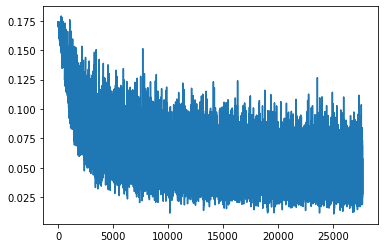

------
*********
29797 3094
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29797 466
Loss:  0.16859936714172363
Loss:  0.16605214774608612
Loss:  0.1684606373310089
0 **********
Epoch:  93.51296401023865  fold:  2  kers:  128
epoch:  1
29797 466
Loss:  0.16074761748313904
Loss:  0.1298806071281433
Loss:  0.11473619937896729
1 **********
Epoch:  174.7736895084381  fold:  2  kers:  128
epoch:  2
29797 466
Loss:  0.11317426711320877
Loss:  0.09766839444637299
Loss:  0.09591823071241379
2 **********
Epoch:  256.06433510780334  fold:  2  kers:  128
epoch:  3
Eval Loss:  0.7821573615074158
Eval Loss:  0.24106813967227936
Eval Loss:  0.542591392993927
[[1145  285]
 [ 532 1132]]
              preci

10 **********
Epoch:  1035.5481534004211  fold:  2  kers:  128
epoch:  11
29797 466
Loss:  0.04997975006699562
Loss:  0.04126826673746109
Loss:  0.0717473179101944
11 **********
Epoch:  1116.8118705749512  fold:  2  kers:  128
epoch:  12
Eval Loss:  0.5193103551864624
Eval Loss:  0.26303592324256897
Eval Loss:  0.3976641893386841
[[1289  141]
 [ 616 1048]]
              precision    recall  f1-score   support

           0       0.68      0.90      0.77      1430
           1       0.88      0.63      0.73      1664

    accuracy                           0.76      3094
   macro avg       0.78      0.77      0.75      3094
weighted avg       0.79      0.76      0.75      3094

acc:  0.7553329023917259
pre:  0.8814129520605551
rec:  0.6298076923076923
ma F1:  0.753839378943546
mi F1:  0.7553329023917259
we F1:  0.7523892358444834
update!  Acc:  0.7553329023917259
Eval Loss:  0.2802567780017853
Eval Loss:  0.28527510166168213
Eval Loss:  0.2727385461330414
Eval Loss:  0.24508772790431976

Eval Loss:  0.24615946412086487
Eval Loss:  0.24135169386863708
Eval Loss:  0.25450268387794495
Eval Loss:  0.22142940759658813
Eval Loss:  0.2238798886537552
Eval Loss:  0.22941425442695618
Eval Loss:  0.2787727415561676
Eval Loss:  0.23317323625087738
Eval Loss:  0.1977364867925644
Eval Loss:  0.23659946024417877
Eval Loss:  0.19097338616847992
Eval Loss:  0.1357707977294922
Eval Loss:  0.23087608814239502
Eval Loss:  0.23955106735229492
Eval Loss:  0.19391322135925293
Eval Loss:  0.2181728184223175
Eval Loss:  0.16321802139282227
Eval Loss:  0.2105819284915924
Eval Loss:  0.2481754720211029
Eval Loss:  0.13058781623840332
Eval Loss:  0.20048339664936066
Eval Loss:  0.2151118963956833
Eval Loss:  0.3060021698474884
Eval Loss:  0.34771639108657837
Eval Loss:  0.2660592794418335
Eval Loss:  0.169427290558815
Eval Loss:  0.2734764814376831
Eval Loss:  0.19361832737922668
Eval Loss:  0.16707921028137207
[[18010   724]
 [ 1927  9136]]
              precision    recall  f1-score   support


Eval Loss:  0.13214470446109772
Eval Loss:  0.15635357797145844
Eval Loss:  0.17935071885585785
Eval Loss:  0.28922128677368164
Eval Loss:  0.23164066672325134
Eval Loss:  0.21812686324119568
Eval Loss:  0.1260584443807602
Eval Loss:  0.2571616470813751
Eval Loss:  0.1333158314228058
Eval Loss:  0.13942579925060272
[[17854   880]
 [ 1288  9775]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     18734
           1       0.92      0.88      0.90     11063

    accuracy                           0.93     29797
   macro avg       0.93      0.92      0.92     29797
weighted avg       0.93      0.93      0.93     29797

acc:  0.9272409974158472
pre:  0.9174096668230878
rec:  0.8835758835758836
ma F1:  0.9214677786250627
mi F1:  0.9272409974158472
we F1:  0.9269494423636576
29797 466
Loss:  0.050029508769512177
Loss:  0.033225201070308685
Loss:  0.03609642758965492
30 **********
Epoch:  2963.3406281471252  fold:  2  kers:  128
epoch:  31
29

Loss:  0.044581372290849686
Loss:  0.044240038841962814
Loss:  0.03421976417303085
39 **********
Epoch:  3824.6297166347504  fold:  2  kers:  128
epoch:  40
29797 466
Loss:  0.04361756518483162
Loss:  0.03587530925869942
Loss:  0.05832263454794884
40 **********
Epoch:  3905.9203612804413  fold:  2  kers:  128
epoch:  41
29797 466
Loss:  0.06780555844306946
Loss:  0.06003081798553467
Loss:  0.04486431926488876
41 **********
Epoch:  3987.2568838596344  fold:  2  kers:  128
epoch:  42
Eval Loss:  0.5841667056083679
Eval Loss:  0.20106273889541626
Eval Loss:  1.10689115524292
[[1170  260]
 [ 585 1079]]
              precision    recall  f1-score   support

           0       0.67      0.82      0.73      1430
           1       0.81      0.65      0.72      1664

    accuracy                           0.73      3094
   macro avg       0.74      0.73      0.73      3094
weighted avg       0.74      0.73      0.73      3094

acc:  0.726890756302521
pre:  0.8058252427184466
rec:  0.6484375
ma

Eval Loss:  0.15365058183670044
Eval Loss:  0.1888321191072464
Eval Loss:  0.17389409244060516
Eval Loss:  0.20240522921085358
Eval Loss:  0.16944751143455505
Eval Loss:  0.1751176416873932
Eval Loss:  0.1963769644498825
Eval Loss:  0.18191573023796082
Eval Loss:  0.16088591516017914
Eval Loss:  0.14987899363040924
Eval Loss:  0.1680888533592224
Eval Loss:  0.10448187589645386
Eval Loss:  0.16274283826351166
Eval Loss:  0.23691153526306152
Eval Loss:  0.1651666909456253
Eval Loss:  0.15438786149024963
Eval Loss:  0.06247236579656601
Eval Loss:  0.17306676506996155
Eval Loss:  0.18491598963737488
Eval Loss:  0.16222698986530304
Eval Loss:  0.17697858810424805
Eval Loss:  0.13623499870300293
Eval Loss:  0.2778320908546448
Eval Loss:  0.2590807378292084
Eval Loss:  0.1808289885520935
Eval Loss:  0.12434211373329163
Eval Loss:  0.22152473032474518
Eval Loss:  0.1391650289297104
Eval Loss:  0.12495237588882446
[[17787   947]
 [ 1048 10015]]
              precision    recall  f1-score   supp

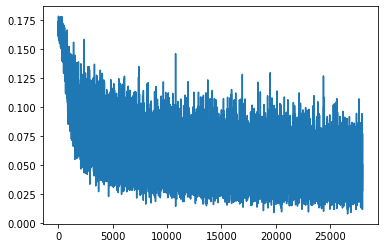

------
*********
29460 3431
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29460 461
Loss:  0.16643813252449036
Loss:  0.16021163761615753
Loss:  0.15985365211963654
0 **********
Epoch:  92.6781964302063  fold:  3  kers:  128
epoch:  1
29460 461
Loss:  0.16062341630458832
Loss:  0.13318073749542236
Loss:  0.11960294842720032
1 **********
Epoch:  173.0961754322052  fold:  3  kers:  128
epoch:  2
29460 461
Loss:  0.11657000333070755
Loss:  0.10351170599460602
Loss:  0.09982345998287201
2 **********
Epoch:  253.49121499061584  fold:  3  kers:  128
epoch:  3
Eval Loss:  0.9954921007156372
Eval Loss:  0.9504536986351013
Eval Loss:  0.42429792881011963
[[1365  171]
 [ 738 1157]]
              pre

Loss:  0.08461037278175354
Loss:  0.06000235304236412
Loss:  0.0716092512011528
11 **********
Epoch:  1106.5662655830383  fold:  3  kers:  128
epoch:  12
Eval Loss:  0.837809145450592
Eval Loss:  0.259242981672287
Eval Loss:  0.8251778483390808
[[1329  207]
 [ 643 1252]]
              precision    recall  f1-score   support

           0       0.67      0.87      0.76      1536
           1       0.86      0.66      0.75      1895

    accuracy                           0.75      3431
   macro avg       0.77      0.76      0.75      3431
weighted avg       0.78      0.75      0.75      3431

acc:  0.7522588166715244
pre:  0.858122001370802
rec:  0.6606860158311345
ma F1:  0.7521339757358425
mi F1:  0.7522588166715244
we F1:  0.751551925139612
Eval Loss:  0.40752220153808594
Eval Loss:  0.5009411573410034
Eval Loss:  0.1735677719116211
Eval Loss:  0.23088960349559784
Eval Loss:  0.2640034556388855
Eval Loss:  0.2552604675292969
Eval Loss:  0.37510764598846436
Eval Loss:  0.3143538534641

Eval Loss:  0.3128416836261749
Eval Loss:  0.35948318243026733
Eval Loss:  0.15773971378803253
Eval Loss:  0.18707513809204102
Eval Loss:  0.23187591135501862
Eval Loss:  0.17659533023834229
Eval Loss:  0.24146457016468048
Eval Loss:  0.28194373846054077
Eval Loss:  0.22416488826274872
Eval Loss:  0.24867555499076843
Eval Loss:  0.23977676033973694
Eval Loss:  0.27678343653678894
Eval Loss:  0.3424960970878601
Eval Loss:  0.17524942755699158
Eval Loss:  0.2638069689273834
Eval Loss:  0.19617830216884613
Eval Loss:  0.2311852127313614
Eval Loss:  0.2075284868478775
Eval Loss:  0.22684696316719055
Eval Loss:  0.26193785667419434
Eval Loss:  0.20052962005138397
Eval Loss:  0.3242790997028351
Eval Loss:  0.31577590107917786
Eval Loss:  0.19785483181476593
Eval Loss:  0.2581351399421692
Eval Loss:  0.25819817185401917
Eval Loss:  0.3176843523979187
Eval Loss:  0.2330528199672699
[[17813   815]
 [ 1811  9021]]
              precision    recall  f1-score   support

           0       0.91    

Eval Loss:  0.15507689118385315
Eval Loss:  0.24179981648921967
Eval Loss:  0.23906324803829193
Eval Loss:  0.26763415336608887
Eval Loss:  0.17420007288455963
[[17699   929]
 [ 1362  9470]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     18628
           1       0.91      0.87      0.89     10832

    accuracy                           0.92     29460
   macro avg       0.92      0.91      0.92     29460
weighted avg       0.92      0.92      0.92     29460

acc:  0.9222335369993211
pre:  0.910664486969901
rec:  0.8742614475627769
ma F1:  0.9156523928031612
mi F1:  0.9222335369993211
we F1:  0.921887245173226
29460 461
Loss:  0.07249555736780167
Loss:  0.07735613733530045
Loss:  0.040511634200811386
30 **********
Epoch:  2936.9222660064697  fold:  3  kers:  128
epoch:  31
29460 461
Loss:  0.04971969127655029
Loss:  0.045710667967796326
Loss:  0.044711675494909286
31 **********
Epoch:  3017.3771455287933  fold:  3  kers:  128
epoch:

Loss:  0.068003810942173
Loss:  0.06900754570960999
39 **********
Epoch:  3790.1159987449646  fold:  3  kers:  128
epoch:  40
29460 461
Loss:  0.049800559878349304
Loss:  0.056340593844652176
Loss:  0.052283257246017456
40 **********
Epoch:  3870.5349752902985  fold:  3  kers:  128
epoch:  41
29460 461
Loss:  0.03408895805478096
Loss:  0.04932676628232002
Loss:  0.07981260865926743
41 **********
Epoch:  3950.952954053879  fold:  3  kers:  128
epoch:  42
Eval Loss:  0.2855663001537323
Eval Loss:  0.08189985901117325
Eval Loss:  1.1057993173599243
[[1155  381]
 [ 538 1357]]
              precision    recall  f1-score   support

           0       0.68      0.75      0.72      1536
           1       0.78      0.72      0.75      1895

    accuracy                           0.73      3431
   macro avg       0.73      0.73      0.73      3431
weighted avg       0.74      0.73      0.73      3431

acc:  0.7321480617895657
pre:  0.7807825086306099
rec:  0.7160949868073878
ma F1:  0.731216387

Eval Loss:  0.231377512216568
Eval Loss:  0.22515635192394257
Eval Loss:  0.1653565615415573
Eval Loss:  0.1330944299697876
Eval Loss:  0.23865917325019836
Eval Loss:  0.10509415715932846
Eval Loss:  0.1780899167060852
Eval Loss:  0.17534102499485016
Eval Loss:  0.2028641700744629
Eval Loss:  0.12359140813350677
Eval Loss:  0.215143084526062
Eval Loss:  0.17966975271701813
Eval Loss:  0.20883440971374512
Eval Loss:  0.08611557632684708
Eval Loss:  0.19038720428943634
Eval Loss:  0.14201584458351135
Eval Loss:  0.16423441469669342
Eval Loss:  0.13978056609630585
Eval Loss:  0.1798391491174698
Eval Loss:  0.22448132932186127
Eval Loss:  0.1845734864473343
Eval Loss:  0.23516570031642914
Eval Loss:  0.2341524213552475
Eval Loss:  0.15069293975830078
Eval Loss:  0.20014937222003937
Eval Loss:  0.1625373661518097
Eval Loss:  0.24449649453163147
Eval Loss:  0.13773393630981445
[[17690   938]
 [  987  9845]]
              precision    recall  f1-score   support

           0       0.95      0

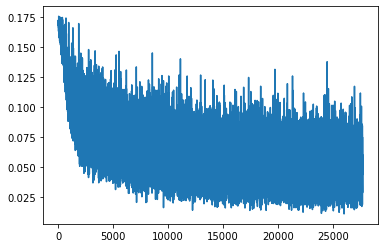

------
*********
29520 3371
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29520 462
Loss:  0.182927206158638
Loss:  0.16380320489406586
Loss:  0.1609133929014206
0 **********
Epoch:  92.80782651901245  fold:  4  kers:  128
epoch:  1
29520 462
Loss:  0.15878072381019592
Loss:  0.13342463970184326
Loss:  0.12591002881526947
1 **********
Epoch:  173.37640261650085  fold:  4  kers:  128
epoch:  2
29520 462
Loss:  0.1357264518737793
Loss:  0.10298377275466919
Loss:  0.11027728766202927
2 **********
Epoch:  253.94797110557556  fold:  4  kers:  128
epoch:  3
Eval Loss:  0.1663484126329422
Eval Loss:  0.19369511306285858
Eval Loss:  0.08353040367364883
[[3033  104]
 [ 217   17]]
              prec

Loss:  0.10793281346559525
Loss:  0.08048812299966812
Loss:  0.06601753830909729
11 **********
Epoch:  1112.1961889266968  fold:  4  kers:  128
epoch:  12
Eval Loss:  0.09650599956512451
Eval Loss:  0.13270042836666107
Eval Loss:  0.052922897040843964
[[3075   62]
 [ 204   30]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      3137
           1       0.33      0.13      0.18       234

    accuracy                           0.92      3371
   macro avg       0.63      0.55      0.57      3371
weighted avg       0.90      0.92      0.90      3371

acc:  0.921091664194601
pre:  0.32608695652173914
rec:  0.1282051282051282
ma F1:  0.5712951134433853
mi F1:  0.921091664194601
we F1:  0.9047793127309974
Eval Loss:  0.2363501638174057
Eval Loss:  0.36790353059768677
Eval Loss:  0.24414683878421783
Eval Loss:  0.3179593086242676
Eval Loss:  0.2763146758079529
Eval Loss:  0.31956639885902405
Eval Loss:  0.38077235221862793
Eval Loss:  0.2781

Eval Loss:  0.29231566190719604
Eval Loss:  0.2547319233417511
Eval Loss:  0.2131815105676651
Eval Loss:  0.27892231941223145
Eval Loss:  0.253777414560318
Eval Loss:  0.290758341550827
Eval Loss:  0.2673432528972626
Eval Loss:  0.2552054524421692
Eval Loss:  0.2923186421394348
Eval Loss:  0.2532094717025757
Eval Loss:  0.3707955479621887
Eval Loss:  0.22216780483722687
Eval Loss:  0.382978230714798
Eval Loss:  0.2550787031650543
Eval Loss:  0.2586747407913208
Eval Loss:  0.2280023694038391
Eval Loss:  0.2569045126438141
Eval Loss:  0.21440526843070984
Eval Loss:  0.3195939362049103
Eval Loss:  0.31016889214515686
Eval Loss:  0.1959255337715149
Eval Loss:  0.3232854902744293
Eval Loss:  0.24907410144805908
Eval Loss:  0.28053992986679077
Eval Loss:  0.25239986181259155
Eval Loss:  0.165745347738266
Eval Loss:  0.24402613937854767
Eval Loss:  0.19312234222888947
[[16235   792]
 [ 2507  9986]]
              precision    recall  f1-score   support

           0       0.87      0.95      0

Eval Loss:  0.2690260112285614
Eval Loss:  0.2533119320869446
Eval Loss:  0.1850043684244156
Eval Loss:  0.23370103538036346
Eval Loss:  0.2081657350063324
[[16226   801]
 [ 2150 10343]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.92     17027
           1       0.93      0.83      0.88     12493

    accuracy                           0.90     29520
   macro avg       0.91      0.89      0.90     29520
weighted avg       0.90      0.90      0.90     29520

acc:  0.9000338753387533
pre:  0.9281227566403446
rec:  0.8279036260305771
ma F1:  0.895899421638478
mi F1:  0.9000338753387533
we F1:  0.8990858253571671
29520 462
Loss:  0.05986190587282181
Loss:  0.07981976866722107
Loss:  0.07448914647102356
30 **********
Epoch:  2945.6668615341187  fold:  4  kers:  128
epoch:  31
29520 462
Loss:  0.058463700115680695
Loss:  0.03800911456346512
Loss:  0.056632764637470245
31 **********
Epoch:  3026.2843070030212  fold:  4  kers:  128
epoch:  32

Loss:  0.061988383531570435
Loss:  0.040445081889629364
39 **********
Epoch:  3800.749544620514  fold:  4  kers:  128
epoch:  40
29520 462
Loss:  0.059974219650030136
Loss:  0.0568602979183197
Loss:  0.07334723323583603
40 **********
Epoch:  3881.456749677658  fold:  4  kers:  128
epoch:  41
29520 462
Loss:  0.031221073120832443
Loss:  0.06026016175746918
Loss:  0.040298447012901306
41 **********
Epoch:  3962.1509890556335  fold:  4  kers:  128
epoch:  42
Eval Loss:  0.26601341366767883
Eval Loss:  0.09248021245002747
Eval Loss:  0.006846134550869465
[[2983  154]
 [ 180   54]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      3137
           1       0.26      0.23      0.24       234

    accuracy                           0.90      3371
   macro avg       0.60      0.59      0.60      3371
weighted avg       0.90      0.90      0.90      3371

acc:  0.9009196084247998
pre:  0.25961538461538464
rec:  0.23076923076923078
ma F1:  0.59

Eval Loss:  0.17339466512203217
Eval Loss:  0.21719525754451752
Eval Loss:  0.17978689074516296
Eval Loss:  0.2532237470149994
Eval Loss:  0.16160157322883606
Eval Loss:  0.1897123008966446
Eval Loss:  0.19181008636951447
Eval Loss:  0.20717130601406097
Eval Loss:  0.17951714992523193
Eval Loss:  0.18618452548980713
Eval Loss:  0.2674853503704071
Eval Loss:  0.11977362632751465
Eval Loss:  0.2142326533794403
Eval Loss:  0.19107317924499512
Eval Loss:  0.127370223402977
Eval Loss:  0.15964363515377045
Eval Loss:  0.1650390326976776
Eval Loss:  0.17013545334339142
Eval Loss:  0.18777614831924438
Eval Loss:  0.26154276728630066
Eval Loss:  0.11585912108421326
Eval Loss:  0.26663738489151
Eval Loss:  0.14238093793392181
Eval Loss:  0.21167799830436707
Eval Loss:  0.17111660540103912
Eval Loss:  0.16546949744224548
Eval Loss:  0.1526070237159729
Eval Loss:  0.1498538702726364
[[16231   796]
 [ 1473 11020]]
              precision    recall  f1-score   support

           0       0.92      0

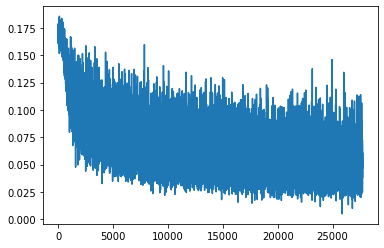

------
*********
29673 3218
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29673 464
Loss:  0.17278572916984558
Loss:  0.17154090106487274
Loss:  0.16378499567508698
0 **********
Epoch:  93.25166296958923  fold:  5  kers:  128
epoch:  1
29673 464
Loss:  0.15103036165237427
Loss:  0.14586256444454193
Loss:  0.13221615552902222
1 **********
Epoch:  174.25008964538574  fold:  5  kers:  128
epoch:  2
29673 464
Loss:  0.12583766877651215
Loss:  0.11693669855594635
Loss:  0.09845234453678131
2 **********
Epoch:  255.23455357551575  fold:  5  kers:  128
epoch:  3
Eval Loss:  0.17897041141986847
Eval Loss:  0.38631680607795715
Eval Loss:  0.264109343290329
[[2761  336]
 [  34   87]]
              p

Loss:  0.08525136858224869
Loss:  0.08534663170576096
10 **********
Epoch:  1033.1306183338165  fold:  5  kers:  128
epoch:  11
29673 464
Loss:  0.06900008767843246
Loss:  0.09332498162984848
Loss:  0.08876027166843414
11 **********
Epoch:  1114.1190712451935  fold:  5  kers:  128
epoch:  12
Eval Loss:  0.0802634209394455
Eval Loss:  0.13053688406944275
Eval Loss:  0.05494336038827896
[[3053   44]
 [  41   80]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3097
           1       0.65      0.66      0.65       121

    accuracy                           0.97      3218
   macro avg       0.82      0.82      0.82      3218
weighted avg       0.97      0.97      0.97      3218

acc:  0.973586078309509
pre:  0.6451612903225806
rec:  0.6611570247933884
ma F1:  0.8196658084975228
mi F1:  0.973586078309509
we F1:  0.9737413964425182
update!  Acc:  0.973586078309509
Eval Loss:  0.39345404505729675
Eval Loss:  0.3087741732597351
Eval Los

Eval Loss:  0.2561785876750946
Eval Loss:  0.20633360743522644
Eval Loss:  0.272591769695282
Eval Loss:  0.17422711849212646
Eval Loss:  0.3127487003803253
Eval Loss:  0.22807615995407104
Eval Loss:  0.3172016143798828
Eval Loss:  0.1604577898979187
Eval Loss:  0.33070066571235657
Eval Loss:  0.31470635533332825
Eval Loss:  0.3059386610984802
Eval Loss:  0.2676738202571869
Eval Loss:  0.23447653651237488
Eval Loss:  0.30399003624916077
Eval Loss:  0.13575176894664764
Eval Loss:  0.2678675055503845
Eval Loss:  0.2396726757287979
Eval Loss:  0.2572251558303833
Eval Loss:  0.24561811983585358
Eval Loss:  0.23709052801132202
Eval Loss:  0.19373053312301636
Eval Loss:  0.22588172554969788
Eval Loss:  0.25538724660873413
Eval Loss:  0.1858801543712616
Eval Loss:  0.2822754681110382
Eval Loss:  0.16912677884101868
Eval Loss:  0.31140580773353577
Eval Loss:  0.38723108172416687
Eval Loss:  0.28805527091026306
[[15831  1236]
 [ 1776 10830]]
              precision    recall  f1-score   support


Eval Loss:  0.21144217252731323
Eval Loss:  0.15603959560394287
Eval Loss:  0.2045578807592392
Eval Loss:  0.18760836124420166
Eval Loss:  0.174274280667305
Eval Loss:  0.2792792320251465
Eval Loss:  0.1509884148836136
Eval Loss:  0.32505765557289124
Eval Loss:  0.3277644217014313
Eval Loss:  0.2663005292415619
[[16100   967]
 [ 1787 10819]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     17067
           1       0.92      0.86      0.89     12606

    accuracy                           0.91     29673
   macro avg       0.91      0.90      0.90     29673
weighted avg       0.91      0.91      0.91     29673

acc:  0.9071883530482256
pre:  0.917953504157475
rec:  0.8582421069332065
ma F1:  0.9041524316651901
mi F1:  0.9071883530482256
we F1:  0.9067169545376994
29673 464
Loss:  0.06828150153160095
Loss:  0.07590429484844208
Loss:  0.08055783063173294
30 **********
Epoch:  2963.371545791626  fold:  5  kers:  128
epoch:  31
29673 464


Loss:  0.031080279499292374
Loss:  0.04054396599531174
Loss:  0.046515513211488724
39 **********
Epoch:  3821.8830609321594  fold:  5  kers:  128
epoch:  40
29673 464
Loss:  0.04566550254821777
Loss:  0.06675875931978226
Loss:  0.04360206052660942
40 **********
Epoch:  3902.8755025863647  fold:  5  kers:  128
epoch:  41
29673 464
Loss:  0.06461435556411743
Loss:  0.06316602230072021
Loss:  0.10262756049633026
41 **********
Epoch:  3983.8799142837524  fold:  5  kers:  128
epoch:  42
Eval Loss:  0.07360763102769852
Eval Loss:  0.08588004112243652
Eval Loss:  0.03153248131275177
[[3054   43]
 [  16  105]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3097
           1       0.71      0.87      0.78       121

    accuracy                           0.98      3218
   macro avg       0.85      0.93      0.89      3218
weighted avg       0.98      0.98      0.98      3218

acc:  0.9816656308266004
pre:  0.7094594594594594
rec:  0.86776

Eval Loss:  0.03650735318660736
[[3067   30]
 [  25   96]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3097
           1       0.76      0.79      0.78       121

    accuracy                           0.98      3218
   macro avg       0.88      0.89      0.88      3218
weighted avg       0.98      0.98      0.98      3218

acc:  0.9829086389061529
pre:  0.7619047619047619
rec:  0.7933884297520661
ma F1:  0.8842206003468345
mi F1:  0.9829086389061529
we F1:  0.9830747244641457
Eval Loss:  0.23449404537677765
Eval Loss:  0.1209939569234848
Eval Loss:  0.20519202947616577
Eval Loss:  0.1716674119234085
Eval Loss:  0.2354268580675125
Eval Loss:  0.1740664392709732
Eval Loss:  0.2233538180589676
Eval Loss:  0.13460318744182587
Eval Loss:  0.2689928412437439
Eval Loss:  0.2461830973625183
Eval Loss:  0.2526094615459442
Eval Loss:  0.22337627410888672
Eval Loss:  0.13573478162288666
Eval Loss:  0.29252758622169495
Eval Loss:  0.1579

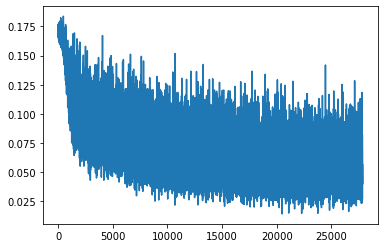

------
*********
29479 3412
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29479 461
Loss:  0.17505232989788055
Loss:  0.16959407925605774
Loss:  0.1709911823272705
0 **********
Epoch:  92.69714593887329  fold:  6  kers:  128
epoch:  1
29479 461
Loss:  0.15280504524707794
Loss:  0.13698358833789825
Loss:  0.12911668419837952
1 **********
Epoch:  173.13507103919983  fold:  6  kers:  128
epoch:  2
29479 461
Loss:  0.11580425500869751
Loss:  0.09795187413692474
Loss:  0.10418373346328735
2 **********
Epoch:  253.6039137840271  fold:  6  kers:  128
epoch:  3
Eval Loss:  0.1437145471572876
Eval Loss:  0.3148066997528076
Eval Loss:  0.5374559164047241
[[1871  361]
 [ 139 1041]]
              prec

Loss:  0.09099502116441727
Loss:  0.08784174919128418
Loss:  0.09806309640407562
11 **********
Epoch:  1112.5113697052002  fold:  6  kers:  128
epoch:  12
Eval Loss:  0.03700289875268936
Eval Loss:  0.2797640562057495
Eval Loss:  0.35912245512008667
[[2055  177]
 [ 184  996]]
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2232
           1       0.85      0.84      0.85      1180

    accuracy                           0.89      3412
   macro avg       0.88      0.88      0.88      3412
weighted avg       0.89      0.89      0.89      3412

acc:  0.8941969519343493
pre:  0.8491048593350383
rec:  0.8440677966101695
ma F1:  0.882918136172071
mi F1:  0.8941969519343493
we F1:  0.8941223988556564
Eval Loss:  0.22082078456878662
Eval Loss:  0.3034074306488037
Eval Loss:  0.3072279393672943
Eval Loss:  0.24948252737522125
Eval Loss:  0.2946973145008087
Eval Loss:  0.30566710233688354
Eval Loss:  0.3551095426082611
Eval Loss:  0.3111177

Eval Loss:  0.16408109664916992
Eval Loss:  0.2943916320800781
Eval Loss:  0.2629680931568146
Eval Loss:  0.2060687094926834
Eval Loss:  0.25493329763412476
Eval Loss:  0.2209678292274475
Eval Loss:  0.340487539768219
Eval Loss:  0.25665104389190674
Eval Loss:  0.2533952593803406
Eval Loss:  0.24308522045612335
Eval Loss:  0.25576621294021606
Eval Loss:  0.167574942111969
Eval Loss:  0.25576892495155334
Eval Loss:  0.25658002495765686
Eval Loss:  0.28370487689971924
Eval Loss:  0.18381832540035248
Eval Loss:  0.25673428177833557
Eval Loss:  0.23688125610351562
Eval Loss:  0.2126547396183014
Eval Loss:  0.35630306601524353
Eval Loss:  0.17218607664108276
Eval Loss:  0.24292191863059998
Eval Loss:  0.26346278190612793
Eval Loss:  0.2592853903770447
Eval Loss:  0.29296818375587463
Eval Loss:  0.28869178891181946
Eval Loss:  0.2586840093135834
Eval Loss:  0.19432571530342102
[[16672  1260]
 [ 1665  9882]]
              precision    recall  f1-score   support

           0       0.91      0

Eval Loss:  0.1918904036283493
Eval Loss:  0.2760683298110962
Eval Loss:  0.25480136275291443
Eval Loss:  0.21090221405029297
Eval Loss:  0.17081192135810852
[[16859  1073]
 [ 1488 10059]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     17932
           1       0.90      0.87      0.89     11547

    accuracy                           0.91     29479
   macro avg       0.91      0.91      0.91     29479
weighted avg       0.91      0.91      0.91     29479

acc:  0.9131245971708674
pre:  0.9036112109234639
rec:  0.871135359833723
ma F1:  0.9082421736609596
mi F1:  0.9131245971708674
we F1:  0.9128266257360715
29479 461
Loss:  0.044898878782987595
Loss:  0.08595598489046097
Loss:  0.05518234521150589
30 **********
Epoch:  2943.7599833011627  fold:  6  kers:  128
epoch:  31
29479 461
Loss:  0.04289572685956955
Loss:  0.08975768834352493
Loss:  0.08955822139978409
31 **********
Epoch:  3024.233812570572  fold:  6  kers:  128
epoch:  32

Loss:  0.06727743148803711
39 **********
Epoch:  3797.605972766876  fold:  6  kers:  128
epoch:  40
29479 461
Loss:  0.08180887252092361
Loss:  0.026715058833360672
Loss:  0.05674764886498451
40 **********
Epoch:  3882.497988462448  fold:  6  kers:  128
epoch:  41
29479 461
Loss:  0.06247955188155174
Loss:  0.05360022187232971
Loss:  0.08814474195241928
41 **********
Epoch:  3962.948879003525  fold:  6  kers:  128
epoch:  42
Eval Loss:  0.013761298730969429
Eval Loss:  0.31853702664375305
Eval Loss:  0.34880173206329346
[[2041  191]
 [ 290  890]]
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      2232
           1       0.82      0.75      0.79      1180

    accuracy                           0.86      3412
   macro avg       0.85      0.83      0.84      3412
weighted avg       0.86      0.86      0.86      3412

acc:  0.8590269636576788
pre:  0.8233117483811286
rec:  0.7542372881355932
ma F1:  0.8409245839586397
mi F1:  0.85902696

Eval Loss:  0.1673574447631836
Eval Loss:  0.24042680859565735
Eval Loss:  0.16506430506706238
Eval Loss:  0.17260584235191345
Eval Loss:  0.1631755232810974
Eval Loss:  0.1589004397392273
Eval Loss:  0.2885318100452423
Eval Loss:  0.207298144698143
Eval Loss:  0.17526254057884216
Eval Loss:  0.2144317328929901
Eval Loss:  0.19845598936080933
Eval Loss:  0.14253593981266022
Eval Loss:  0.18622371554374695
Eval Loss:  0.1708347648382187
Eval Loss:  0.2182764708995819
Eval Loss:  0.12353182584047318
Eval Loss:  0.19484862685203552
Eval Loss:  0.18919844925403595
Eval Loss:  0.16178442537784576
Eval Loss:  0.20365993678569794
Eval Loss:  0.15298934280872345
Eval Loss:  0.15350216627120972
Eval Loss:  0.19469000399112701
Eval Loss:  0.1168910339474678
Eval Loss:  0.25842103362083435
Eval Loss:  0.22541260719299316
Eval Loss:  0.17706157267093658
Eval Loss:  0.14732730388641357
[[16716  1216]
 [  899 10648]]
              precision    recall  f1-score   support

           0       0.95     

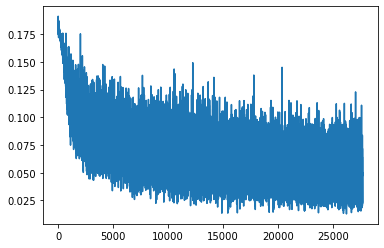

------
*********
29460 3431
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29460 461
Loss:  0.1600031554698944
Loss:  0.16649921238422394
Loss:  0.14359164237976074
0 **********
Epoch:  92.67919301986694  fold:  7  kers:  128
epoch:  1
29460 461
Loss:  0.11202424019575119
Loss:  0.12336113303899765
Loss:  0.09249255806207657
1 **********
Epoch:  173.09019017219543  fold:  7  kers:  128
epoch:  2
29460 461
Loss:  0.11289823055267334
Loss:  0.10637495666742325
Loss:  0.11117910593748093
2 **********
Epoch:  253.51814246177673  fold:  7  kers:  128
epoch:  3
Eval Loss:  0.7863808870315552
Eval Loss:  0.11821632832288742
Eval Loss:  2.319395065307617
[[1778  349]
 [ 727  577]]
              pre

Loss:  0.1213972195982933
Loss:  0.11085271090269089
Loss:  0.0720832571387291
11 **********
Epoch:  1107.283347606659  fold:  7  kers:  128
epoch:  12
Eval Loss:  1.050131916999817
Eval Loss:  0.08542522042989731
Eval Loss:  2.9511752128601074
[[2041   86]
 [ 843  461]]
              precision    recall  f1-score   support

           0       0.71      0.96      0.81      2127
           1       0.84      0.35      0.50      1304

    accuracy                           0.73      3431
   macro avg       0.78      0.66      0.66      3431
weighted avg       0.76      0.73      0.69      3431

acc:  0.7292334596327601
pre:  0.8427787934186471
rec:  0.3535276073619632
ma F1:  0.6563584964509738
mi F1:  0.7292334596327601
we F1:  0.6943180500576891
update!  Acc:  0.7292334596327601
Eval Loss:  0.21915900707244873
Eval Loss:  0.2627101540565491
Eval Loss:  0.35804712772369385
Eval Loss:  0.35432004928588867
Eval Loss:  0.3728368580341339
Eval Loss:  0.3318079710006714
Eval Loss:  0.30489671

Eval Loss:  0.15971161425113678
Eval Loss:  0.23145242035388947
Eval Loss:  0.28101012110710144
Eval Loss:  0.3443702161312103
Eval Loss:  0.29869207739830017
Eval Loss:  0.24524059891700745
Eval Loss:  0.2541818618774414
Eval Loss:  0.2555256485939026
Eval Loss:  0.2712549865245819
Eval Loss:  0.3178274631500244
Eval Loss:  0.2820485532283783
Eval Loss:  0.19244544208049774
Eval Loss:  0.23455727100372314
Eval Loss:  0.22661273181438446
Eval Loss:  0.1691933274269104
Eval Loss:  0.2679519057273865
Eval Loss:  0.2640575170516968
Eval Loss:  0.2878912687301636
Eval Loss:  0.33044153451919556
Eval Loss:  0.2413550168275833
Eval Loss:  0.2516495883464813
Eval Loss:  0.23142579197883606
Eval Loss:  0.2391689121723175
Eval Loss:  0.26375454664230347
Eval Loss:  0.3126119077205658
Eval Loss:  0.343242883682251
Eval Loss:  0.25987595319747925
Eval Loss:  0.2575782239437103
[[17276   761]
 [ 2340  9083]]
              precision    recall  f1-score   support

           0       0.88      0.96  

Eval Loss:  0.19461016356945038
Eval Loss:  0.22997881472110748
Eval Loss:  0.2732164263725281
Eval Loss:  0.2643114924430847
Eval Loss:  0.22233211994171143
Eval Loss:  0.22681252658367157
[[17174   863]
 [ 1684  9739]]
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     18037
           1       0.92      0.85      0.88     11423

    accuracy                           0.91     29460
   macro avg       0.91      0.90      0.91     29460
weighted avg       0.91      0.91      0.91     29460

acc:  0.9135437881873727
pre:  0.918600264101113
rec:  0.8525781318392717
ma F1:  0.9076624694523019
mi F1:  0.9135437881873727
we F1:  0.912894351377488
29460 461
Loss:  0.057420212775468826
Loss:  0.07079222798347473
Loss:  0.06017174571752548
30 **********
Epoch:  2941.072168827057  fold:  7  kers:  128
epoch:  31
29460 461
Loss:  0.06856755912303925
Loss:  0.037045273929834366
Loss:  0.04297707974910736
31 **********
Epoch:  3021.5440039634705 

Loss:  0.06811293214559555
Loss:  0.05587013438344002
Loss:  0.07917426526546478
39 **********
Epoch:  3796.304451942444  fold:  7  kers:  128
epoch:  40
29460 461
Loss:  0.03212179243564606
Loss:  0.029123486950993538
Loss:  0.045352354645729065
40 **********
Epoch:  3876.9218966960907  fold:  7  kers:  128
epoch:  41
29460 461
Loss:  0.048214759677648544
Loss:  0.04967249929904938
Loss:  0.05263711139559746
41 **********
Epoch:  3957.559288740158  fold:  7  kers:  128
epoch:  42
Eval Loss:  0.4263208210468292
Eval Loss:  0.09713062644004822
Eval Loss:  1.7105286121368408
[[1938  189]
 [ 524  780]]
              precision    recall  f1-score   support

           0       0.79      0.91      0.84      2127
           1       0.80      0.60      0.69      1304

    accuracy                           0.79      3431
   macro avg       0.80      0.75      0.77      3431
weighted avg       0.79      0.79      0.78      3431

acc:  0.792188866219761
pre:  0.804953560371517
rec:  0.5981595092

Eval Loss:  0.16562408208847046
Eval Loss:  0.15777206420898438
Eval Loss:  0.1738259345293045
Eval Loss:  0.25447237491607666
Eval Loss:  0.18169274926185608
Eval Loss:  0.1880839765071869
Eval Loss:  0.19380411505699158
Eval Loss:  0.16968104243278503
Eval Loss:  0.20896732807159424
Eval Loss:  0.2123114913702011
Eval Loss:  0.2553422152996063
Eval Loss:  0.10837088525295258
Eval Loss:  0.17003658413887024
Eval Loss:  0.20916229486465454
Eval Loss:  0.148309588432312
Eval Loss:  0.27209439873695374
Eval Loss:  0.2169252187013626
Eval Loss:  0.232471764087677
Eval Loss:  0.19682762026786804
Eval Loss:  0.16495177149772644
Eval Loss:  0.20689746737480164
Eval Loss:  0.1939961016178131
Eval Loss:  0.13789333403110504
Eval Loss:  0.21287664771080017
Eval Loss:  0.28006231784820557
Eval Loss:  0.2540293037891388
Eval Loss:  0.18845568597316742
Eval Loss:  0.22827690839767456
[[16628  1409]
 [  822 10601]]
              precision    recall  f1-score   support

           0       0.95      

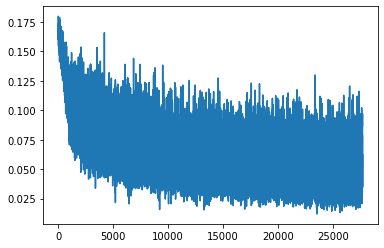

------
*********
29817 3074
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29817 466
Loss:  0.1741122305393219
Loss:  0.17074370384216309
Loss:  0.16241194307804108
0 **********
Epoch:  93.84008955955505  fold:  8  kers:  128
epoch:  1
29817 466
Loss:  0.1350448727607727
Loss:  0.13808482885360718
Loss:  0.11291100084781647
1 **********
Epoch:  175.40101265907288  fold:  8  kers:  128
epoch:  2
29817 466
Loss:  0.13644374907016754
Loss:  0.13634833693504333
Loss:  0.09779975563287735
2 **********
Epoch:  256.97589778900146  fold:  8  kers:  128
epoch:  3
Eval Loss:  0.28073543310165405
Eval Loss:  1.3332431316375732
Eval Loss:  0.18413344025611877
[[1931  142]
 [ 472  529]]
              pr

Loss:  0.04559154435992241
Loss:  0.09343650192022324
10 **********
Epoch:  1041.430425643921  fold:  8  kers:  128
epoch:  11
29817 466
Loss:  0.07640328258275986
Loss:  0.06870459765195847
Loss:  0.072486512362957
11 **********
Epoch:  1122.847732782364  fold:  8  kers:  128
epoch:  12
Eval Loss:  0.4965209364891052
Eval Loss:  1.3965144157409668
Eval Loss:  0.15475177764892578
[[1863  210]
 [ 308  693]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      2073
           1       0.77      0.69      0.73      1001

    accuracy                           0.83      3074
   macro avg       0.81      0.80      0.80      3074
weighted avg       0.83      0.83      0.83      3074

acc:  0.8314899154196487
pre:  0.7674418604651163
rec:  0.6923076923076923
ma F1:  0.8029432555302989
mi F1:  0.8314899154196488
we F1:  0.8290988276682331
update!  Acc:  0.8314899154196487
Eval Loss:  0.2879045307636261
Eval Loss:  0.2618424892425537
Eval Loss: 

Eval Loss:  0.26184970140457153
Eval Loss:  0.2692282199859619
Eval Loss:  0.1818016618490219
Eval Loss:  0.28746628761291504
Eval Loss:  0.20222744345664978
Eval Loss:  0.20838291943073273
Eval Loss:  0.42062458395957947
Eval Loss:  0.2513425648212433
Eval Loss:  0.2458026260137558
Eval Loss:  0.1721109300851822
Eval Loss:  0.19524769484996796
Eval Loss:  0.1368822455406189
Eval Loss:  0.22216796875
Eval Loss:  0.25368696451187134
Eval Loss:  0.2844700515270233
Eval Loss:  0.3017754852771759
Eval Loss:  0.29775843024253845
Eval Loss:  0.2170846313238144
Eval Loss:  0.26796138286590576
Eval Loss:  0.24260163307189941
Eval Loss:  0.2592897415161133
Eval Loss:  0.1665097177028656
Eval Loss:  0.2509799897670746
Eval Loss:  0.3337245583534241
Eval Loss:  0.28048914670944214
Eval Loss:  0.32042720913887024
Eval Loss:  0.19736063480377197
Eval Loss:  0.25470322370529175
Eval Loss:  0.23860672116279602
[[17287   804]
 [ 2129  9597]]
              precision    recall  f1-score   support

     

Eval Loss:  0.20323118567466736
Eval Loss:  0.20176845788955688
Eval Loss:  0.2382996678352356
Eval Loss:  0.27709075808525085
Eval Loss:  0.3159697353839874
Eval Loss:  0.31663286685943604
Eval Loss:  0.17556101083755493
Eval Loss:  0.193054661154747
Eval Loss:  0.1811397820711136
[[16946  1145]
 [ 1303 10423]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     18091
           1       0.90      0.89      0.89     11726

    accuracy                           0.92     29817
   macro avg       0.91      0.91      0.91     29817
weighted avg       0.92      0.92      0.92     29817

acc:  0.917899185028675
pre:  0.9010200553250346
rec:  0.8888794132696571
ma F1:  0.9137723868415217
mi F1:  0.917899185028675
we F1:  0.917799225790047
29817 466
Loss:  0.07089446485042572
Loss:  0.0643811821937561
Loss:  0.05772535130381584
30 **********
Epoch:  2975.5689327716827  fold:  8  kers:  128
epoch:  31
29817 466
Loss:  0.03471484035253525
Loss:

Loss:  0.04246164485812187
Loss:  0.044525016099214554
Loss:  0.035026535391807556
39 **********
Epoch:  3842.404191017151  fold:  8  kers:  128
epoch:  40
29817 466
Loss:  0.07193975150585175
Loss:  0.07169690728187561
Loss:  0.049860335886478424
40 **********
Epoch:  3924.0129854679108  fold:  8  kers:  128
epoch:  41
29817 466
Loss:  0.0441405326128006
Loss:  0.04820273444056511
Loss:  0.06006009504199028
41 **********
Epoch:  4005.6387350559235  fold:  8  kers:  128
epoch:  42
Eval Loss:  0.3462352454662323
Eval Loss:  1.075713872909546
Eval Loss:  0.13635188341140747
[[1884  189]
 [ 278  723]]
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      2073
           1       0.79      0.72      0.76      1001

    accuracy                           0.85      3074
   macro avg       0.83      0.82      0.82      3074
weighted avg       0.85      0.85      0.85      3074

acc:  0.8480806766428106
pre:  0.7927631578947368
rec:  0.722277722

Eval Loss:  0.20937088131904602
Eval Loss:  0.178659126162529
Eval Loss:  0.11999092251062393
Eval Loss:  0.15442728996276855
Eval Loss:  0.15545476973056793
Eval Loss:  0.13061964511871338
Eval Loss:  0.2579045593738556
Eval Loss:  0.19405312836170197
Eval Loss:  0.18197348713874817
Eval Loss:  0.0829935073852539
Eval Loss:  0.14475779235363007
Eval Loss:  0.14281748235225677
Eval Loss:  0.16899541020393372
Eval Loss:  0.16947634518146515
Eval Loss:  0.20799216628074646
Eval Loss:  0.2548322081565857
Eval Loss:  0.1756182610988617
Eval Loss:  0.15311473608016968
Eval Loss:  0.15971432626247406
Eval Loss:  0.1900215446949005
Eval Loss:  0.18594807386398315
Eval Loss:  0.14038614928722382
Eval Loss:  0.20281481742858887
Eval Loss:  0.2332005500793457
Eval Loss:  0.2245924025774002
Eval Loss:  0.24637877941131592
Eval Loss:  0.11283241212368011
Eval Loss:  0.17890676856040955
Eval Loss:  0.16264772415161133
[[17376   715]
 [ 1359 10367]]
              precision    recall  f1-score   supp

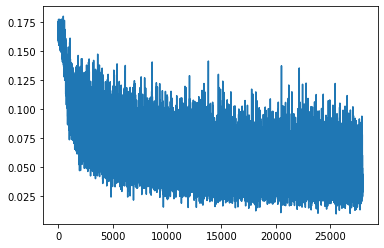

------
*********
29483 3408
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29483 461
Loss:  0.1704016774892807
Loss:  0.16662093997001648
Loss:  0.16670210659503937
0 **********
Epoch:  92.74402046203613  fold:  9  kers:  128
epoch:  1
29483 461
Loss:  0.14816612005233765
Loss:  0.1404891312122345
Loss:  0.12133706361055374
1 **********
Epoch:  173.21086812019348  fold:  9  kers:  128
epoch:  2
29483 461
Loss:  0.13037191331386566
Loss:  0.0915689468383789
Loss:  0.09280355274677277
2 **********
Epoch:  253.7445375919342  fold:  9  kers:  128
epoch:  3
Eval Loss:  0.2270161211490631
Eval Loss:  1.0638326406478882
Eval Loss:  0.3546285033226013
[[1568  174]
 [ 463 1203]]
              precis

Loss:  0.07352501899003983
Loss:  0.04796047881245613
Loss:  0.07754673808813095
11 **********
Epoch:  1108.30162525177  fold:  9  kers:  128
epoch:  12
Eval Loss:  0.03409457206726074
Eval Loss:  1.7626274824142456
Eval Loss:  0.21196983754634857
[[1681   61]
 [ 592 1074]]
              precision    recall  f1-score   support

           0       0.74      0.96      0.84      1742
           1       0.95      0.64      0.77      1666

    accuracy                           0.81      3408
   macro avg       0.84      0.80      0.80      3408
weighted avg       0.84      0.81      0.80      3408

acc:  0.8083920187793427
pre:  0.9462555066079296
rec:  0.6446578631452581
ma F1:  0.8021144378697698
mi F1:  0.8083920187793426
we F1:  0.8029004282307708
Eval Loss:  0.24664098024368286
Eval Loss:  0.29680103063583374
Eval Loss:  0.25252771377563477
Eval Loss:  0.24525569379329681
Eval Loss:  0.30482548475265503
Eval Loss:  0.25453701615333557
Eval Loss:  0.36478161811828613
Eval Loss:  0.3340

Eval Loss:  0.2274477183818817
Eval Loss:  0.2330373078584671
Eval Loss:  0.2278803139925003
Eval Loss:  0.25123319029808044
Eval Loss:  0.24212566018104553
Eval Loss:  0.22884827852249146
Eval Loss:  0.32896825671195984
Eval Loss:  0.3029995560646057
Eval Loss:  0.21383248269557953
Eval Loss:  0.1997765451669693
Eval Loss:  0.2864729166030884
Eval Loss:  0.22929349541664124
Eval Loss:  0.21856394410133362
Eval Loss:  0.29517054557800293
Eval Loss:  0.2848891019821167
Eval Loss:  0.2999359965324402
Eval Loss:  0.24331925809383392
Eval Loss:  0.16731184720993042
Eval Loss:  0.24134573340415955
Eval Loss:  0.3289164900779724
Eval Loss:  0.18218322098255157
Eval Loss:  0.28693318367004395
Eval Loss:  0.2321026623249054
Eval Loss:  0.3269818127155304
Eval Loss:  0.2483878880739212
Eval Loss:  0.1628817319869995
Eval Loss:  0.236826092004776
Eval Loss:  0.24839508533477783
[[17638   784]
 [ 2097  8964]]
              precision    recall  f1-score   support

           0       0.89      0.96

Eval Loss:  0.18631097674369812
Eval Loss:  0.25835350155830383
Eval Loss:  0.26189756393432617
Eval Loss:  0.13977740705013275
Eval Loss:  0.20153778791427612
Eval Loss:  0.24821962416172028
[[17625   797]
 [ 1670  9391]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     18422
           1       0.92      0.85      0.88     11061

    accuracy                           0.92     29483
   macro avg       0.92      0.90      0.91     29483
weighted avg       0.92      0.92      0.92     29483

acc:  0.9163246616694366
pre:  0.9217707106399686
rec:  0.8490190760329084
ma F1:  0.9092461237308173
mi F1:  0.9163246616694366
we F1:  0.9155741681522621
29483 461
Loss:  0.06661061197519302
Loss:  0.03234465792775154
Loss:  0.04136454686522484
30 **********
Epoch:  2943.0269434452057  fold:  9  kers:  128
epoch:  31
29483 461
Loss:  0.04982779920101166
Loss:  0.055493973195552826
Loss:  0.05092327669262886
31 **********
Epoch:  3023.5167295932

Loss:  0.04031790420413017
Loss:  0.06494660675525665
Loss:  0.06389306485652924
39 **********
Epoch:  3798.281167268753  fold:  9  kers:  128
epoch:  40
29483 461
Loss:  0.04609661176800728
Loss:  0.04464622586965561
Loss:  0.05491861328482628
40 **********
Epoch:  3878.916563987732  fold:  9  kers:  128
epoch:  41
29483 461
Loss:  0.05555133894085884
Loss:  0.09366802871227264
Loss:  0.061220306903123856
41 **********
Epoch:  3959.5549540519714  fold:  9  kers:  128
epoch:  42
Eval Loss:  0.029639018699526787
Eval Loss:  0.9690027236938477
Eval Loss:  0.1940675675868988
[[1674   68]
 [ 480 1186]]
              precision    recall  f1-score   support

           0       0.78      0.96      0.86      1742
           1       0.95      0.71      0.81      1666

    accuracy                           0.84      3408
   macro avg       0.86      0.84      0.84      3408
weighted avg       0.86      0.84      0.84      3408

acc:  0.8392018779342723
pre:  0.9457735247208932
rec:  0.711884753

Eval Loss:  0.1553936004638672
Eval Loss:  0.22907748818397522
Eval Loss:  0.1332520842552185
Eval Loss:  0.19172793626785278
Eval Loss:  0.16935627162456512
Eval Loss:  0.1128203421831131
Eval Loss:  0.24366158246994019
Eval Loss:  0.2599848806858063
Eval Loss:  0.15971647202968597
Eval Loss:  0.15543848276138306
Eval Loss:  0.17770668864250183
Eval Loss:  0.20603156089782715
Eval Loss:  0.15577249228954315
Eval Loss:  0.20329490303993225
Eval Loss:  0.17409998178482056
Eval Loss:  0.21915748715400696
Eval Loss:  0.23644223809242249
Eval Loss:  0.14928843080997467
Eval Loss:  0.1835361123085022
Eval Loss:  0.2398136556148529
Eval Loss:  0.12016303837299347
Eval Loss:  0.18314029276371002
Eval Loss:  0.16704542934894562
Eval Loss:  0.2160405069589615
Eval Loss:  0.2215804159641266
Eval Loss:  0.1272796094417572
Eval Loss:  0.1583573818206787
Eval Loss:  0.19986306130886078
[[17454   968]
 [ 1147  9914]]
              precision    recall  f1-score   support

           0       0.94     

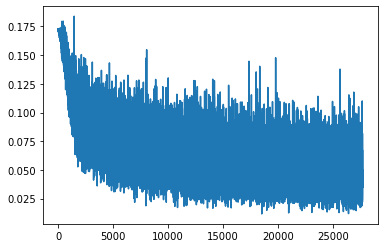

------
*********
29871 3020
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29871 467
Loss:  0.1620703786611557
Loss:  0.16361688077449799
Loss:  0.15808847546577454
0 **********
Epoch:  93.88696479797363  fold:  10  kers:  128
epoch:  1
29871 467
Loss:  0.1423080861568451
Loss:  0.15516509115695953
Loss:  0.11895902454853058
1 **********
Epoch:  175.53565287590027  fold:  10  kers:  128
epoch:  2
29871 467
Loss:  0.10424964129924774
Loss:  0.09364669024944305
Loss:  0.11018872261047363
2 **********
Epoch:  257.17636275291443  fold:  10  kers:  128
epoch:  3
Eval Loss:  0.4519112706184387
Eval Loss:  0.3309776782989502
Eval Loss:  0.1644388735294342
[[1506  245]
 [ 138 1131]]
              p

Loss:  0.06308730691671371
Loss:  0.049808405339717865
Loss:  0.06631195545196533
10 **********
Epoch:  1039.6491889953613  fold:  10  kers:  128
epoch:  11
29871 467
Loss:  0.08738826960325241
Loss:  0.10029975324869156
Loss:  0.06904846429824829
11 **********
Epoch:  1121.2121059894562  fold:  10  kers:  128
epoch:  12
Eval Loss:  0.5767215490341187
Eval Loss:  0.1409621685743332
Eval Loss:  0.08514022827148438
[[1631  120]
 [ 208 1061]]
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1751
           1       0.90      0.84      0.87      1269

    accuracy                           0.89      3020
   macro avg       0.89      0.88      0.89      3020
weighted avg       0.89      0.89      0.89      3020

acc:  0.8913907284768212
pre:  0.8983911939034717
rec:  0.8360914105594957
ma F1:  0.8873787732363141
mi F1:  0.8913907284768212
we F1:  0.8907713388958306
Eval Loss:  0.2483101189136505
Eval Loss:  0.2857535481452942
Eval Loss: 

Eval Loss:  0.21471728384494781
Eval Loss:  0.2544800043106079
Eval Loss:  0.18606586754322052
Eval Loss:  0.2571364641189575
Eval Loss:  0.27357515692710876
Eval Loss:  0.25021225214004517
Eval Loss:  0.2896520495414734
Eval Loss:  0.26343992352485657
Eval Loss:  0.17082908749580383
Eval Loss:  0.22895309329032898
Eval Loss:  0.15873046219348907
Eval Loss:  0.2759019434452057
Eval Loss:  0.2800922095775604
Eval Loss:  0.3089589774608612
Eval Loss:  0.230779230594635
Eval Loss:  0.1648414134979248
Eval Loss:  0.1897752583026886
Eval Loss:  0.21153074502944946
Eval Loss:  0.18749570846557617
Eval Loss:  0.2425844669342041
Eval Loss:  0.2727341949939728
Eval Loss:  0.1595630943775177
Eval Loss:  0.23257936537265778
Eval Loss:  0.28307366371154785
Eval Loss:  0.21103961765766144
Eval Loss:  0.19332902133464813
Eval Loss:  0.2570044696331024
Eval Loss:  0.2552010715007782
Eval Loss:  0.25331810116767883
[[17370  1043]
 [ 1818  9640]]
              precision    recall  f1-score   support

 

Eval Loss:  0.25031545758247375
Eval Loss:  0.16134312748908997
Eval Loss:  0.21081647276878357
Eval Loss:  0.24164660274982452
Eval Loss:  0.17555470764636993
Eval Loss:  0.21336455643177032
Eval Loss:  0.23440203070640564
Eval Loss:  0.240980863571167
Eval Loss:  0.24040164053440094
[[17279  1134]
 [ 1438 10020]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     18413
           1       0.90      0.87      0.89     11458

    accuracy                           0.91     29871
   macro avg       0.91      0.91      0.91     29871
weighted avg       0.91      0.91      0.91     29871

acc:  0.9138964212781627
pre:  0.8983324367939752
rec:  0.87449816721941
ma F1:  0.9084924769131972
mi F1:  0.9138964212781628
we F1:  0.9136701092397348
29871 467
Loss:  0.06858489662408829
Loss:  0.06017056107521057
Loss:  0.07052753865718842
30 **********
Epoch:  2972.329593896866  fold:  10  kers:  128
epoch:  31
29871 467
Loss:  0.04945545643568039


Loss:  0.042860932648181915
Loss:  0.033139798790216446
Loss:  0.058450255542993546
39 **********
Epoch:  3835.749983549118  fold:  10  kers:  128
epoch:  40
29871 467
Loss:  0.04081898555159569
Loss:  0.059607669711112976
Loss:  0.032590351998806
40 **********
Epoch:  3917.24707698822  fold:  10  kers:  128
epoch:  41
29871 467
Loss:  0.03938143700361252
Loss:  0.07346674054861069
Loss:  0.07519802451133728
41 **********
Epoch:  3998.7681062221527  fold:  10  kers:  128
epoch:  42
Eval Loss:  1.1443922519683838
Eval Loss:  0.17090894281864166
Eval Loss:  0.00833902508020401
[[1662   89]
 [ 266 1003]]
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      1751
           1       0.92      0.79      0.85      1269

    accuracy                           0.88      3020
   macro avg       0.89      0.87      0.88      3020
weighted avg       0.89      0.88      0.88      3020

acc:  0.8824503311258278
pre:  0.9184981684981685
rec:  0.790386

Eval Loss:  0.2372698187828064
Eval Loss:  0.22600586712360382
Eval Loss:  0.1643049269914627
Eval Loss:  0.21557530760765076
Eval Loss:  0.2254588007926941
Eval Loss:  0.20173947513103485
Eval Loss:  0.2528715431690216
Eval Loss:  0.2064959853887558
Eval Loss:  0.13733519613742828
Eval Loss:  0.16525447368621826
Eval Loss:  0.13832728564739227
Eval Loss:  0.1549481749534607
Eval Loss:  0.18236012756824493
Eval Loss:  0.2364274561405182
Eval Loss:  0.17168095707893372
Eval Loss:  0.10296458005905151
Eval Loss:  0.12336094677448273
Eval Loss:  0.19836582243442535
Eval Loss:  0.12971845269203186
Eval Loss:  0.1814677119255066
Eval Loss:  0.1768541932106018
Eval Loss:  0.19064784049987793
Eval Loss:  0.23811109364032745
Eval Loss:  0.18756993114948273
Eval Loss:  0.14768703281879425
Eval Loss:  0.1869361251592636
Eval Loss:  0.19299529492855072
Eval Loss:  0.19155128300189972
Eval Loss:  0.18857614696025848
[[17104  1309]
 [  975 10483]]
              precision    recall  f1-score   suppo

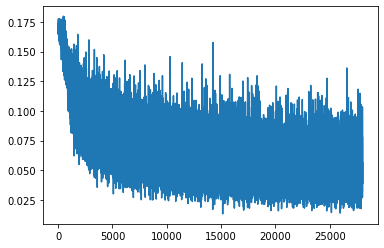

------
  
kernel: 64
  
*********
29459 3432
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29459 461
Loss:  0.16120390594005585
Loss:  0.15776154398918152
Loss:  0.1465785801410675
0 **********
Epoch:  58.618265867233276  fold:  1  kers:  64
epoch:  1
29459 461
Loss:  0.151450514793396
Loss:  0.10701507329940796
Loss:  0.11672909557819366
1 **********
Epoch:  104.839679479599  fold:  1  kers:  64
epoch:  2
29459 461
Loss:  0.09339414536952972
Loss:  0.10011100023984909
Loss:  0.10910061746835709
2 **********
Epoch:  150.98928475379944  fold:  1  kers:  64
epoch:  3
Eval Loss:  0.42739394307136536
Eval Loss:  0.499083548784256
Eval Loss:  0.18456771969795227
[[ 818  221]
 [ 690 1703]]
            

Loss:  0.1089596226811409
Loss:  0.08879605680704117
Loss:  0.08306233584880829
11 **********
Epoch:  685.8711194992065  fold:  1  kers:  64
epoch:  12
Eval Loss:  0.5553837418556213
Eval Loss:  0.5586149096488953
Eval Loss:  0.08704646676778793
[[ 892  147]
 [ 740 1653]]
              precision    recall  f1-score   support

           0       0.55      0.86      0.67      1039
           1       0.92      0.69      0.79      2393

    accuracy                           0.74      3432
   macro avg       0.73      0.77      0.73      3432
weighted avg       0.81      0.74      0.75      3432

acc:  0.7415501165501166
pre:  0.9183333333333333
rec:  0.6907647304638529
ma F1:  0.7281857953875275
mi F1:  0.7415501165501166
we F1:  0.75196410137195
update!  Acc:  0.7415501165501166
Eval Loss:  0.349822074174881
Eval Loss:  0.39758217334747314
Eval Loss:  0.287280410528183
Eval Loss:  0.22711487114429474
Eval Loss:  0.3688439726829529
Eval Loss:  0.3032852113246918
Eval Loss:  0.414240926504

Eval Loss:  0.31273743510246277
Eval Loss:  0.395530104637146
Eval Loss:  0.24303123354911804
Eval Loss:  0.2234366536140442
Eval Loss:  0.31224510073661804
Eval Loss:  0.29244548082351685
Eval Loss:  0.3274606466293335
Eval Loss:  0.24875277280807495
Eval Loss:  0.24849823117256165
Eval Loss:  0.28607696294784546
Eval Loss:  0.4424380660057068
Eval Loss:  0.2372744083404541
Eval Loss:  0.352946400642395
Eval Loss:  0.3859976530075073
Eval Loss:  0.31502974033355713
Eval Loss:  0.32874512672424316
Eval Loss:  0.29893404245376587
Eval Loss:  0.3061840236186981
Eval Loss:  0.2974672019481659
Eval Loss:  0.3006560206413269
Eval Loss:  0.37012386322021484
Eval Loss:  0.2964801490306854
Eval Loss:  0.23249459266662598
Eval Loss:  0.27785995602607727
Eval Loss:  0.28901180624961853
Eval Loss:  0.32151126861572266
Eval Loss:  0.28146618604660034
Eval Loss:  0.3260132968425751
[[18400   725]
 [ 2831  7503]]
              precision    recall  f1-score   support

           0       0.87      0.9

Eval Loss:  0.2401060312986374
Eval Loss:  0.25726082921028137
Eval Loss:  0.26405423879623413
Eval Loss:  0.2696562707424164
Eval Loss:  0.2394324392080307
[[18356   769]
 [ 2174  8160]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.93     19125
           1       0.91      0.79      0.85     10334

    accuracy                           0.90     29459
   macro avg       0.90      0.87      0.89     29459
weighted avg       0.90      0.90      0.90     29459

acc:  0.9000984419023049
pre:  0.9138761339455707
rec:  0.7896264757112444
ma F1:  0.8865024769488732
mi F1:  0.9000984419023049
we F1:  0.8982249296661758
29459 461
Loss:  0.08227957040071487
Loss:  0.058239419013261795
Loss:  0.06527552008628845
30 **********
Epoch:  1850.8721435070038  fold:  1  kers:  64
epoch:  31
29459 461
Loss:  0.07238359749317169
Loss:  0.03753442317247391
Loss:  0.07353728264570236
31 **********
Epoch:  1896.9609115123749  fold:  1  kers:  64
epoch:  32


Loss:  0.04834507405757904
Loss:  0.059529781341552734
39 **********
Epoch:  2386.073124885559  fold:  1  kers:  64
epoch:  40
29459 461
Loss:  0.05368286371231079
Loss:  0.0531047023832798
Loss:  0.06182178854942322
40 **********
Epoch:  2432.168874025345  fold:  1  kers:  64
epoch:  41
29459 461
Loss:  0.048567995429039
Loss:  0.07196584343910217
Loss:  0.04231995716691017
41 **********
Epoch:  2478.436164855957  fold:  1  kers:  64
epoch:  42
Eval Loss:  0.9557405114173889
Eval Loss:  0.27908527851104736
Eval Loss:  0.12811289727687836
[[ 747  292]
 [ 284 2109]]
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1039
           1       0.88      0.88      0.88      2393

    accuracy                           0.83      3432
   macro avg       0.80      0.80      0.80      3432
weighted avg       0.83      0.83      0.83      3432

acc:  0.8321678321678322
pre:  0.87838400666389
rec:  0.8813205181780193
ma F1:  0.8007944713500572
m

Eval Loss:  0.21034790575504303
Eval Loss:  0.2033202201128006
Eval Loss:  0.1950134038925171
Eval Loss:  0.16065464913845062
Eval Loss:  0.19144374132156372
Eval Loss:  0.220129132270813
Eval Loss:  0.25484055280685425
Eval Loss:  0.1848270744085312
Eval Loss:  0.16146375238895416
Eval Loss:  0.24326200783252716
Eval Loss:  0.29988741874694824
Eval Loss:  0.16082143783569336
Eval Loss:  0.22021877765655518
Eval Loss:  0.2471989542245865
Eval Loss:  0.2744658887386322
Eval Loss:  0.22772246599197388
Eval Loss:  0.20016378164291382
Eval Loss:  0.21815431118011475
Eval Loss:  0.1834297478199005
Eval Loss:  0.1933118999004364
Eval Loss:  0.2846727967262268
Eval Loss:  0.2949167490005493
Eval Loss:  0.15260817110538483
Eval Loss:  0.2018313705921173
Eval Loss:  0.22476492822170258
Eval Loss:  0.2360992431640625
Eval Loss:  0.2567649781703949
Eval Loss:  0.21469615399837494
[[18307   818]
 [ 1619  8715]]
              precision    recall  f1-score   support

           0       0.92      0.9

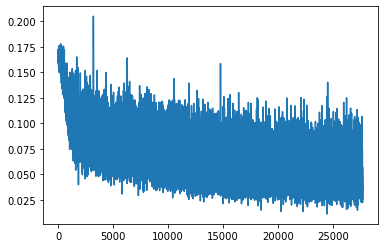

------
*********
29797 3094
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29797 466
Loss:  0.16806045174598694
Loss:  0.16239474713802338
Loss:  0.16026832163333893
0 **********
Epoch:  59.003235816955566  fold:  2  kers:  64
epoch:  1
29797 466
Loss:  0.1481606513261795
Loss:  0.12860475480556488
Loss:  0.12675337493419647
1 **********
Epoch:  105.8529691696167  fold:  2  kers:  64
epoch:  2
29797 466
Loss:  0.10718218982219696
Loss:  0.14371101558208466
Loss:  0.13335315883159637
2 **********
Epoch:  152.5431296825409  fold:  2  kers:  64
epoch:  3
Eval Loss:  1.0701334476470947
Eval Loss:  0.07834096252918243
Eval Loss:  1.0925397872924805
[[1249  181]
 [ 748  916]]
              precision    

10 **********
Epoch:  646.906302690506  fold:  2  kers:  64
epoch:  11
29797 466
Loss:  0.04771063104271889
Loss:  0.07942476123571396
Loss:  0.08525129407644272
11 **********
Epoch:  693.4767825603485  fold:  2  kers:  64
epoch:  12
Eval Loss:  0.4544822573661804
Eval Loss:  0.1816198080778122
Eval Loss:  0.3768421411514282
[[1242  188]
 [ 575 1089]]
              precision    recall  f1-score   support

           0       0.68      0.87      0.77      1430
           1       0.85      0.65      0.74      1664

    accuracy                           0.75      3094
   macro avg       0.77      0.76      0.75      3094
weighted avg       0.77      0.75      0.75      3094

acc:  0.753393665158371
pre:  0.8527799530148786
rec:  0.6544471153846154
ma F1:  0.7527891464063761
mi F1:  0.753393665158371
we F1:  0.7518645883150895
update!  Acc:  0.753393665158371
Eval Loss:  0.2937602698802948
Eval Loss:  0.19152584671974182
Eval Loss:  0.2527463734149933
Eval Loss:  0.3193848133087158
Eval Lo

Eval Loss:  0.2611646056175232
Eval Loss:  0.19658492505550385
Eval Loss:  0.24498306214809418
Eval Loss:  0.30816975235939026
Eval Loss:  0.20718951523303986
Eval Loss:  0.2504676282405853
Eval Loss:  0.31622114777565
Eval Loss:  0.316725492477417
Eval Loss:  0.2634119689464569
Eval Loss:  0.3073429763317108
Eval Loss:  0.30603912472724915
Eval Loss:  0.2623254954814911
Eval Loss:  0.3900183141231537
Eval Loss:  0.16647279262542725
Eval Loss:  0.2486683577299118
Eval Loss:  0.2910500764846802
Eval Loss:  0.2785073518753052
Eval Loss:  0.23393292725086212
Eval Loss:  0.2806752920150757
Eval Loss:  0.27085429430007935
Eval Loss:  0.23197491466999054
Eval Loss:  0.29599663615226746
Eval Loss:  0.28714972734451294
Eval Loss:  0.19667421281337738
Eval Loss:  0.2870662212371826
Eval Loss:  0.3595665991306305
Eval Loss:  0.4000025987625122
Eval Loss:  0.23206685483455658
Eval Loss:  0.22464720904827118
[[18011   723]
 [ 2525  8538]]
              precision    recall  f1-score   support

    

Eval Loss:  0.2637179493904114
Eval Loss:  0.1967349648475647
Eval Loss:  0.27772119641304016
Eval Loss:  0.27443957328796387
Eval Loss:  0.1436881422996521
Eval Loss:  0.24241499602794647
Eval Loss:  0.3014715611934662
Eval Loss:  0.39356642961502075
Eval Loss:  0.18520070612430573
Eval Loss:  0.20588964223861694
[[17696  1038]
 [ 1923  9140]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     18734
           1       0.90      0.83      0.86     11063

    accuracy                           0.90     29797
   macro avg       0.90      0.89      0.89     29797
weighted avg       0.90      0.90      0.90     29797

acc:  0.9006275799577138
pre:  0.8980153271762625
rec:  0.8261773479164783
ma F1:  0.8916979570592363
mi F1:  0.9006275799577138
we F1:  0.899703933830417
29797 466
Loss:  0.08841132372617722
Loss:  0.040988367050886154
Loss:  0.0651932880282402
30 **********
Epoch:  1859.942889213562  fold:  2  kers:  64
epoch:  31
29797 46

Loss:  0.0580563098192215
Loss:  0.06066669523715973
Loss:  0.046976059675216675
39 **********
Epoch:  2400.8506121635437  fold:  2  kers:  64
epoch:  40
29797 466
Loss:  0.04916606843471527
Loss:  0.049120232462882996
Loss:  0.06319957226514816
40 **********
Epoch:  2447.627539873123  fold:  2  kers:  64
epoch:  41
29797 466
Loss:  0.06541381776332855
Loss:  0.0593021996319294
Loss:  0.018021076917648315
41 **********
Epoch:  2494.379534959793  fold:  2  kers:  64
epoch:  42
Eval Loss:  0.4376211166381836
Eval Loss:  0.16958074271678925
Eval Loss:  0.7322851419448853
[[1251  179]
 [ 648 1016]]
              precision    recall  f1-score   support

           0       0.66      0.87      0.75      1430
           1       0.85      0.61      0.71      1664

    accuracy                           0.73      3094
   macro avg       0.75      0.74      0.73      3094
weighted avg       0.76      0.73      0.73      3094

acc:  0.7327084680025856
pre:  0.8502092050209205
rec:  0.6105769230769

Eval Loss:  0.23361720144748688
Eval Loss:  0.11945218592882156
Eval Loss:  0.19075652956962585
Eval Loss:  0.28285446763038635
Eval Loss:  0.18869319558143616
Eval Loss:  0.21723006665706635
Eval Loss:  0.30192694067955017
Eval Loss:  0.2413419783115387
Eval Loss:  0.1648862212896347
Eval Loss:  0.2470960021018982
Eval Loss:  0.2340988963842392
Eval Loss:  0.16512958705425262
Eval Loss:  0.28770872950553894
Eval Loss:  0.11374802887439728
Eval Loss:  0.1615629941225052
Eval Loss:  0.25180017948150635
Eval Loss:  0.2265169769525528
Eval Loss:  0.16523703932762146
Eval Loss:  0.2755885720252991
Eval Loss:  0.20902353525161743
Eval Loss:  0.12547700107097626
Eval Loss:  0.22590775787830353
Eval Loss:  0.2424718290567398
Eval Loss:  0.09842395037412643
Eval Loss:  0.19161450862884521
Eval Loss:  0.2712189257144928
Eval Loss:  0.3204469382762909
Eval Loss:  0.16021467745304108
Eval Loss:  0.21923333406448364
[[18119   615]
 [ 1790  9273]]
              precision    recall  f1-score   suppo

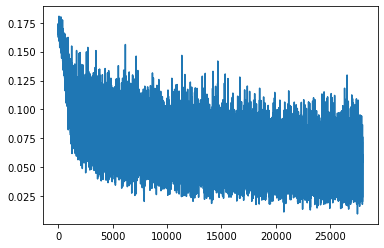

------
*********
29460 3431
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29460 461
Loss:  0.1687367707490921
Loss:  0.163202166557312
Loss:  0.1543501615524292
0 **********
Epoch:  58.56241583824158  fold:  3  kers:  64
epoch:  1
29460 461
Loss:  0.13723498582839966
Loss:  0.15141001343727112
Loss:  0.12283705919981003
1 **********
Epoch:  104.84965300559998  fold:  3  kers:  64
epoch:  2
29460 461
Loss:  0.11597554385662079
Loss:  0.11690101027488708
Loss:  0.12261530756950378
2 **********
Epoch:  151.16681098937988  fold:  3  kers:  64
epoch:  3
Eval Loss:  0.8268907070159912
Eval Loss:  0.9309386610984802
Eval Loss:  0.37742936611175537
[[1310  226]
 [ 588 1307]]
              precision    re

Loss:  0.08451235294342041
Loss:  0.09965884685516357
Loss:  0.07006005942821503
11 **********
Epoch:  686.8993713855743  fold:  3  kers:  64
epoch:  12
Eval Loss:  1.0912144184112549
Eval Loss:  0.3911237120628357
Eval Loss:  0.7841521501541138
[[1409  127]
 [ 796 1099]]
              precision    recall  f1-score   support

           0       0.64      0.92      0.75      1536
           1       0.90      0.58      0.70      1895

    accuracy                           0.73      3431
   macro avg       0.77      0.75      0.73      3431
weighted avg       0.78      0.73      0.73      3431

acc:  0.7309822209268435
pre:  0.8964110929853181
rec:  0.5799472295514512
ma F1:  0.7287679900949504
mi F1:  0.7309822209268436
we F1:  0.7262037679380164
Eval Loss:  0.31507185101509094
Eval Loss:  0.48703449964523315
Eval Loss:  0.42281630635261536
Eval Loss:  0.43633779883384705
Eval Loss:  0.41602054238319397
Eval Loss:  0.3519074618816376
Eval Loss:  0.3553663194179535
Eval Loss:  0.43038904

Eval Loss:  0.18357916176319122
Eval Loss:  0.27643951773643494
Eval Loss:  0.3072718381881714
Eval Loss:  0.25392815470695496
Eval Loss:  0.2641800343990326
Eval Loss:  0.22845596075057983
Eval Loss:  0.24156717956066132
Eval Loss:  0.22208601236343384
Eval Loss:  0.32806581258773804
Eval Loss:  0.21234102547168732
Eval Loss:  0.27368584275245667
Eval Loss:  0.22590021789073944
Eval Loss:  0.2567719519138336
Eval Loss:  0.26099199056625366
Eval Loss:  0.23236966133117676
Eval Loss:  0.24486403167247772
Eval Loss:  0.30074164271354675
Eval Loss:  0.19979941844940186
Eval Loss:  0.24160273373126984
Eval Loss:  0.24425771832466125
Eval Loss:  0.30847251415252686
Eval Loss:  0.25921717286109924
Eval Loss:  0.34524473547935486
Eval Loss:  0.25063982605934143
Eval Loss:  0.3139837682247162
Eval Loss:  0.3132350444793701
Eval Loss:  0.27707362174987793
Eval Loss:  0.16886253654956818
[[17708   920]
 [ 1988  8844]]
              precision    recall  f1-score   support

           0       0.90

Eval Loss:  0.31196433305740356
Eval Loss:  0.22937056422233582
Eval Loss:  0.3012295663356781
Eval Loss:  0.31398022174835205
Eval Loss:  0.21768556535243988
Eval Loss:  0.13306845724582672
[[17200  1428]
 [ 1238  9594]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     18628
           1       0.87      0.89      0.88     10832

    accuracy                           0.91     29460
   macro avg       0.90      0.90      0.90     29460
weighted avg       0.91      0.91      0.91     29460

acc:  0.9095044127630686
pre:  0.8704409363091998
rec:  0.8857090103397341
ma F1:  0.903041424241916
mi F1:  0.9095044127630686
we F1:  0.9096658600177386
29460 461
Loss:  0.04899701476097107
Loss:  0.09114792943000793
Loss:  0.06890004873275757
30 **********
Epoch:  1845.6850135326385  fold:  3  kers:  64
epoch:  31
29460 461
Loss:  0.03967028856277466
Loss:  0.06674664467573166
Loss:  0.07796847075223923
31 **********
Epoch:  1892.0759737491608 

Loss:  0.04720069095492363
Loss:  0.060686830431222916
39 **********
Epoch:  2382.57049036026  fold:  3  kers:  64
epoch:  40
29460 461
Loss:  0.06233273446559906
Loss:  0.05796503275632858
Loss:  0.03712897375226021
40 **********
Epoch:  2428.81982922554  fold:  3  kers:  64
epoch:  41
29460 461
Loss:  0.056123096495866776
Loss:  0.04591398686170578
Loss:  0.03766292333602905
41 **********
Epoch:  2475.01331782341  fold:  3  kers:  64
epoch:  42
Eval Loss:  0.30852246284484863
Eval Loss:  0.0938921868801117
Eval Loss:  0.8918675780296326
[[1203  333]
 [ 440 1455]]
              precision    recall  f1-score   support

           0       0.73      0.78      0.76      1536
           1       0.81      0.77      0.79      1895

    accuracy                           0.77      3431
   macro avg       0.77      0.78      0.77      3431
weighted avg       0.78      0.77      0.78      3431

acc:  0.7747012532789275
pre:  0.8137583892617449
rec:  0.7678100263852242
ma F1:  0.7734792633950553

Eval Loss:  0.19017158448696136
Eval Loss:  0.21559514105319977
Eval Loss:  0.234521746635437
Eval Loss:  0.16200250387191772
Eval Loss:  0.23508119583129883
Eval Loss:  0.1939825415611267
Eval Loss:  0.19016586244106293
Eval Loss:  0.1509253978729248
Eval Loss:  0.22691847383975983
Eval Loss:  0.18425406515598297
Eval Loss:  0.18652060627937317
Eval Loss:  0.2028922289609909
Eval Loss:  0.19220417737960815
Eval Loss:  0.1687590330839157
Eval Loss:  0.1641765832901001
Eval Loss:  0.22398430109024048
Eval Loss:  0.28994500637054443
Eval Loss:  0.22387045621871948
Eval Loss:  0.13828755915164948
Eval Loss:  0.19513976573944092
Eval Loss:  0.23704802989959717
Eval Loss:  0.25698980689048767
Eval Loss:  0.2714070975780487
Eval Loss:  0.18339787423610687
Eval Loss:  0.2604648768901825
Eval Loss:  0.2892758846282959
Eval Loss:  0.19177761673927307
Eval Loss:  0.1142486184835434
[[17234  1394]
 [  961  9871]]
              precision    recall  f1-score   support

           0       0.95      

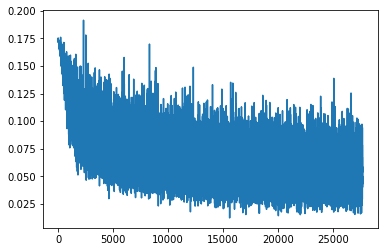

------
*********
29520 3371
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29520 462
Loss:  0.16954565048217773
Loss:  0.1689925193786621
Loss:  0.15845155715942383
0 **********
Epoch:  58.773850440979004  fold:  4  kers:  64
epoch:  1
29520 462
Loss:  0.1515325903892517
Loss:  0.12973934412002563
Loss:  0.12956126034259796
1 **********
Epoch:  105.18375992774963  fold:  4  kers:  64
epoch:  2
29520 462
Loss:  0.11198706179857254
Loss:  0.09549795836210251
Loss:  0.10816886276006699
2 **********
Epoch:  151.57771134376526  fold:  4  kers:  64
epoch:  3
Eval Loss:  0.5630228519439697
Eval Loss:  0.48591122031211853
Eval Loss:  0.13856995105743408
[[2620  517]
 [ 120  114]]
              precision  

Loss:  0.10479593276977539
Loss:  0.0791606456041336
Loss:  0.08159205317497253
11 **********
Epoch:  688.7025489807129  fold:  4  kers:  64
epoch:  12
Eval Loss:  0.11516693979501724
Eval Loss:  0.13260583579540253
Eval Loss:  0.04393521696329117
[[3095   42]
 [ 225    9]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3137
           1       0.18      0.04      0.06       234

    accuracy                           0.92      3371
   macro avg       0.55      0.51      0.51      3371
weighted avg       0.88      0.92      0.90      3371

acc:  0.9207950163156333
pre:  0.17647058823529413
rec:  0.038461538461538464
ma F1:  0.5109037111906295
mi F1:  0.9207950163156334
we F1:  0.8964884353571513
update!  Acc:  0.9207950163156333
Eval Loss:  0.37132376432418823
Eval Loss:  0.4227798283100128
Eval Loss:  0.42019039392471313
Eval Loss:  0.32799598574638367
Eval Loss:  0.326572060585022
Eval Loss:  0.28660720586776733
Eval Loss:  0.34

Eval Loss:  0.2878645360469818
Eval Loss:  0.2967740595340729
Eval Loss:  0.3024132549762726
Eval Loss:  0.20623980462551117
Eval Loss:  0.18707814812660217
Eval Loss:  0.22894008457660675
Eval Loss:  0.2513083517551422
Eval Loss:  0.30103227496147156
Eval Loss:  0.29778966307640076
Eval Loss:  0.3010859191417694
Eval Loss:  0.275221586227417
Eval Loss:  0.31601545214653015
Eval Loss:  0.2946106195449829
Eval Loss:  0.2966694235801697
Eval Loss:  0.3116375207901001
Eval Loss:  0.2829910218715668
Eval Loss:  0.25581368803977966
Eval Loss:  0.27861520648002625
Eval Loss:  0.2825610339641571
Eval Loss:  0.37567347288131714
Eval Loss:  0.2531326711177826
Eval Loss:  0.27690351009368896
Eval Loss:  0.3453369140625
Eval Loss:  0.2894963324069977
Eval Loss:  0.3195493221282959
Eval Loss:  0.36274275183677673
Eval Loss:  0.3431866466999054
Eval Loss:  0.30377939343452454
[[16145   882]
 [ 2506  9987]]
              precision    recall  f1-score   support

           0       0.87      0.95     

Eval Loss:  0.276787668466568
Eval Loss:  0.3239593505859375
Eval Loss:  0.30020052194595337
Eval Loss:  0.24541696906089783
[[16015  1012]
 [ 1787 10706]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     17027
           1       0.91      0.86      0.88     12493

    accuracy                           0.91     29520
   macro avg       0.91      0.90      0.90     29520
weighted avg       0.91      0.91      0.90     29520

acc:  0.9051829268292683
pre:  0.913637139443591
rec:  0.8569598975426239
ma F1:  0.902013663956628
mi F1:  0.9051829268292682
we F1:  0.9047202825033507
29520 462
Loss:  0.06403074413537979
Loss:  0.10170065611600876
Loss:  0.05913490802049637
30 **********
Epoch:  1848.9283409118652  fold:  4  kers:  64
epoch:  31
29520 462
Loss:  0.05642078071832657
Loss:  0.054221261292696
Loss:  0.07021482288837433
31 **********
Epoch:  1895.0300743579865  fold:  4  kers:  64
epoch:  32
29520 462
Loss:  0.07164038717746735


Loss:  0.0648476630449295
Loss:  0.04216671735048294
Loss:  0.07481829822063446
40 **********
Epoch:  2429.0252799987793  fold:  4  kers:  64
epoch:  41
29520 462
Loss:  0.056216929107904434
Loss:  0.07139991223812103
Loss:  0.04368395358324051
41 **********
Epoch:  2475.391306400299  fold:  4  kers:  64
epoch:  42
Eval Loss:  0.018941815942525864
Eval Loss:  0.12463360279798508
Eval Loss:  0.005100960843265057
[[3080   57]
 [ 219   15]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      3137
           1       0.21      0.06      0.10       234

    accuracy                           0.92      3371
   macro avg       0.57      0.52      0.53      3371
weighted avg       0.88      0.92      0.90      3371

acc:  0.9181251854049244
pre:  0.20833333333333334
rec:  0.0641025641025641
ma F1:  0.5275777184708563
mi F1:  0.9181251854049244
we F1:  0.8974828723075935
Eval Loss:  0.22019660472869873
Eval Loss:  0.21121053397655487
Eval Loss:

Eval Loss:  0.18932603299617767
Eval Loss:  0.17408789694309235
Eval Loss:  0.23791547119617462
Eval Loss:  0.12037045508623123
Eval Loss:  0.13120682537555695
Eval Loss:  0.1275402307510376
Eval Loss:  0.2029595673084259
Eval Loss:  0.20564967393875122
Eval Loss:  0.19501376152038574
Eval Loss:  0.20618394017219543
Eval Loss:  0.1724502295255661
Eval Loss:  0.21522054076194763
Eval Loss:  0.19751471281051636
Eval Loss:  0.18769334256649017
Eval Loss:  0.19157548248767853
Eval Loss:  0.23937518894672394
Eval Loss:  0.15384548902511597
Eval Loss:  0.21266911923885345
Eval Loss:  0.21147508919239044
Eval Loss:  0.25576964020729065
Eval Loss:  0.14527681469917297
Eval Loss:  0.16961005330085754
Eval Loss:  0.23447196185588837
Eval Loss:  0.26305609941482544
Eval Loss:  0.2053007036447525
Eval Loss:  0.22888264060020447
Eval Loss:  0.24416494369506836
Eval Loss:  0.18954706192016602
[[16001  1026]
 [ 1453 11040]]
              precision    recall  f1-score   support

           0       0.9

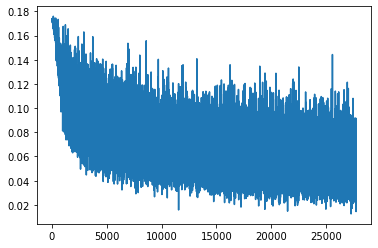

------
*********
29673 3218
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29673 464
Loss:  0.17323820292949677
Loss:  0.1659143716096878
Loss:  0.1574469655752182
0 **********
Epoch:  58.923449993133545  fold:  5  kers:  64
epoch:  1
29673 464
Loss:  0.139614999294281
Loss:  0.1358591914176941
Loss:  0.12939120829105377
1 **********
Epoch:  105.54878449440002  fold:  5  kers:  64
epoch:  2
29673 464
Loss:  0.12377418577671051
Loss:  0.11779651790857315
Loss:  0.09125981479883194
2 **********
Epoch:  151.91580820083618  fold:  5  kers:  64
epoch:  3
Eval Loss:  0.1663045883178711
Eval Loss:  0.3274106979370117
Eval Loss:  0.38810527324676514
[[2687  410]
 [  43   78]]
              precision    re

Loss:  0.09848019480705261
Loss:  0.08863704651594162
10 **********
Epoch:  643.0386447906494  fold:  5  kers:  64
epoch:  11
29673 464
Loss:  0.06579716503620148
Loss:  0.09169545769691467
Loss:  0.10249143838882446
11 **********
Epoch:  689.4385807514191  fold:  5  kers:  64
epoch:  12
Eval Loss:  0.09872129559516907
Eval Loss:  0.1581062376499176
Eval Loss:  0.08145857602357864
[[3036   61]
 [  24   97]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3097
           1       0.61      0.80      0.70       121

    accuracy                           0.97      3218
   macro avg       0.80      0.89      0.84      3218
weighted avg       0.98      0.97      0.98      3218

acc:  0.973586078309509
pre:  0.6139240506329114
rec:  0.8016528925619835
ma F1:  0.8407675385361418
mi F1:  0.973586078309509
we F1:  0.9752581728898474
update!  Acc:  0.973586078309509
Eval Loss:  0.25083380937576294
Eval Loss:  0.36700600385665894
Eval Loss: 

Eval Loss:  0.23728956282138824
Eval Loss:  0.3319576382637024
Eval Loss:  0.27200374007225037
Eval Loss:  0.23601990938186646
Eval Loss:  0.2833268344402313
Eval Loss:  0.24992819130420685
Eval Loss:  0.22575078904628754
Eval Loss:  0.25812163949012756
Eval Loss:  0.19836659729480743
Eval Loss:  0.2967589199542999
Eval Loss:  0.2151084691286087
Eval Loss:  0.21614301204681396
Eval Loss:  0.2855837643146515
Eval Loss:  0.30070674419403076
Eval Loss:  0.18542546033859253
Eval Loss:  0.2096043825149536
Eval Loss:  0.294287770986557
Eval Loss:  0.2971707582473755
Eval Loss:  0.22951333224773407
Eval Loss:  0.2436080425977707
Eval Loss:  0.2830454111099243
Eval Loss:  0.28143811225891113
Eval Loss:  0.26862064003944397
Eval Loss:  0.32234102487564087
Eval Loss:  0.21923519670963287
Eval Loss:  0.3021406829357147
Eval Loss:  0.3317197263240814
Eval Loss:  0.29575806856155396
Eval Loss:  0.2651975750923157
[[16083   984]
 [ 2466 10140]]
              precision    recall  f1-score   support



Eval Loss:  0.2418426275253296
Eval Loss:  0.2446470409631729
Eval Loss:  0.29590871930122375
Eval Loss:  0.2284747213125229
Eval Loss:  0.31431227922439575
Eval Loss:  0.19263297319412231
Eval Loss:  0.27468493580818176
Eval Loss:  0.3040519952774048
Eval Loss:  0.29109469056129456
Eval Loss:  0.23476798832416534
[[16197   870]
 [ 2378 10228]]
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     17067
           1       0.92      0.81      0.86     12606

    accuracy                           0.89     29673
   macro avg       0.90      0.88      0.89     29673
weighted avg       0.89      0.89      0.89     29673

acc:  0.8905402217504128
pre:  0.9216074968462786
rec:  0.8113596699984135
ma F1:  0.8859241344102469
mi F1:  0.8905402217504128
we F1:  0.8893740197552763
29673 464
Loss:  0.07856995612382889
Loss:  0.055713899433612823
Loss:  0.08615994453430176
30 **********
Epoch:  1857.2012207508087  fold:  5  kers:  64
epoch:  31
29673

Loss:  0.08092297613620758
Loss:  0.04654014855623245
Loss:  0.05109188333153725
39 **********
Epoch:  2394.1126289367676  fold:  5  kers:  64
epoch:  40
29673 464
Loss:  0.06161317601799965
Loss:  0.0833810344338417
Loss:  0.049876078963279724
40 **********
Epoch:  2440.5434823036194  fold:  5  kers:  64
epoch:  41
29673 464
Loss:  0.07691427320241928
Loss:  0.07264600694179535
Loss:  0.10255929827690125
41 **********
Epoch:  2487.057114124298  fold:  5  kers:  64
epoch:  42
Eval Loss:  0.05607952922582626
Eval Loss:  0.051035791635513306
Eval Loss:  0.019553137943148613
[[3074   23]
 [  32   89]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3097
           1       0.79      0.74      0.76       121

    accuracy                           0.98      3218
   macro avg       0.89      0.86      0.88      3218
weighted avg       0.98      0.98      0.98      3218

acc:  0.9829086389061529
pre:  0.7946428571428571
rec:  0.735537190

Eval Loss:  0.15511810779571533
Eval Loss:  0.2922767102718353
Eval Loss:  0.22309502959251404
Eval Loss:  0.21941091120243073
Eval Loss:  0.2781291902065277
Eval Loss:  0.22382493317127228
Eval Loss:  0.22617076337337494
Eval Loss:  0.24119305610656738
Eval Loss:  0.19086487591266632
Eval Loss:  0.26278769969940186
Eval Loss:  0.1886788159608841
Eval Loss:  0.1811217963695526
Eval Loss:  0.20937688648700714
Eval Loss:  0.235567107796669
Eval Loss:  0.1779971420764923
Eval Loss:  0.18338380753993988
Eval Loss:  0.2333555966615677
Eval Loss:  0.2720823585987091
Eval Loss:  0.17371296882629395
Eval Loss:  0.2543390393257141
Eval Loss:  0.20924389362335205
Eval Loss:  0.23509781062602997
Eval Loss:  0.18908755481243134
Eval Loss:  0.2569938600063324
Eval Loss:  0.2006123811006546
Eval Loss:  0.2624383866786957
Eval Loss:  0.2518801987171173
Eval Loss:  0.26750874519348145
Eval Loss:  0.2060413658618927
[[16239   828]
 [ 2070 10536]]
              precision    recall  f1-score   support

 

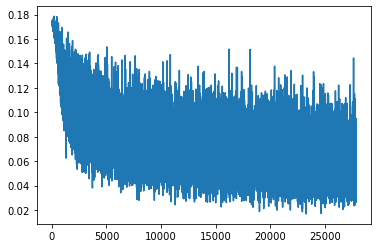

------
*********
29479 3412
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29479 461
Loss:  0.16245673596858978
Loss:  0.16621242463588715
Loss:  0.16979621350765228
0 **********
Epoch:  58.69805288314819  fold:  6  kers:  64
epoch:  1
29479 461
Loss:  0.15875662863254547
Loss:  0.1479576826095581
Loss:  0.12842902541160583
1 **********
Epoch:  105.13987684249878  fold:  6  kers:  64
epoch:  2
29479 461
Loss:  0.14032863080501556
Loss:  0.09481532871723175
Loss:  0.12096717208623886
2 **********
Epoch:  151.48196697235107  fold:  6  kers:  64
epoch:  3
Eval Loss:  0.12569008767604828
Eval Loss:  0.3420523703098297
Eval Loss:  0.5792286396026611
[[1897  335]
 [ 162 1018]]
              precision   

Loss:  0.07806126028299332
Loss:  0.10503178089857101
Loss:  0.08206231892108917
11 **********
Epoch:  689.865439414978  fold:  6  kers:  64
epoch:  12
Eval Loss:  0.03752889856696129
Eval Loss:  0.3443944752216339
Eval Loss:  0.5734321475028992
[[2120  112]
 [ 266  914]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      2232
           1       0.89      0.77      0.83      1180

    accuracy                           0.89      3412
   macro avg       0.89      0.86      0.87      3412
weighted avg       0.89      0.89      0.89      3412

acc:  0.8892145369284877
pre:  0.8908382066276803
rec:  0.7745762711864407
ma F1:  0.8733977612142481
mi F1:  0.8892145369284877
we F1:  0.8871948159832199
Eval Loss:  0.31534403562545776
Eval Loss:  0.30598482489585876
Eval Loss:  0.397531658411026
Eval Loss:  0.33459949493408203
Eval Loss:  0.26886093616485596
Eval Loss:  0.35175517201423645
Eval Loss:  0.5007504820823669
Eval Loss:  0.281554371

Eval Loss:  0.22553043067455292
Eval Loss:  0.21636107563972473
Eval Loss:  0.27213045954704285
Eval Loss:  0.28584420680999756
Eval Loss:  0.2255856841802597
Eval Loss:  0.2769603133201599
Eval Loss:  0.43166542053222656
Eval Loss:  0.26120150089263916
Eval Loss:  0.31577610969543457
Eval Loss:  0.3518562316894531
Eval Loss:  0.23437534272670746
Eval Loss:  0.3316604793071747
Eval Loss:  0.30632472038269043
Eval Loss:  0.34171968698501587
Eval Loss:  0.16554312407970428
Eval Loss:  0.2270427942276001
Eval Loss:  0.29585960507392883
Eval Loss:  0.3554657995700836
Eval Loss:  0.28624215722084045
Eval Loss:  0.277197003364563
Eval Loss:  0.18948064744472504
Eval Loss:  0.24850249290466309
Eval Loss:  0.29191750288009644
Eval Loss:  0.2649184465408325
Eval Loss:  0.2735424041748047
Eval Loss:  0.24979570508003235
Eval Loss:  0.20503486692905426
Eval Loss:  0.29487547278404236
[[17243   689]
 [ 2704  8843]]
              precision    recall  f1-score   support

           0       0.86     

Eval Loss:  0.2141130566596985
Eval Loss:  0.24856863915920258
Eval Loss:  0.15699361264705658
Eval Loss:  0.14814668893814087
Eval Loss:  0.22296220064163208
[[16745  1187]
 [ 1500 10047]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.93     17932
           1       0.89      0.87      0.88     11547

    accuracy                           0.91     29479
   macro avg       0.91      0.90      0.90     29479
weighted avg       0.91      0.91      0.91     29479

acc:  0.908850368058618
pre:  0.8943386149189959
rec:  0.8700961288646402
ma F1:  0.9038885610089584
mi F1:  0.9088503680586179
we F1:  0.9086185009928456
29479 461
Loss:  0.06336139142513275
Loss:  0.06600989401340485
Loss:  0.06811963766813278
30 **********
Epoch:  1845.9333488941193  fold:  6  kers:  64
epoch:  31
29479 461
Loss:  0.06101448833942413
Loss:  0.06221618503332138
Loss:  0.05805538594722748
31 **********
Epoch:  1892.04306101799  fold:  6  kers:  64
epoch:  32
29

Loss:  0.07542604207992554
Loss:  0.052857737988233566
Loss:  0.1087040901184082
39 **********
Epoch:  2382.146624803543  fold:  6  kers:  64
epoch:  40
29479 461
Loss:  0.038828957825899124
Loss:  0.03322867304086685
Loss:  0.04687800258398056
40 **********
Epoch:  2428.4458289146423  fold:  6  kers:  64
epoch:  41
29479 461
Loss:  0.09225578606128693
Loss:  0.03971157595515251
Loss:  0.04462512582540512
41 **********
Epoch:  2474.741044998169  fold:  6  kers:  64
epoch:  42
Eval Loss:  0.027596471831202507
Eval Loss:  0.18427181243896484
Eval Loss:  0.36888107657432556
[[2092  140]
 [ 219  961]]
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      2232
           1       0.87      0.81      0.84      1180

    accuracy                           0.89      3412
   macro avg       0.89      0.88      0.88      3412
weighted avg       0.89      0.89      0.89      3412

acc:  0.8947831184056272
pre:  0.8728428701180745
rec:  0.8144067796

Eval Loss:  0.18178021907806396
Eval Loss:  0.17869390547275543
Eval Loss:  0.252442866563797
Eval Loss:  0.2612714171409607
Eval Loss:  0.19873367249965668
Eval Loss:  0.19116352498531342
Eval Loss:  0.34800854325294495
Eval Loss:  0.19486676156520844
Eval Loss:  0.23164711892604828
Eval Loss:  0.2778545022010803
Eval Loss:  0.23002299666404724
Eval Loss:  0.25127798318862915
Eval Loss:  0.20859000086784363
Eval Loss:  0.21160899102687836
Eval Loss:  0.11699233949184418
Eval Loss:  0.13847489655017853
Eval Loss:  0.13833914697170258
Eval Loss:  0.2377355396747589
Eval Loss:  0.16853190958499908
Eval Loss:  0.1896311193704605
Eval Loss:  0.16140490770339966
Eval Loss:  0.22219723463058472
Eval Loss:  0.2387111485004425
Eval Loss:  0.20298641920089722
Eval Loss:  0.2739031910896301
Eval Loss:  0.13604380190372467
Eval Loss:  0.12908025085926056
Eval Loss:  0.1868799328804016
[[16911  1021]
 [ 1414 10133]]
              precision    recall  f1-score   support

           0       0.92    

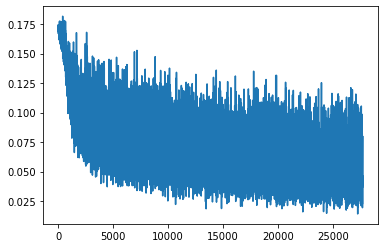

------
*********
29460 3431
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29460 461
Loss:  0.16951455175876617
Loss:  0.16208255290985107
Loss:  0.14904078841209412
0 **********
Epoch:  58.6701283454895  fold:  7  kers:  64
epoch:  1
29460 461
Loss:  0.1335020661354065
Loss:  0.1370077133178711
Loss:  0.10317380726337433
1 **********
Epoch:  105.04313588142395  fold:  7  kers:  64
epoch:  2
29460 461
Loss:  0.09013862907886505
Loss:  0.09504035115242004
Loss:  0.09355852752923965
2 **********
Epoch:  151.33436226844788  fold:  7  kers:  64
epoch:  3
Eval Loss:  0.6545333862304688
Eval Loss:  0.2114296704530716
Eval Loss:  1.7217671871185303
[[1610  517]
 [ 543  761]]
              precision    re

Loss:  0.07782480865716934
Loss:  0.05338394269347191
Loss:  0.08842752873897552
11 **********
Epoch:  686.6021649837494  fold:  7  kers:  64
epoch:  12
Eval Loss:  0.9040823578834534
Eval Loss:  0.03573606535792351
Eval Loss:  2.768890380859375
[[2083   44]
 [ 884  420]]
              precision    recall  f1-score   support

           0       0.70      0.98      0.82      2127
           1       0.91      0.32      0.48      1304

    accuracy                           0.73      3431
   macro avg       0.80      0.65      0.65      3431
weighted avg       0.78      0.73      0.69      3431

acc:  0.7295249198484407
pre:  0.9051724137931034
rec:  0.3220858895705521
ma F1:  0.6464690071008924
mi F1:  0.7295249198484407
we F1:  0.6875724443776405
Eval Loss:  0.43919819593429565
Eval Loss:  0.2699838876724243
Eval Loss:  0.34447604417800903
Eval Loss:  0.36925452947616577
Eval Loss:  0.27708324790000916
Eval Loss:  0.4779096245765686
Eval Loss:  0.4201166331768036
Eval Loss:  0.276750981

Eval Loss:  0.31836867332458496
Eval Loss:  0.20826391875743866
Eval Loss:  0.15007422864437103
Eval Loss:  0.20503060519695282
Eval Loss:  0.2562713027000427
Eval Loss:  0.3202592730522156
Eval Loss:  0.26968371868133545
Eval Loss:  0.1470925658941269
Eval Loss:  0.22014570236206055
Eval Loss:  0.20014160871505737
Eval Loss:  0.2006320059299469
Eval Loss:  0.18127994239330292
Eval Loss:  0.25964483618736267
Eval Loss:  0.22078156471252441
Eval Loss:  0.24210229516029358
Eval Loss:  0.29843220114707947
Eval Loss:  0.24278651177883148
Eval Loss:  0.3053027093410492
Eval Loss:  0.26549792289733887
Eval Loss:  0.3038182854652405
Eval Loss:  0.2293778955936432
Eval Loss:  0.24132540822029114
Eval Loss:  0.18165193498134613
Eval Loss:  0.23401735723018646
Eval Loss:  0.2001493275165558
Eval Loss:  0.25031840801239014
Eval Loss:  0.27674421668052673
Eval Loss:  0.23406697809696198
[[16453  1584]
 [ 1225 10198]]
              precision    recall  f1-score   support

           0       0.93   

Eval Loss:  0.1677425056695938
Eval Loss:  0.21023356914520264
Eval Loss:  0.17677611112594604
Eval Loss:  0.24427258968353271
Eval Loss:  0.284830778837204
Eval Loss:  0.22421443462371826
[[16563  1474]
 [ 1218 10205]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.92     18037
           1       0.87      0.89      0.88     11423

    accuracy                           0.91     29460
   macro avg       0.90      0.91      0.90     29460
weighted avg       0.91      0.91      0.91     29460

acc:  0.9086218601493551
pre:  0.8737905642606387
rec:  0.8933730193469316
ma F1:  0.9041577752190844
mi F1:  0.9086218601493551
we F1:  0.9088016031097436
29460 461
Loss:  0.05950253829360008
Loss:  0.09210433810949326
Loss:  0.05664406716823578
30 **********
Epoch:  1849.7601175308228  fold:  7  kers:  64
epoch:  31
29460 461
Loss:  0.03408012539148331
Loss:  0.07937490195035934
Loss:  0.08811833709478378
31 **********
Epoch:  1895.886783838272  f

Loss:  0.06075645610690117
Loss:  0.04795825853943825
Loss:  0.04213060811161995
39 **********
Epoch:  2384.8364317417145  fold:  7  kers:  64
epoch:  40
29460 461
Loss:  0.067262202501297
Loss:  0.04158344492316246
Loss:  0.025018809363245964
40 **********
Epoch:  2430.9810502529144  fold:  7  kers:  64
epoch:  41
29460 461
Loss:  0.0506473109126091
Loss:  0.04676968231797218
Loss:  0.05617499351501465
41 **********
Epoch:  2477.1286613941193  fold:  7  kers:  64
epoch:  42
Eval Loss:  0.47046610713005066
Eval Loss:  0.05635964497923851
Eval Loss:  1.8009138107299805
[[1942  185]
 [ 616  688]]
              precision    recall  f1-score   support

           0       0.76      0.91      0.83      2127
           1       0.79      0.53      0.63      1304

    accuracy                           0.77      3431
   macro avg       0.77      0.72      0.73      3431
weighted avg       0.77      0.77      0.75      3431

acc:  0.7665403672398717
pre:  0.7880870561282932
rec:  0.5276073619631

Eval Loss:  0.23035882413387299
Eval Loss:  0.1819102168083191
Eval Loss:  0.1490570306777954
Eval Loss:  0.22152630984783173
Eval Loss:  0.18845508992671967
Eval Loss:  0.347363144159317
Eval Loss:  0.22287024557590485
Eval Loss:  0.12446505576372147
Eval Loss:  0.17609356343746185
Eval Loss:  0.1613476425409317
Eval Loss:  0.17917697131633759
Eval Loss:  0.1811496764421463
Eval Loss:  0.24438495934009552
Eval Loss:  0.21297842264175415
Eval Loss:  0.19090773165225983
Eval Loss:  0.25939905643463135
Eval Loss:  0.18956679105758667
Eval Loss:  0.2534114718437195
Eval Loss:  0.17999067902565002
Eval Loss:  0.19805575907230377
Eval Loss:  0.1706259399652481
Eval Loss:  0.20379213988780975
Eval Loss:  0.13278549909591675
Eval Loss:  0.2380257397890091
Eval Loss:  0.11394429951906204
Eval Loss:  0.24741779267787933
Eval Loss:  0.2502197325229645
Eval Loss:  0.19059734046459198
[[17250   787]
 [ 1620  9803]]
              precision    recall  f1-score   support

           0       0.91     

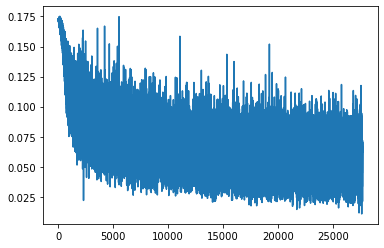

------
*********
29817 3074
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29817 466
Loss:  0.16753911972045898
Loss:  0.17048269510269165
Loss:  0.15664838254451752
0 **********
Epoch:  59.0391411781311  fold:  8  kers:  64
epoch:  1
29817 466
Loss:  0.1361137479543686
Loss:  0.12910319864749908
Loss:  0.12621955573558807
1 **********
Epoch:  105.89884829521179  fold:  8  kers:  64
epoch:  2
29817 466
Loss:  0.11976270377635956
Loss:  0.11647810786962509
Loss:  0.10955226421356201
2 **********
Epoch:  152.64785075187683  fold:  8  kers:  64
epoch:  3
Eval Loss:  0.2689191401004791
Eval Loss:  1.0577698945999146
Eval Loss:  0.24236778914928436
[[1839  234]
 [ 396  605]]
              precision    

Loss:  0.08743362128734589
Loss:  0.0932920053601265
10 **********
Epoch:  647.0309703350067  fold:  8  kers:  64
epoch:  11
29817 466
Loss:  0.07692914456129074
Loss:  0.09951178729534149
Loss:  0.11795330792665482
11 **********
Epoch:  693.7380847930908  fold:  8  kers:  64
epoch:  12
Eval Loss:  0.22873423993587494
Eval Loss:  1.539627194404602
Eval Loss:  0.10725206881761551
[[2006   67]
 [ 530  471]]
              precision    recall  f1-score   support

           0       0.79      0.97      0.87      2073
           1       0.88      0.47      0.61      1001

    accuracy                           0.81      3074
   macro avg       0.83      0.72      0.74      3074
weighted avg       0.82      0.81      0.79      3074

acc:  0.8057905009759271
pre:  0.8754646840148699
rec:  0.47052947052947053
ma F1:  0.7412782939726791
mi F1:  0.8057905009759271
we F1:  0.7863317701339051
Eval Loss:  0.29430779814720154
Eval Loss:  0.28948065638542175
Eval Loss:  0.4195237159729004
Eval Loss:  

Eval Loss:  0.24694640934467316
Eval Loss:  0.23115915060043335
Eval Loss:  0.31112244725227356
Eval Loss:  0.31071698665618896
Eval Loss:  0.22762706875801086
Eval Loss:  0.3053041994571686
Eval Loss:  0.37246572971343994
Eval Loss:  0.2681671380996704
Eval Loss:  0.30925795435905457
Eval Loss:  0.20521272718906403
Eval Loss:  0.16717886924743652
Eval Loss:  0.23752523958683014
Eval Loss:  0.2730357348918915
Eval Loss:  0.1791231483221054
Eval Loss:  0.28429582715034485
Eval Loss:  0.2301788479089737
Eval Loss:  0.21484260261058807
Eval Loss:  0.24911536276340485
Eval Loss:  0.22503358125686646
Eval Loss:  0.2421816736459732
Eval Loss:  0.3088226616382599
Eval Loss:  0.3116115629673004
Eval Loss:  0.23613382875919342
Eval Loss:  0.29661062359809875
Eval Loss:  0.3362765312194824
Eval Loss:  0.23726671934127808
Eval Loss:  0.27769309282302856
Eval Loss:  0.24844375252723694
Eval Loss:  0.16771996021270752
[[17068  1023]
 [ 2027  9699]]
              precision    recall  f1-score   supp

Eval Loss:  0.2681911587715149
Eval Loss:  0.21747121214866638
Eval Loss:  0.3267286419868469
Eval Loss:  0.3043312430381775
Eval Loss:  0.22801434993743896
Eval Loss:  0.28304415941238403
Eval Loss:  0.291792094707489
Eval Loss:  0.2564898729324341
Eval Loss:  0.25666284561157227
Eval Loss:  0.258669376373291
Eval Loss:  0.20026858150959015
[[17187   904]
 [ 2012  9714]]
              precision    recall  f1-score   support

           0       0.90      0.95      0.92     18091
           1       0.91      0.83      0.87     11726

    accuracy                           0.90     29817
   macro avg       0.91      0.89      0.90     29817
weighted avg       0.90      0.90      0.90     29817

acc:  0.9022034409900392
pre:  0.9148615558485591
rec:  0.8284154869520723
ma F1:  0.8956486291006219
mi F1:  0.9022034409900392
we F1:  0.9012315780737441
29817 466
Loss:  0.0603579618036747
Loss:  0.057631783187389374
Loss:  0.04792429134249687
30 **********
Epoch:  1865.1409919261932  fold:  8 

Loss:  0.03851437196135521
Loss:  0.05505647510290146
Loss:  0.06708227097988129
39 **********
Epoch:  2406.014805316925  fold:  8  kers:  64
epoch:  40
29817 466
Loss:  0.03807135671377182
Loss:  0.10217343270778656
Loss:  0.023000434041023254
40 **********
Epoch:  2452.5992476940155  fold:  8  kers:  64
epoch:  41
29817 466
Loss:  0.0620003379881382
Loss:  0.08073431998491287
Loss:  0.04552794620394707
41 **********
Epoch:  2499.1916692256927  fold:  8  kers:  64
epoch:  42
Eval Loss:  0.2663673460483551
Eval Loss:  1.0099650621414185
Eval Loss:  0.10728032886981964
[[1770  303]
 [ 258  743]]
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      2073
           1       0.71      0.74      0.73      1001

    accuracy                           0.82      3074
   macro avg       0.79      0.80      0.79      3074
weighted avg       0.82      0.82      0.82      3074

acc:  0.817501626545218
pre:  0.7103250478011472
rec:  0.74225774225774

Eval Loss:  0.19362139701843262
Eval Loss:  0.19579030573368073
Eval Loss:  0.21266573667526245
Eval Loss:  0.21522535383701324
Eval Loss:  0.1586395800113678
Eval Loss:  0.23903797566890717
Eval Loss:  0.29750218987464905
Eval Loss:  0.1902906596660614
Eval Loss:  0.24443712830543518
Eval Loss:  0.21134883165359497
Eval Loss:  0.1672361046075821
Eval Loss:  0.1741878092288971
Eval Loss:  0.21666038036346436
Eval Loss:  0.15976621210575104
Eval Loss:  0.23524142801761627
Eval Loss:  0.2073393613100052
Eval Loss:  0.19615952670574188
Eval Loss:  0.23343493044376373
Eval Loss:  0.22444550693035126
Eval Loss:  0.19923590123653412
Eval Loss:  0.2903844118118286
Eval Loss:  0.24553346633911133
Eval Loss:  0.15371805429458618
Eval Loss:  0.19744691252708435
Eval Loss:  0.2563992142677307
Eval Loss:  0.24590928852558136
Eval Loss:  0.20902767777442932
Eval Loss:  0.21109601855278015
Eval Loss:  0.19305962324142456
[[17334   757]
 [ 1678 10048]]
              precision    recall  f1-score   su

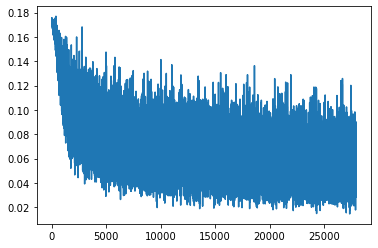

------
*********
29483 3408
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29483 461
Loss:  0.1683669537305832
Loss:  0.15711364150047302
Loss:  0.15906424820423126
0 **********
Epoch:  58.66015410423279  fold:  9  kers:  64
epoch:  1
29483 461
Loss:  0.14459559321403503
Loss:  0.13168421387672424
Loss:  0.14317627251148224
1 **********
Epoch:  104.9344265460968  fold:  9  kers:  64
epoch:  2
29483 461
Loss:  0.12678834795951843
Loss:  0.1253966987133026
Loss:  0.10336471349000931
2 **********
Epoch:  151.11295413970947  fold:  9  kers:  64
epoch:  3
Eval Loss:  0.2324240654706955
Eval Loss:  1.019953727722168
Eval Loss:  0.3485068678855896
[[1524  218]
 [ 432 1234]]
              precision    rec

Loss:  0.0755285993218422
11 **********
Epoch:  685.2717220783234  fold:  9  kers:  64
epoch:  12
Eval Loss:  0.06867527961730957
Eval Loss:  1.3732303380966187
Eval Loss:  0.19550371170043945
[[1633  109]
 [ 484 1182]]
              precision    recall  f1-score   support

           0       0.77      0.94      0.85      1742
           1       0.92      0.71      0.80      1666

    accuracy                           0.83      3408
   macro avg       0.84      0.82      0.82      3408
weighted avg       0.84      0.83      0.82      3408

acc:  0.8259976525821596
pre:  0.9155693261037955
rec:  0.709483793517407
ma F1:  0.8228960790068374
mi F1:  0.8259976525821596
we F1:  0.8234187388554505
update!  Acc:  0.8259976525821596
Eval Loss:  0.3280686140060425
Eval Loss:  0.3336132764816284
Eval Loss:  0.30804282426834106
Eval Loss:  0.3176891803741455
Eval Loss:  0.3040211796760559
Eval Loss:  0.23530271649360657
Eval Loss:  0.3398672938346863
Eval Loss:  0.3814864456653595
Eval Loss:  0.

Eval Loss:  0.32925257086753845
Eval Loss:  0.2897546887397766
Eval Loss:  0.2956920266151428
Eval Loss:  0.28470319509506226
Eval Loss:  0.25186559557914734
Eval Loss:  0.1887015700340271
Eval Loss:  0.3096809685230255
Eval Loss:  0.3156905770301819
Eval Loss:  0.2476394772529602
Eval Loss:  0.26949840784072876
Eval Loss:  0.25443118810653687
Eval Loss:  0.32515907287597656
Eval Loss:  0.24221624433994293
Eval Loss:  0.2469744235277176
Eval Loss:  0.2976900041103363
Eval Loss:  0.2574928104877472
Eval Loss:  0.2254287302494049
Eval Loss:  0.26335206627845764
Eval Loss:  0.300115704536438
Eval Loss:  0.28233808279037476
Eval Loss:  0.3136990964412689
Eval Loss:  0.1963334083557129
Eval Loss:  0.22188997268676758
Eval Loss:  0.2512705326080322
Eval Loss:  0.2414959967136383
Eval Loss:  0.3341839909553528
Eval Loss:  0.22815503180027008
Eval Loss:  0.19726146757602692
[[17293  1129]
 [ 1980  9081]]
              precision    recall  f1-score   support

           0       0.90      0.94  

Eval Loss:  0.196876659989357
Eval Loss:  0.20328202843666077
Eval Loss:  0.2531474232673645
Eval Loss:  0.26247620582580566
Eval Loss:  0.23016898334026337
Eval Loss:  0.20025625824928284
[[16960  1462]
 [ 1428  9633]]
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     18422
           1       0.87      0.87      0.87     11061

    accuracy                           0.90     29483
   macro avg       0.90      0.90      0.90     29483
weighted avg       0.90      0.90      0.90     29483

acc:  0.9019774107112574
pre:  0.8682289319513294
rec:  0.8708977488473013
ma F1:  0.8955250092709035
mi F1:  0.9019774107112574
we F1:  0.9020073522492635
29483 461
Loss:  0.05588905140757561
Loss:  0.06717289239168167
Loss:  0.06411962956190109
30 **********
Epoch:  1840.641497850418  fold:  9  kers:  64
epoch:  31
29483 461
Loss:  0.09238483756780624
Loss:  0.08163879066705704
Loss:  0.058333270251750946
31 **********
Epoch:  1886.8629112243652  

Loss:  0.056525085121393204
Loss:  0.06084674224257469
Loss:  0.043785460293293
39 **********
Epoch:  2378.609719991684  fold:  9  kers:  64
epoch:  40
29483 461
Loss:  0.050398651510477066
Loss:  0.059556446969509125
Loss:  0.054594505578279495
40 **********
Epoch:  2424.8411061763763  fold:  9  kers:  64
epoch:  41
29483 461
Loss:  0.055235475301742554
Loss:  0.04203944653272629
Loss:  0.05845721438527107
41 **********
Epoch:  2470.9179062843323  fold:  9  kers:  64
epoch:  42
Eval Loss:  0.04296527057886124
Eval Loss:  0.6736876964569092
Eval Loss:  0.18146544694900513
[[1645   97]
 [ 387 1279]]
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      1742
           1       0.93      0.77      0.84      1666

    accuracy                           0.86      3408
   macro avg       0.87      0.86      0.86      3408
weighted avg       0.87      0.86      0.86      3408

acc:  0.857981220657277
pre:  0.9295058139534884
rec:  0.7677070828

Eval Loss:  0.2635391652584076
Eval Loss:  0.2599422335624695
Eval Loss:  0.2605604827404022
Eval Loss:  0.17395815253257751
Eval Loss:  0.22313830256462097
Eval Loss:  0.12364669144153595
Eval Loss:  0.23156464099884033
Eval Loss:  0.23742759227752686
Eval Loss:  0.23826676607131958
Eval Loss:  0.18514153361320496
Eval Loss:  0.20709756016731262
Eval Loss:  0.27676430344581604
Eval Loss:  0.19522877037525177
Eval Loss:  0.17258161306381226
Eval Loss:  0.2595506012439728
Eval Loss:  0.18254271149635315
Eval Loss:  0.19960711896419525
Eval Loss:  0.20003819465637207
Eval Loss:  0.17423246800899506
Eval Loss:  0.2007017731666565
Eval Loss:  0.26939576864242554
Eval Loss:  0.1710205376148224
Eval Loss:  0.16343079507350922
Eval Loss:  0.16663478314876556
Eval Loss:  0.2090035080909729
Eval Loss:  0.22882241010665894
Eval Loss:  0.20825845003128052
Eval Loss:  0.17954248189926147
[[17133  1289]
 [ 1096  9965]]
              precision    recall  f1-score   support

           0       0.94  

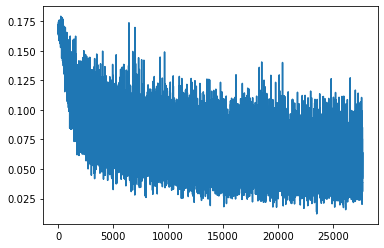

------
*********
29871 3020
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29871 467
Loss:  0.16691268980503082
Loss:  0.16852331161499023
Loss:  0.16503284871578217
0 **********
Epoch:  59.25057554244995  fold:  10  kers:  64
epoch:  1
29871 467
Loss:  0.13754843175411224
Loss:  0.1566823571920395
Loss:  0.14102160930633545
1 **********
Epoch:  106.26686358451843  fold:  10  kers:  64
epoch:  2
29871 467
Loss:  0.09890947490930557
Loss:  0.12081484496593475
Loss:  0.12292919307947159
2 **********
Epoch:  153.1774342060089  fold:  10  kers:  64
epoch:  3
Eval Loss:  0.3779889643192291
Eval Loss:  0.37529823184013367
Eval Loss:  0.17370852828025818
[[1481  270]
 [ 130 1139]]
              precision

10 **********
Epoch:  649.1104099750519  fold:  10  kers:  64
epoch:  11
29871 467
Loss:  0.08777517825365067
Loss:  0.07030722498893738
Loss:  0.0614631250500679
11 **********
Epoch:  696.0269649028778  fold:  10  kers:  64
epoch:  12
Eval Loss:  0.6174484491348267
Eval Loss:  0.09045177698135376
Eval Loss:  0.06092023849487305
[[1684   67]
 [ 298  971]]
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1751
           1       0.94      0.77      0.84      1269

    accuracy                           0.88      3020
   macro avg       0.89      0.86      0.87      3020
weighted avg       0.89      0.88      0.88      3020

acc:  0.8791390728476821
pre:  0.9354527938342967
rec:  0.7651694247438928
ma F1:  0.8720046409493881
mi F1:  0.8791390728476821
we F1:  0.8768276369872251
Eval Loss:  0.34481507539749146
Eval Loss:  0.3148517906665802
Eval Loss:  0.356751024723053
Eval Loss:  0.27117881178855896
Eval Loss:  0.40968602895736694
Ev

Eval Loss:  0.22909697890281677
Eval Loss:  0.2125735729932785
Eval Loss:  0.23821786046028137
Eval Loss:  0.18380676209926605
Eval Loss:  0.32941877841949463
Eval Loss:  0.23405486345291138
Eval Loss:  0.2583298981189728
Eval Loss:  0.2279367744922638
Eval Loss:  0.26683276891708374
Eval Loss:  0.2874070405960083
Eval Loss:  0.18943607807159424
Eval Loss:  0.34646204113960266
Eval Loss:  0.17124822735786438
Eval Loss:  0.2077566534280777
Eval Loss:  0.36053645610809326
Eval Loss:  0.3550398349761963
Eval Loss:  0.2833315432071686
Eval Loss:  0.33137038350105286
Eval Loss:  0.22173991799354553
Eval Loss:  0.2380138784646988
Eval Loss:  0.21260838210582733
Eval Loss:  0.24384747445583344
Eval Loss:  0.28214383125305176
Eval Loss:  0.32828372716903687
Eval Loss:  0.21474072337150574
Eval Loss:  0.22328335046768188
Eval Loss:  0.19555337727069855
Eval Loss:  0.3121728301048279
Eval Loss:  0.2964650094509125
[[17485   928]
 [ 2191  9267]]
              precision    recall  f1-score   suppo

Eval Loss:  0.2232331484556198
Eval Loss:  0.1808539628982544
Eval Loss:  0.25418156385421753
Eval Loss:  0.2764758765697479
Eval Loss:  0.32663053274154663
Eval Loss:  0.1709911823272705
Eval Loss:  0.17766018211841583
Eval Loss:  0.19732621312141418
Eval Loss:  0.3070557415485382
Eval Loss:  0.29523611068725586
[[17369  1044]
 [ 1836  9622]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     18413
           1       0.90      0.84      0.87     11458

    accuracy                           0.90     29871
   macro avg       0.90      0.89      0.90     29871
weighted avg       0.90      0.90      0.90     29871

acc:  0.9035854172943658
pre:  0.9021188824301519
rec:  0.8397626112759644
ma F1:  0.8966327653955402
mi F1:  0.9035854172943658
we F1:  0.9028746259811
29871 467
Loss:  0.06727205216884613
Loss:  0.08676587045192719
Loss:  0.059970371425151825
30 **********
Epoch:  1869.0146346092224  fold:  10  kers:  64
epoch:  31
29871 46

Loss:  0.044457271695137024
Loss:  0.0647883415222168
Loss:  0.05562061071395874
39 **********
Epoch:  2409.7597913742065  fold:  10  kers:  64
epoch:  40
29871 467
Loss:  0.0703054890036583
Loss:  0.06562768667936325
Loss:  0.043166689574718475
40 **********
Epoch:  2456.5367193222046  fold:  10  kers:  64
epoch:  41
29871 467
Loss:  0.033472079783678055
Loss:  0.06314123421907425
Loss:  0.07877983152866364
41 **********
Epoch:  2503.434324979782  fold:  10  kers:  64
epoch:  42
Eval Loss:  0.7869558334350586
Eval Loss:  0.08995693922042847
Eval Loss:  0.010549227707087994
[[1679   72]
 [ 307  962]]
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1751
           1       0.93      0.76      0.84      1269

    accuracy                           0.87      3020
   macro avg       0.89      0.86      0.87      3020
weighted avg       0.88      0.87      0.87      3020

acc:  0.8745033112582782
pre:  0.9303675048355899
rec:  0.7580772

Eval Loss:  0.19548572599887848
Eval Loss:  0.21576103568077087
Eval Loss:  0.2823399603366852
Eval Loss:  0.17035163938999176
Eval Loss:  0.2625579535961151
Eval Loss:  0.23008394241333008
Eval Loss:  0.2113974392414093
Eval Loss:  0.21546857059001923
Eval Loss:  0.24708907306194305
Eval Loss:  0.25767019391059875
Eval Loss:  0.14296425879001617
Eval Loss:  0.3126859962940216
Eval Loss:  0.11365059018135071
Eval Loss:  0.18157252669334412
Eval Loss:  0.3166433274745941
Eval Loss:  0.3203583359718323
Eval Loss:  0.255505234003067
Eval Loss:  0.29803773760795593
Eval Loss:  0.2426605522632599
Eval Loss:  0.15973995625972748
Eval Loss:  0.15003390610218048
Eval Loss:  0.2410503476858139
Eval Loss:  0.29525256156921387
Eval Loss:  0.256791889667511
Eval Loss:  0.13892683386802673
Eval Loss:  0.16463494300842285
Eval Loss:  0.17785760760307312
Eval Loss:  0.2593272626399994
Eval Loss:  0.23375551402568817
[[17428   985]
 [ 1515  9943]]
              precision    recall  f1-score   support


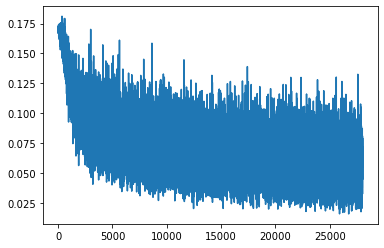

------
  
kernel: 32
  
*********
29459 3432
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29459 461
Loss:  0.16888916492462158
Loss:  0.1631631702184677
Loss:  0.15524300932884216
0 **********
Epoch:  53.65254354476929  fold:  1  kers:  32
epoch:  1
29459 461
Loss:  0.16406859457492828
Loss:  0.12794677913188934
Loss:  0.17403219640254974
1 **********
Epoch:  95.10171675682068  fold:  1  kers:  32
epoch:  2
29459 461
Loss:  0.10998481512069702
Loss:  0.09889017790555954
Loss:  0.12096758186817169
2 **********
Epoch:  136.4322075843811  fold:  1  kers:  32
epoch:  3
Eval Loss:  0.38574936985969543
Eval Loss:  0.5305024981498718
Eval Loss:  0.26517727971076965
[[ 790  249]
 [ 621 1772]]
          

Loss:  0.0661291629076004
Loss:  0.12098350375890732
11 **********
Epoch:  625.415765285492  fold:  1  kers:  32
epoch:  12
Eval Loss:  0.5431379079818726
Eval Loss:  0.6056039333343506
Eval Loss:  0.10961399227380753
[[ 879  160]
 [ 736 1657]]
              precision    recall  f1-score   support

           0       0.54      0.85      0.66      1039
           1       0.91      0.69      0.79      2393

    accuracy                           0.74      3432
   macro avg       0.73      0.77      0.72      3432
weighted avg       0.80      0.74      0.75      3432

acc:  0.7389277389277389
pre:  0.9119427627958173
rec:  0.6924362724613455
ma F1:  0.7247848897464859
mi F1:  0.738927738927739
we F1:  0.7493985372932941
Eval Loss:  0.38933447003364563
Eval Loss:  0.3083855211734772
Eval Loss:  0.2514030337333679
Eval Loss:  0.3713875412940979
Eval Loss:  0.30022647976875305
Eval Loss:  0.38611871004104614
Eval Loss:  0.3502621650695801
Eval Loss:  0.33332815766334534
Eval Loss:  0.3191203

Eval Loss:  0.3760507106781006
Eval Loss:  0.297394722700119
Eval Loss:  0.21832089126110077
Eval Loss:  0.33867427706718445
Eval Loss:  0.26875510811805725
Eval Loss:  0.3632810413837433
Eval Loss:  0.31356653571128845
Eval Loss:  0.3129763901233673
Eval Loss:  0.2513965666294098
Eval Loss:  0.34970253705978394
Eval Loss:  0.2532345652580261
Eval Loss:  0.3057517111301422
Eval Loss:  0.37003931403160095
Eval Loss:  0.32469043135643005
Eval Loss:  0.17161668837070465
Eval Loss:  0.41932836174964905
Eval Loss:  0.316793829202652
Eval Loss:  0.33050552010536194
Eval Loss:  0.399507999420166
Eval Loss:  0.37513870000839233
Eval Loss:  0.30118101835250854
Eval Loss:  0.3261043131351471
Eval Loss:  0.2652098536491394
Eval Loss:  0.25217726826667786
Eval Loss:  0.3129238486289978
Eval Loss:  0.3698321580886841
Eval Loss:  0.2835485339164734
Eval Loss:  0.3203723728656769
[[18324   801]
 [ 2884  7450]]
              precision    recall  f1-score   support

           0       0.86      0.96   

Eval Loss:  0.2793484628200531
Eval Loss:  0.35404297709465027
Eval Loss:  0.251167893409729
Eval Loss:  0.3189544081687927
[[18366   759]
 [ 2684  7650]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     19125
           1       0.91      0.74      0.82     10334

    accuracy                           0.88     29459
   macro avg       0.89      0.85      0.87     29459
weighted avg       0.89      0.88      0.88     29459

acc:  0.8831257001255983
pre:  0.9097395647520514
rec:  0.7402748209792916
ma F1:  0.8653023457734945
mi F1:  0.8831257001255983
we F1:  0.8799239497403987
29459 461
Loss:  0.051721975207328796
Loss:  0.057479556649923325
Loss:  0.08728871494531631
30 **********
Epoch:  1689.470698595047  fold:  1  kers:  32
epoch:  31
29459 461
Loss:  0.052650101482868195
Loss:  0.09732477366924286
Loss:  0.08255162090063095
31 **********
Epoch:  1730.6336369514465  fold:  1  kers:  32
epoch:  32
29459 461
Loss:  0.0883631929755

39 **********
Epoch:  2183.9894559383392  fold:  1  kers:  32
epoch:  40
29459 461
Loss:  0.08279301971197128
Loss:  0.07180146127939224
Loss:  0.0759023055434227
40 **********
Epoch:  2225.1972744464874  fold:  1  kers:  32
epoch:  41
29459 461
Loss:  0.06484287977218628
Loss:  0.09830949455499649
Loss:  0.05778810754418373
41 **********
Epoch:  2266.451967716217  fold:  1  kers:  32
epoch:  42
Eval Loss:  1.0934982299804688
Eval Loss:  0.3943730890750885
Eval Loss:  0.0843258872628212
[[ 786  253]
 [ 501 1892]]
              precision    recall  f1-score   support

           0       0.61      0.76      0.68      1039
           1       0.88      0.79      0.83      2393

    accuracy                           0.78      3432
   macro avg       0.75      0.77      0.75      3432
weighted avg       0.80      0.78      0.79      3432

acc:  0.7803030303030303
pre:  0.882051282051282
rec:  0.790639364814041
ma F1:  0.7548429295067125
mi F1:  0.7803030303030304
we F1:  0.7860119859969604


Eval Loss:  0.2999522387981415
Eval Loss:  0.26653480529785156
Eval Loss:  0.22912287712097168
Eval Loss:  0.2462732046842575
Eval Loss:  0.2194596827030182
Eval Loss:  0.3289782404899597
Eval Loss:  0.29457908868789673
Eval Loss:  0.1907748430967331
Eval Loss:  0.21482323110103607
Eval Loss:  0.2625410854816437
Eval Loss:  0.20609663426876068
Eval Loss:  0.2609752118587494
Eval Loss:  0.37658748030662537
Eval Loss:  0.2581849694252014
Eval Loss:  0.15123684704303741
Eval Loss:  0.3915177285671234
Eval Loss:  0.18718750774860382
Eval Loss:  0.3511122763156891
Eval Loss:  0.2932293117046356
Eval Loss:  0.2571936547756195
Eval Loss:  0.19204828143119812
Eval Loss:  0.31177836656570435
Eval Loss:  0.2552923858165741
Eval Loss:  0.23221763968467712
Eval Loss:  0.2183927744626999
Eval Loss:  0.3090292513370514
Eval Loss:  0.2393968105316162
Eval Loss:  0.24290531873703003
[[18185   940]
 [ 1895  8439]]
              precision    recall  f1-score   support

           0       0.91      0.95 

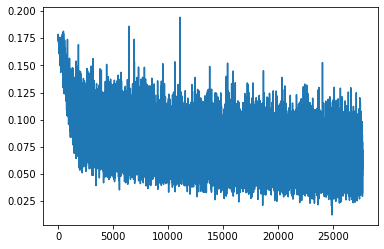

------
*********
29797 3094
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29797 466
Loss:  0.16780012845993042
Loss:  0.16621814668178558
Loss:  0.16050569713115692
0 **********
Epoch:  54.23199439048767  fold:  2  kers:  32
epoch:  1
29797 466
Loss:  0.13921968638896942
Loss:  0.14302383363246918
Loss:  0.12654513120651245
1 **********
Epoch:  96.19579243659973  fold:  2  kers:  32
epoch:  2
29797 466
Loss:  0.11403615772724152
Loss:  0.10887525230646133
Loss:  0.10047423839569092
2 **********
Epoch:  138.08279490470886  fold:  2  kers:  32
epoch:  3
Eval Loss:  0.8752854466438293
Eval Loss:  0.2906520366668701
Eval Loss:  0.5589473247528076
[[1066  364]
 [ 489 1175]]
              precision    

Loss:  0.058786820620298386
Loss:  0.06862811744213104
10 **********
Epoch:  590.3993918895721  fold:  2  kers:  32
epoch:  11
29797 466
Loss:  0.08652985095977783
Loss:  0.08098133653402328
Loss:  0.06546799093484879
11 **********
Epoch:  632.1976320743561  fold:  2  kers:  32
epoch:  12
Eval Loss:  0.9280005097389221
Eval Loss:  0.26545450091362
Eval Loss:  0.5686084628105164
[[1257  173]
 [ 664 1000]]
              precision    recall  f1-score   support

           0       0.65      0.88      0.75      1430
           1       0.85      0.60      0.70      1664

    accuracy                           0.73      3094
   macro avg       0.75      0.74      0.73      3094
weighted avg       0.76      0.73      0.73      3094

acc:  0.7294764059469941
pre:  0.8525149190110827
rec:  0.6009615384615384
ma F1:  0.7275969262801407
mi F1:  0.7294764059469941
we F1:  0.7258856490737449
Eval Loss:  0.3363189399242401
Eval Loss:  0.37013497948646545
Eval Loss:  0.3070741891860962
Eval Loss:  0.2

Eval Loss:  0.28213995695114136
Eval Loss:  0.32784005999565125
Eval Loss:  0.24980321526527405
Eval Loss:  0.18154308199882507
Eval Loss:  0.30656492710113525
Eval Loss:  0.3060915172100067
Eval Loss:  0.41567206382751465
Eval Loss:  0.2831990718841553
Eval Loss:  0.21537676453590393
Eval Loss:  0.19863981008529663
Eval Loss:  0.20987568795681
Eval Loss:  0.22626669704914093
Eval Loss:  0.343146413564682
Eval Loss:  0.3513580858707428
Eval Loss:  0.24589881300926208
Eval Loss:  0.30316850543022156
Eval Loss:  0.20892123878002167
Eval Loss:  0.28214144706726074
Eval Loss:  0.23946577310562134
Eval Loss:  0.1696806252002716
Eval Loss:  0.20710305869579315
Eval Loss:  0.26649999618530273
Eval Loss:  0.3484063744544983
Eval Loss:  0.22685179114341736
Eval Loss:  0.28291234374046326
Eval Loss:  0.32299289107322693
Eval Loss:  0.298893004655838
Eval Loss:  0.23309387266635895
Eval Loss:  0.3152591586112976
[[17829   905]
 [ 2300  8763]]
              precision    recall  f1-score   support


Eval Loss:  0.27266576886177063
Eval Loss:  0.33822986483573914
Eval Loss:  0.17834517359733582
Eval Loss:  0.2544955313205719
Eval Loss:  0.2602953016757965
Eval Loss:  0.2604372501373291
Eval Loss:  0.22267207503318787
Eval Loss:  0.2668401896953583
[[17880   854]
 [ 2038  9025]]
              precision    recall  f1-score   support

           0       0.90      0.95      0.93     18734
           1       0.91      0.82      0.86     11063

    accuracy                           0.90     29797
   macro avg       0.91      0.89      0.89     29797
weighted avg       0.90      0.90      0.90     29797

acc:  0.9029432493204014
pre:  0.9135540034416438
rec:  0.815782337521468
ma F1:  0.8935414115614062
mi F1:  0.9029432493204014
we F1:  0.9016861317702433
29797 466
Loss:  0.08159134536981583
Loss:  0.04771272838115692
Loss:  0.058190058916807175
30 **********
Epoch:  1702.8279838562012  fold:  2  kers:  32
epoch:  31
29797 466
Loss:  0.06676841527223587
Loss:  0.059405338019132614
Loss:

Loss:  0.06423918157815933
Loss:  0.0563604012131691
Loss:  0.07463410496711731
39 **********
Epoch:  2196.329461336136  fold:  2  kers:  32
epoch:  40
29797 466
Loss:  0.0480244904756546
Loss:  0.059457261115312576
Loss:  0.07958855479955673
40 **********
Epoch:  2238.117727994919  fold:  2  kers:  32
epoch:  41
29797 466
Loss:  0.06707935035228729
Loss:  0.08210781216621399
Loss:  0.044755034148693085
41 **********
Epoch:  2279.85413312912  fold:  2  kers:  32
epoch:  42
Eval Loss:  0.5471214652061462
Eval Loss:  0.2170039266347885
Eval Loss:  0.8154953718185425
[[1232  198]
 [ 587 1077]]
              precision    recall  f1-score   support

           0       0.68      0.86      0.76      1430
           1       0.84      0.65      0.73      1664

    accuracy                           0.75      3094
   macro avg       0.76      0.75      0.75      3094
weighted avg       0.77      0.75      0.74      3094

acc:  0.7462831286360698
pre:  0.8447058823529412
rec:  0.6472355769230769


Eval Loss:  0.2962251901626587
Eval Loss:  0.2739062011241913
Eval Loss:  0.22992680966854095
Eval Loss:  0.1558467149734497
Eval Loss:  0.2575419545173645
Eval Loss:  0.21384580433368683
Eval Loss:  0.32079195976257324
Eval Loss:  0.25265663862228394
Eval Loss:  0.19805186986923218
Eval Loss:  0.17074595391750336
Eval Loss:  0.13005276024341583
Eval Loss:  0.2385290414094925
Eval Loss:  0.3127734661102295
Eval Loss:  0.3629400432109833
Eval Loss:  0.25430530309677124
Eval Loss:  0.30678021907806396
Eval Loss:  0.20735390484333038
Eval Loss:  0.26614072918891907
Eval Loss:  0.21234305202960968
Eval Loss:  0.16430702805519104
Eval Loss:  0.19963164627552032
Eval Loss:  0.2645293176174164
Eval Loss:  0.4029664695262909
Eval Loss:  0.18843665719032288
Eval Loss:  0.2359585016965866
Eval Loss:  0.2418816089630127
Eval Loss:  0.2246345579624176
Eval Loss:  0.23466856777668
Eval Loss:  0.274077445268631
[[18124   610]
 [ 2186  8877]]
              precision    recall  f1-score   support

   

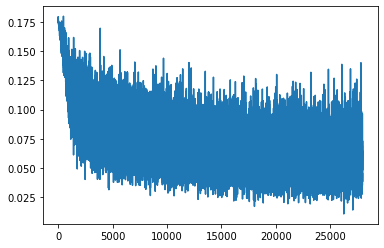

------
*********
29460 3431
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29460 461
Loss:  0.16904552280902863
Loss:  0.1678466647863388
Loss:  0.16154809296131134
0 **********
Epoch:  53.648555517196655  fold:  3  kers:  32
epoch:  1
29460 461
Loss:  0.15176954865455627
Loss:  0.13773959875106812
Loss:  0.11924781650304794
1 **********
Epoch:  95.00298142433167  fold:  3  kers:  32
epoch:  2
29460 461
Loss:  0.13498981297016144
Loss:  0.11560997366905212
Loss:  0.09939704090356827
2 **********
Epoch:  136.3374617099762  fold:  3  kers:  32
epoch:  3
Eval Loss:  0.6072984337806702
Eval Loss:  0.6111474633216858
Eval Loss:  0.3992127478122711
[[1127  409]
 [ 337 1558]]
              precision    r

Loss:  0.06195200979709625
Loss:  0.11600379645824432
11 **********
Epoch:  627.1062457561493  fold:  3  kers:  32
epoch:  12
Eval Loss:  0.6819725036621094
Eval Loss:  0.3935692608356476
Eval Loss:  0.643991231918335
[[1318  218]
 [ 551 1344]]
              precision    recall  f1-score   support

           0       0.71      0.86      0.77      1536
           1       0.86      0.71      0.78      1895

    accuracy                           0.78      3431
   macro avg       0.78      0.78      0.78      3431
weighted avg       0.79      0.78      0.78      3431

acc:  0.7758670941416497
pre:  0.8604353393085787
rec:  0.7092348284960422
ma F1:  0.7758542224442352
mi F1:  0.7758670941416497
we F1:  0.7760319508816121
Eval Loss:  0.2592524588108063
Eval Loss:  0.3034704625606537
Eval Loss:  0.3143666982650757
Eval Loss:  0.3546384871006012
Eval Loss:  0.36798423528671265
Eval Loss:  0.3513020873069763
Eval Loss:  0.17360690236091614
Eval Loss:  0.3995211124420166
Eval Loss:  0.18714211

Eval Loss:  0.26553091406822205
Eval Loss:  0.28015536069869995
Eval Loss:  0.3100005090236664
Eval Loss:  0.34773606061935425
Eval Loss:  0.32195523381233215
Eval Loss:  0.13851667940616608
Eval Loss:  0.35875001549720764
Eval Loss:  0.15209926664829254
Eval Loss:  0.3279167711734772
Eval Loss:  0.26459288597106934
Eval Loss:  0.27609366178512573
Eval Loss:  0.2938447594642639
Eval Loss:  0.25143370032310486
Eval Loss:  0.29933232069015503
Eval Loss:  0.2964143753051758
Eval Loss:  0.26578059792518616
Eval Loss:  0.31424933671951294
Eval Loss:  0.37760505080223083
Eval Loss:  0.29563358426094055
Eval Loss:  0.28229373693466187
Eval Loss:  0.2869720757007599
Eval Loss:  0.3251742422580719
Eval Loss:  0.24650906026363373
Eval Loss:  0.2852979898452759
Eval Loss:  0.1779453605413437
Eval Loss:  0.2945995628833771
Eval Loss:  0.4143313467502594
[[17269  1359]
 [ 1991  8841]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.91     18628
      

Eval Loss:  0.32465580105781555
Eval Loss:  0.18087412416934967
Eval Loss:  0.32313796877861023
Eval Loss:  0.4299989640712738
[[17892   736]
 [ 2669  8163]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     18628
           1       0.92      0.75      0.83     10832

    accuracy                           0.88     29460
   macro avg       0.89      0.86      0.87     29460
weighted avg       0.89      0.88      0.88     29460

acc:  0.8844195519348269
pre:  0.9172940779862906
rec:  0.7536004431314623
ma F1:  0.8702711463053907
mi F1:  0.8844195519348269
we F1:  0.8816084852186484
29460 461
Loss:  0.050472185015678406
Loss:  0.0492902509868145
Loss:  0.10286328941583633
30 **********
Epoch:  1686.7170615196228  fold:  3  kers:  32
epoch:  31
29460 461
Loss:  0.05410153046250343
Loss:  0.06721286475658417
Loss:  0.06773002445697784
31 **********
Epoch:  1728.0605175495148  fold:  3  kers:  32
epoch:  32
29460 461
Loss:  0.117714270949

Loss:  0.05368327349424362
Loss:  0.06060541793704033
Loss:  0.07841479778289795
40 **********
Epoch:  2216.534437417984  fold:  3  kers:  32
epoch:  41
29460 461
Loss:  0.053685955703258514
Loss:  0.0546320341527462
Loss:  0.0768289864063263
41 **********
Epoch:  2257.723307132721  fold:  3  kers:  32
epoch:  42
Eval Loss:  0.3932299017906189
Eval Loss:  0.14887186884880066
Eval Loss:  1.3060412406921387
[[1222  314]
 [ 527 1368]]
              precision    recall  f1-score   support

           0       0.70      0.80      0.74      1536
           1       0.81      0.72      0.76      1895

    accuracy                           0.75      3431
   macro avg       0.76      0.76      0.75      3431
weighted avg       0.76      0.75      0.76      3431

acc:  0.7548819586126494
pre:  0.8133174791914387
rec:  0.7218997361477573
ma F1:  0.7544373000341689
mi F1:  0.7548819586126494
we F1:  0.7555306728401585
Eval Loss:  0.1971152126789093
Eval Loss:  0.18170024454593658
Eval Loss:  0.2746

Eval Loss:  0.16939370334148407
Eval Loss:  0.16333161294460297
Eval Loss:  0.2800101041793823
Eval Loss:  0.2697129547595978
Eval Loss:  0.3317655920982361
Eval Loss:  0.24790097773075104
Eval Loss:  0.11411910504102707
Eval Loss:  0.3239801824092865
Eval Loss:  0.12962403893470764
Eval Loss:  0.22934985160827637
Eval Loss:  0.23980437219142914
Eval Loss:  0.19987665116786957
Eval Loss:  0.22768069803714752
Eval Loss:  0.21439775824546814
Eval Loss:  0.20355090498924255
Eval Loss:  0.2515035569667816
Eval Loss:  0.23696237802505493
Eval Loss:  0.21930387616157532
Eval Loss:  0.2750624418258667
Eval Loss:  0.2233630269765854
Eval Loss:  0.23612689971923828
Eval Loss:  0.25104182958602905
Eval Loss:  0.25736841559410095
Eval Loss:  0.22433613240718842
Eval Loss:  0.21072779595851898
Eval Loss:  0.16228508949279785
Eval Loss:  0.2736198604106903
Eval Loss:  0.32562679052352905
[[17522  1106]
 [ 1600  9232]]
              precision    recall  f1-score   support

           0       0.92   

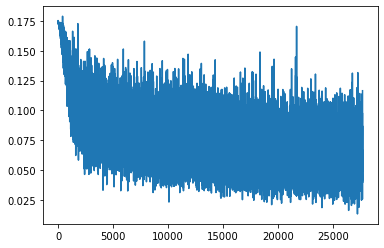

------
*********
29520 3371
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29520 462
Loss:  0.17105409502983093
Loss:  0.16800877451896667
Loss:  0.1615012139081955
0 **********
Epoch:  53.84403133392334  fold:  4  kers:  32
epoch:  1
29520 462
Loss:  0.15815486013889313
Loss:  0.13305622339248657
Loss:  0.1341150552034378
1 **********
Epoch:  95.41089010238647  fold:  4  kers:  32
epoch:  2
29520 462
Loss:  0.1281859427690506
Loss:  0.14745904505252838
Loss:  0.10709347575902939
2 **********
Epoch:  136.9498233795166  fold:  4  kers:  32
epoch:  3
Eval Loss:  0.4875001311302185
Eval Loss:  0.4362165927886963
Eval Loss:  0.11744699627161026
[[2638  499]
 [ 130  104]]
              precision    rec

Loss:  0.11845779418945312
Loss:  0.08825506269931793
Loss:  0.10292281210422516
11 **********
Epoch:  626.5367674827576  fold:  4  kers:  32
epoch:  12
Eval Loss:  0.08541650325059891
Eval Loss:  0.12327109277248383
Eval Loss:  0.057266585528850555
[[3056   81]
 [ 199   35]]
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      3137
           1       0.30      0.15      0.20       234

    accuracy                           0.92      3371
   macro avg       0.62      0.56      0.58      3371
weighted avg       0.89      0.92      0.90      3371

acc:  0.9169385938890537
pre:  0.3017241379310345
rec:  0.14957264957264957
ma F1:  0.5780976220275345
mi F1:  0.9169385938890537
we F1:  0.9037034946902257
Eval Loss:  0.3009827435016632
Eval Loss:  0.37869900465011597
Eval Loss:  0.32237523794174194
Eval Loss:  0.3899585008621216
Eval Loss:  0.44665443897247314
Eval Loss:  0.3082095682621002
Eval Loss:  0.3372248411178589
Eval Loss:  0.39191

Eval Loss:  0.3085287809371948
Eval Loss:  0.366730272769928
Eval Loss:  0.3541630208492279
Eval Loss:  0.4079812467098236
Eval Loss:  0.39756396412849426
Eval Loss:  0.3225066363811493
Eval Loss:  0.35621005296707153
Eval Loss:  0.37417811155319214
Eval Loss:  0.37621980905532837
Eval Loss:  0.30302855372428894
Eval Loss:  0.45010361075401306
Eval Loss:  0.39845284819602966
Eval Loss:  0.3273170292377472
Eval Loss:  0.35255029797554016
Eval Loss:  0.304979145526886
Eval Loss:  0.34069591760635376
Eval Loss:  0.33345022797584534
Eval Loss:  0.4134252369403839
Eval Loss:  0.31128183007240295
Eval Loss:  0.3012080192565918
Eval Loss:  0.4024941623210907
Eval Loss:  0.3874945342540741
Eval Loss:  0.378745436668396
Eval Loss:  0.3891508877277374
Eval Loss:  0.37541550397872925
Eval Loss:  0.3688471019268036
Eval Loss:  0.37380462884902954
Eval Loss:  0.37686991691589355
[[16247   780]
 [ 3412  9081]]
              precision    recall  f1-score   support

           0       0.83      0.95  

Eval Loss:  0.3407445251941681
Eval Loss:  0.3125542402267456
Eval Loss:  0.3295973837375641
Eval Loss:  0.28812235593795776
[[15987  1040]
 [ 2545  9948]]
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     17027
           1       0.91      0.80      0.85     12493

    accuracy                           0.88     29520
   macro avg       0.88      0.87      0.87     29520
weighted avg       0.88      0.88      0.88     29520

acc:  0.8785569105691057
pre:  0.9053512923188933
rec:  0.7962859201152646
ma F1:  0.8732525048038807
mi F1:  0.8785569105691057
we F1:  0.8772349813297178
29520 462
Loss:  0.09128892421722412
Loss:  0.06797478348016739
Loss:  0.06465742737054825
30 **********
Epoch:  1687.6465759277344  fold:  4  kers:  32
epoch:  31
29520 462
Loss:  0.05838118866086006
Loss:  0.07266875356435776
Loss:  0.0586426742374897
31 **********
Epoch:  1729.2493379116058  fold:  4  kers:  32
epoch:  32
29520 462
Loss:  0.062038566917181

39 **********
Epoch:  2178.6267943382263  fold:  4  kers:  32
epoch:  40
29520 462
Loss:  0.09992983192205429
Loss:  0.05251723900437355
Loss:  0.043723709881305695
40 **********
Epoch:  2220.0081486701965  fold:  4  kers:  32
epoch:  41
29520 462
Loss:  0.06935929507017136
Loss:  0.054319512099027634
Loss:  0.07978855073451996
41 **********
Epoch:  2261.2827887535095  fold:  4  kers:  32
epoch:  42
Eval Loss:  0.13739676773548126
Eval Loss:  0.1695435494184494
Eval Loss:  0.06516790390014648
[[3020  117]
 [ 186   48]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      3137
           1       0.29      0.21      0.24       234

    accuracy                           0.91      3371
   macro avg       0.62      0.58      0.60      3371
weighted avg       0.90      0.91      0.90      3371

acc:  0.9101156926727973
pre:  0.2909090909090909
rec:  0.20512820512820512
ma F1:  0.5964161546859423
mi F1:  0.9101156926727973
we F1:  0.90283262

Eval Loss:  0.26149559020996094
Eval Loss:  0.2498345971107483
Eval Loss:  0.2675129771232605
Eval Loss:  0.2595739960670471
Eval Loss:  0.27020564675331116
Eval Loss:  0.24500565230846405
Eval Loss:  0.27836889028549194
Eval Loss:  0.2906850278377533
Eval Loss:  0.27555206418037415
Eval Loss:  0.23800493776798248
Eval Loss:  0.3169560432434082
Eval Loss:  0.2791133224964142
Eval Loss:  0.18893100321292877
Eval Loss:  0.23223061859607697
Eval Loss:  0.20103342831134796
Eval Loss:  0.33843061327934265
Eval Loss:  0.2589419484138489
Eval Loss:  0.24019739031791687
Eval Loss:  0.21637649834156036
Eval Loss:  0.2612464725971222
Eval Loss:  0.26505306363105774
Eval Loss:  0.24780036509037018
Eval Loss:  0.3231631815433502
Eval Loss:  0.23414510488510132
Eval Loss:  0.3322698473930359
Eval Loss:  0.2869073748588562
Eval Loss:  0.2797865867614746
Eval Loss:  0.24179185926914215
[[15738  1289]
 [ 1832 10661]]
              precision    recall  f1-score   support

           0       0.90      0

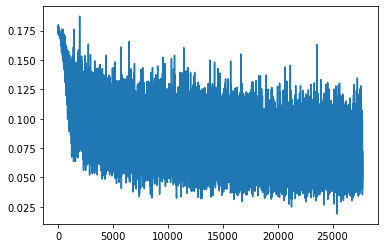

------
*********
29673 3218
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29673 464
Loss:  0.1667521595954895
Loss:  0.1632513552904129
Loss:  0.15775544941425323
0 **********
Epoch:  54.16317868232727  fold:  5  kers:  32
epoch:  1
29673 464
Loss:  0.16955061256885529
Loss:  0.14703749120235443
Loss:  0.13087667524814606
1 **********
Epoch:  95.73502373695374  fold:  5  kers:  32
epoch:  2
29673 464
Loss:  0.12958940863609314
Loss:  0.1053016409277916
Loss:  0.11740674823522568
2 **********
Epoch:  137.2430398464203  fold:  5  kers:  32
epoch:  3
Eval Loss:  0.17405350506305695
Eval Loss:  0.37598490715026855
Eval Loss:  0.35026729106903076
[[2714  383]
 [  42   79]]
              precision    r

Loss:  0.0957554280757904
Loss:  0.08865028619766235
10 **********
Epoch:  587.5709545612335  fold:  5  kers:  32
epoch:  11
29673 464
Loss:  0.10464833676815033
Loss:  0.0972057431936264
Loss:  0.10574229806661606
11 **********
Epoch:  629.3362834453583  fold:  5  kers:  32
epoch:  12
Eval Loss:  0.1084481030702591
Eval Loss:  0.1633380800485611
Eval Loss:  0.14396147429943085
[[2999   98]
 [  50   71]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      3097
           1       0.42      0.59      0.49       121

    accuracy                           0.95      3218
   macro avg       0.70      0.78      0.73      3218
weighted avg       0.96      0.95      0.96      3218

acc:  0.9540087010565569
pre:  0.42011834319526625
rec:  0.5867768595041323
ma F1:  0.7327872347588001
mi F1:  0.9540087010565569
we F1:  0.9576352824712742
update!  Acc:  0.9540087010565569
Eval Loss:  0.43606579303741455
Eval Loss:  0.2943873703479767
Eval Loss: 


acc:  0.9602237414543194
pre:  0.48223350253807107
rec:  0.7851239669421488
ma F1:  0.7882812034187191
mi F1:  0.9602237414543194
we F1:  0.9647298217614594
Eval Loss:  0.3572812080383301
Eval Loss:  0.279135525226593
Eval Loss:  0.3485376536846161
Eval Loss:  0.3097371459007263
Eval Loss:  0.33599382638931274
Eval Loss:  0.28725680708885193
Eval Loss:  0.2528509199619293
Eval Loss:  0.2322043627500534
Eval Loss:  0.27587080001831055
Eval Loss:  0.28500017523765564
Eval Loss:  0.26039132475852966
Eval Loss:  0.2734539806842804
Eval Loss:  0.25539594888687134
Eval Loss:  0.2679072618484497
Eval Loss:  0.2691010534763336
Eval Loss:  0.3213508427143097
Eval Loss:  0.35593077540397644
Eval Loss:  0.39471957087516785
Eval Loss:  0.38571611046791077
Eval Loss:  0.34156882762908936
Eval Loss:  0.34246575832366943
Eval Loss:  0.3694496750831604
Eval Loss:  0.31969377398490906
Eval Loss:  0.3274345397949219
Eval Loss:  0.40074819326400757
Eval Loss:  0.2937000095844269
Eval Loss:  0.3037895560

Eval Loss:  0.25959745049476624
Eval Loss:  0.26676180958747864
Eval Loss:  0.3265629708766937
Eval Loss:  0.3462204933166504
Eval Loss:  0.4271092414855957
Eval Loss:  0.36334481835365295
Eval Loss:  0.2880401313304901
Eval Loss:  0.3284943699836731
Eval Loss:  0.34726983308792114
Eval Loss:  0.2919248938560486
Eval Loss:  0.2969985902309418
Eval Loss:  0.41961848735809326
Eval Loss:  0.29106655716896057
Eval Loss:  0.2800256907939911
Eval Loss:  0.2987341284751892
Eval Loss:  0.22556062042713165
[[15867  1200]
 [ 2534 10072]]
              precision    recall  f1-score   support

           0       0.86      0.93      0.89     17067
           1       0.89      0.80      0.84     12606

    accuracy                           0.87     29673
   macro avg       0.88      0.86      0.87     29673
weighted avg       0.88      0.87      0.87     29673

acc:  0.8741616958177467
pre:  0.893541518807665
rec:  0.7989846105029351
ma F1:  0.869171873398433
mi F1:  0.8741616958177467
we F1:  0.87

Loss:  0.05774485692381859
Loss:  0.09987516701221466
Loss:  0.05640237033367157
39 **********
Epoch:  2184.6457011699677  fold:  5  kers:  32
epoch:  40
29673 464
Loss:  0.06666210293769836
Loss:  0.08957972377538681
Loss:  0.0860263854265213
40 **********
Epoch:  2226.221535682678  fold:  5  kers:  32
epoch:  41
29673 464
Loss:  0.06147018074989319
Loss:  0.07487582415342331
Loss:  0.07403172552585602
41 **********
Epoch:  2267.814325094223  fold:  5  kers:  32
epoch:  42
Eval Loss:  0.09002029895782471
Eval Loss:  0.08049864321947098
Eval Loss:  0.06317497789859772
[[3054   43]
 [  33   88]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3097
           1       0.67      0.73      0.70       121

    accuracy                           0.98      3218
   macro avg       0.83      0.86      0.84      3218
weighted avg       0.98      0.98      0.98      3218

acc:  0.9763828464885022
pre:  0.6717557251908397
rec:  0.7272727272727

 [  31   90]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3097
           1       0.74      0.74      0.74       121

    accuracy                           0.98      3218
   macro avg       0.86      0.87      0.87      3218
weighted avg       0.98      0.98      0.98      3218

acc:  0.9804226227470478
pre:  0.7377049180327869
rec:  0.743801652892562
ma F1:  0.8652839825131122
mi F1:  0.9804226227470478
we F1:  0.980461324810992
update!  Acc:  0.9804226227470478
Eval Loss:  0.2765670418739319
Eval Loss:  0.2886659801006317
Eval Loss:  0.2612667679786682
Eval Loss:  0.2781524360179901
Eval Loss:  0.2368774712085724
Eval Loss:  0.3182971179485321
Eval Loss:  0.22022667527198792
Eval Loss:  0.2289344221353531
Eval Loss:  0.19988076388835907
Eval Loss:  0.2876666486263275
Eval Loss:  0.23237554728984833
Eval Loss:  0.22924895584583282
Eval Loss:  0.23299522697925568
Eval Loss:  0.24153119325637817
Eval Loss:  0.22813038527965546

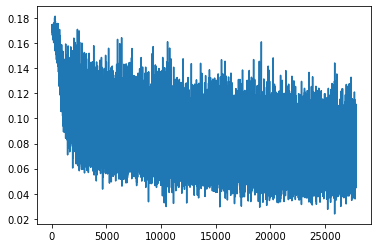

------
*********
29479 3412
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29479 461
Loss:  0.16897626221179962
Loss:  0.16309186816215515
Loss:  0.1630631536245346
0 **********
Epoch:  54.089375495910645  fold:  6  kers:  32
epoch:  1
29479 461
Loss:  0.1661711037158966
Loss:  0.15643464028835297
Loss:  0.14717592298984528
1 **********
Epoch:  95.58043670654297  fold:  6  kers:  32
epoch:  2
29479 461
Loss:  0.13759566843509674
Loss:  0.12227923423051834
Loss:  0.11651173233985901
2 **********
Epoch:  137.04955673217773  fold:  6  kers:  32
epoch:  3
Eval Loss:  0.16174215078353882
Eval Loss:  0.25149843096733093
Eval Loss:  0.6006743907928467
[[1667  565]
 [  72 1108]]
              precision   

Loss:  0.09346535056829453
Loss:  0.08117004483938217
Loss:  0.13495700061321259
11 **********
Epoch:  627.4692740440369  fold:  6  kers:  32
epoch:  12
Eval Loss:  0.05920136719942093
Eval Loss:  0.19355201721191406
Eval Loss:  0.491693377494812
[[1971  261]
 [ 125 1055]]
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      2232
           1       0.80      0.89      0.85      1180

    accuracy                           0.89      3412
   macro avg       0.87      0.89      0.88      3412
weighted avg       0.89      0.89      0.89      3412

acc:  0.8868698710433763
pre:  0.8016717325227963
rec:  0.8940677966101694
ma F1:  0.8780829363950898
mi F1:  0.8868698710433763
we F1:  0.8881744814278381
update!  Acc:  0.8868698710433763
Eval Loss:  0.3981528878211975
Eval Loss:  0.39983856678009033
Eval Loss:  0.3704363703727722
Eval Loss:  0.33356764912605286
Eval Loss:  0.505452036857605
Eval Loss:  0.3980896770954132
Eval Loss:  0.40235090

Eval Loss:  0.3716256320476532
Eval Loss:  0.3609042465686798
Eval Loss:  0.30730926990509033
Eval Loss:  0.3039967119693756
Eval Loss:  0.4195915162563324
Eval Loss:  0.3432331681251526
Eval Loss:  0.34957996010780334
Eval Loss:  0.31686902046203613
Eval Loss:  0.29827991127967834
Eval Loss:  0.27327480912208557
Eval Loss:  0.2640744149684906
Eval Loss:  0.42530086636543274
Eval Loss:  0.3359622061252594
Eval Loss:  0.3213958144187927
Eval Loss:  0.3155386447906494
Eval Loss:  0.30435147881507874
Eval Loss:  0.31817883253097534
Eval Loss:  0.3511807322502136
Eval Loss:  0.40342485904693604
Eval Loss:  0.2523225247859955
Eval Loss:  0.2833596467971802
Eval Loss:  0.2754899561405182
Eval Loss:  0.3783782124519348
Eval Loss:  0.3082304298877716
Eval Loss:  0.4030250310897827
Eval Loss:  0.29073527455329895
Eval Loss:  0.24909280240535736
Eval Loss:  0.20961764454841614
[[16537  1395]
 [ 2191  9356]]
              precision    recall  f1-score   support

           0       0.88      0.92 

Eval Loss:  0.31935974955558777
Eval Loss:  0.30382823944091797
Eval Loss:  0.39195436239242554
Eval Loss:  0.2850910425186157
Eval Loss:  0.1951388120651245
Eval Loss:  0.16895082592964172
[[16225  1707]
 [ 1712  9835]]
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     17932
           1       0.85      0.85      0.85     11547

    accuracy                           0.88     29479
   macro avg       0.88      0.88      0.88     29479
weighted avg       0.88      0.88      0.88     29479

acc:  0.8840191322636453
pre:  0.8521053543579968
rec:  0.851736381744176
ma F1:  0.8783008751723982
mi F1:  0.8840191322636453
we F1:  0.8840146578840746
29479 461
Loss:  0.10198096185922623
Loss:  0.11984986066818237
Loss:  0.046582963317632675
30 **********
Epoch:  1686.5076205730438  fold:  6  kers:  32
epoch:  31
29479 461
Loss:  0.08031132817268372
Loss:  0.10089179873466492
Loss:  0.07114998251199722
31 **********
Epoch:  1727.8480849266052 

Loss:  0.0767388716340065
Loss:  0.07744638621807098
Loss:  0.05861646309494972
39 **********
Epoch:  2175.586921930313  fold:  6  kers:  32
epoch:  40
29479 461
Loss:  0.04923854023218155
Loss:  0.04587269574403763
Loss:  0.04251469299197197
40 **********
Epoch:  2216.795738220215  fold:  6  kers:  32
epoch:  41
29479 461
Loss:  0.07861869037151337
Loss:  0.05724984034895897
Loss:  0.05119781196117401
41 **********
Epoch:  2257.9796204566956  fold:  6  kers:  32
epoch:  42
Eval Loss:  0.04244110360741615
Eval Loss:  0.18242283165454865
Eval Loss:  0.46213671565055847
[[2047  185]
 [ 154 1026]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      2232
           1       0.85      0.87      0.86      1180

    accuracy                           0.90      3412
   macro avg       0.89      0.89      0.89      3412
weighted avg       0.90      0.90      0.90      3412

acc:  0.9006447831184057
pre:  0.847233691164327
rec:  0.86949152542372

Eval Loss:  0.35535356402397156
Eval Loss:  0.3708459138870239
Eval Loss:  0.24571563303470612
Eval Loss:  0.2690436840057373
Eval Loss:  0.3385618329048157
Eval Loss:  0.28693658113479614
Eval Loss:  0.29317450523376465
Eval Loss:  0.22646547853946686
Eval Loss:  0.22942492365837097
Eval Loss:  0.1876170039176941
Eval Loss:  0.20208105444908142
Eval Loss:  0.3578822612762451
Eval Loss:  0.27001214027404785
Eval Loss:  0.25843071937561035
Eval Loss:  0.2165878266096115
Eval Loss:  0.22149521112442017
Eval Loss:  0.2046496421098709
Eval Loss:  0.2973864674568176
Eval Loss:  0.40212464332580566
Eval Loss:  0.1815083920955658
Eval Loss:  0.2383165806531906
Eval Loss:  0.21466758847236633
Eval Loss:  0.24037079513072968
Eval Loss:  0.31284716725349426
Eval Loss:  0.2889324128627777
Eval Loss:  0.23003193736076355
Eval Loss:  0.13058628141880035
Eval Loss:  0.1404457986354828
[[16470  1462]
 [ 1400 10147]]
              precision    recall  f1-score   support

           0       0.92      0

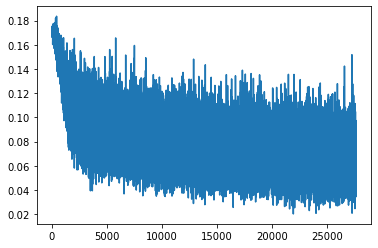

------
*********
29460 3431
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29460 461
Loss:  0.1711326241493225
Loss:  0.16954593360424042
Loss:  0.15177062153816223
0 **********
Epoch:  54.08239483833313  fold:  7  kers:  32
epoch:  1
29460 461
Loss:  0.1457124799489975
Loss:  0.1329369843006134
Loss:  0.11573135107755661
1 **********
Epoch:  95.73602151870728  fold:  7  kers:  32
epoch:  2
29460 461
Loss:  0.10479021072387695
Loss:  0.1169360876083374
Loss:  0.11007556319236755
2 **********
Epoch:  137.3268165588379  fold:  7  kers:  32
epoch:  3
Eval Loss:  0.8217025995254517
Eval Loss:  0.14486488699913025
Eval Loss:  2.0186686515808105
[[1688  439]
 [ 654  650]]
              precision    reca

Loss:  0.10826316475868225
Loss:  0.09623073786497116
Loss:  0.07790961116552353
11 **********
Epoch:  630.8612055778503  fold:  7  kers:  32
epoch:  12
Eval Loss:  0.9588589072227478
Eval Loss:  0.040319450199604034
Eval Loss:  3.438859224319458
[[2062   65]
 [ 952  352]]
              precision    recall  f1-score   support

           0       0.68      0.97      0.80      2127
           1       0.84      0.27      0.41      1304

    accuracy                           0.70      3431
   macro avg       0.76      0.62      0.61      3431
weighted avg       0.74      0.70      0.65      3431

acc:  0.7035849606528709
pre:  0.8441247002398081
rec:  0.26993865030674846
ma F1:  0.6056215309334299
mi F1:  0.7035849606528709
we F1:  0.6527700120206228
Eval Loss:  0.5033964514732361
Eval Loss:  0.43580085039138794
Eval Loss:  0.36972105503082275
Eval Loss:  0.5873017907142639
Eval Loss:  0.4187915623188019
Eval Loss:  0.37443819642066956
Eval Loss:  0.29980042576789856
Eval Loss:  0.3207667

Eval Loss:  0.39178434014320374
Eval Loss:  0.36540505290031433
Eval Loss:  0.28626856207847595
Eval Loss:  0.4677894711494446
Eval Loss:  0.31538641452789307
Eval Loss:  0.2914792001247406
Eval Loss:  0.2548995018005371
Eval Loss:  0.2712671756744385
Eval Loss:  0.31877458095550537
Eval Loss:  0.43032920360565186
Eval Loss:  0.4284517467021942
Eval Loss:  0.33096736669540405
Eval Loss:  0.30087539553642273
Eval Loss:  0.2520870566368103
Eval Loss:  0.28320810198783875
Eval Loss:  0.2625994384288788
Eval Loss:  0.30478253960609436
Eval Loss:  0.3954246938228607
Eval Loss:  0.25357919931411743
Eval Loss:  0.41334718465805054
Eval Loss:  0.22279228270053864
Eval Loss:  0.3189375400543213
Eval Loss:  0.24514923989772797
Eval Loss:  0.2760888636112213
Eval Loss:  0.2517653703689575
Eval Loss:  0.4039498269557953
Eval Loss:  0.23888924717903137
Eval Loss:  0.3370826244354248
[[17183   854]
 [ 2883  8540]]
              precision    recall  f1-score   support

           0       0.86      0.

Eval Loss:  0.2922600209712982
Eval Loss:  0.23413021862506866
Eval Loss:  0.2286500632762909
Eval Loss:  0.17826707661151886
Eval Loss:  0.3923184275627136
Eval Loss:  0.24702048301696777
Eval Loss:  0.3366047143936157
[[17137   900]
 [ 2580  8843]]
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     18037
           1       0.91      0.77      0.84     11423

    accuracy                           0.88     29460
   macro avg       0.89      0.86      0.87     29460
weighted avg       0.88      0.88      0.88     29460

acc:  0.8818737270875764
pre:  0.9076259878887406
rec:  0.774139893197934
ma F1:  0.8717048546308963
mi F1:  0.8818737270875764
we F1:  0.8798139603010775
29460 461
Loss:  0.08345909416675568
Loss:  0.07203108817338943
Loss:  0.08463302999734879
30 **********
Epoch:  1694.7017121315002  fold:  7  kers:  32
epoch:  31
29460 461
Loss:  0.053751930594444275
Loss:  0.07434514909982681
Loss:  0.09751009941101074
31 ********

Loss:  0.08013294637203217
Loss:  0.06324027478694916
Loss:  0.06352387368679047
39 **********
Epoch:  2186.312245607376  fold:  7  kers:  32
epoch:  40
29460 461
Loss:  0.07085995376110077
Loss:  0.07494685053825378
Loss:  0.04478207975625992
40 **********
Epoch:  2227.8721227645874  fold:  7  kers:  32
epoch:  41
29460 461
Loss:  0.06319631636142731
Loss:  0.08240891993045807
Loss:  0.06675117462873459
41 **********
Epoch:  2269.392106771469  fold:  7  kers:  32
epoch:  42
Eval Loss:  0.7130804061889648
Eval Loss:  0.16841652989387512
Eval Loss:  2.278496503829956
[[1959  168]
 [ 672  632]]
              precision    recall  f1-score   support

           0       0.74      0.92      0.82      2127
           1       0.79      0.48      0.60      1304

    accuracy                           0.76      3431
   macro avg       0.77      0.70      0.71      3431
weighted avg       0.76      0.76      0.74      3431

acc:  0.7551734188283299
pre:  0.79
rec:  0.48466257668711654
ma F1:  0.7

Eval Loss:  0.2858791649341583
Eval Loss:  0.24184256792068481
Eval Loss:  0.2634320557117462
Eval Loss:  0.33060702681541443
Eval Loss:  0.18354609608650208
Eval Loss:  0.22905056178569794
Eval Loss:  0.1824273318052292
Eval Loss:  0.2577097415924072
Eval Loss:  0.2794937789440155
Eval Loss:  0.32758551836013794
Eval Loss:  0.3460196256637573
Eval Loss:  0.2612093985080719
Eval Loss:  0.23194169998168945
Eval Loss:  0.22635021805763245
Eval Loss:  0.21598681807518005
Eval Loss:  0.24033324420452118
Eval Loss:  0.2564241588115692
Eval Loss:  0.2678477466106415
Eval Loss:  0.23400601744651794
Eval Loss:  0.2589833736419678
Eval Loss:  0.21310636401176453
Eval Loss:  0.2967177927494049
Eval Loss:  0.21168841421604156
Eval Loss:  0.17495502531528473
Eval Loss:  0.13890190422534943
Eval Loss:  0.278775155544281
Eval Loss:  0.1813036948442459
Eval Loss:  0.2802686095237732
[[16539  1498]
 [ 1471  9952]]
              precision    recall  f1-score   support

           0       0.92      0.92

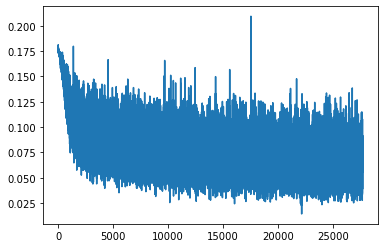

------
*********
29817 3074
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29817 466
Loss:  0.17328748106956482
Loss:  0.16733957827091217
Loss:  0.15674114227294922
0 **********
Epoch:  54.465370416641235  fold:  8  kers:  32
epoch:  1
29817 466
Loss:  0.1297791749238968
Loss:  0.1225755512714386
Loss:  0.11262357980012894
1 **********
Epoch:  96.67251682281494  fold:  8  kers:  32
epoch:  2
29817 466
Loss:  0.11420325934886932
Loss:  0.09987316280603409
Loss:  0.11244233697652817
2 **********
Epoch:  138.78990387916565  fold:  8  kers:  32
epoch:  3
Eval Loss:  0.29717111587524414
Eval Loss:  0.9540808200836182
Eval Loss:  0.23537397384643555
[[1890  183]
 [ 383  618]]
              precision   

10 **********
Epoch:  594.8923783302307  fold:  8  kers:  32
epoch:  11
29817 466
Loss:  0.0928303524851799
Loss:  0.07674864679574966
Loss:  0.07617046684026718
11 **********
Epoch:  636.5539836883545  fold:  8  kers:  32
epoch:  12
Eval Loss:  0.32926735281944275
Eval Loss:  1.4956414699554443
Eval Loss:  0.21012981235980988
[[1910  163]
 [ 386  615]]
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      2073
           1       0.79      0.61      0.69      1001

    accuracy                           0.82      3074
   macro avg       0.81      0.77      0.78      3074
weighted avg       0.82      0.82      0.81      3074

acc:  0.8214053350683149
pre:  0.7904884318766067
rec:  0.6143856143856143
ma F1:  0.7828708087062883
mi F1:  0.8214053350683149
we F1:  0.8147696598723828
Eval Loss:  0.3322938084602356
Eval Loss:  0.31653451919555664
Eval Loss:  0.2965908646583557
Eval Loss:  0.31655895709991455
Eval Loss:  0.3353702425956726
Eval

Eval Loss:  0.314534068107605
Eval Loss:  0.29543474316596985
Eval Loss:  0.2915131747722626
Eval Loss:  0.3354550302028656
Eval Loss:  0.3269769549369812
Eval Loss:  0.3042224049568176
Eval Loss:  0.336342453956604
Eval Loss:  0.31057125329971313
Eval Loss:  0.3817562460899353
Eval Loss:  0.286896288394928
Eval Loss:  0.32657745480537415
Eval Loss:  0.35565653443336487
Eval Loss:  0.3582260310649872
Eval Loss:  0.3730546534061432
Eval Loss:  0.30511757731437683
Eval Loss:  0.2677699327468872
Eval Loss:  0.3225760757923126
Eval Loss:  0.33955246210098267
Eval Loss:  0.3409830927848816
Eval Loss:  0.36014795303344727
Eval Loss:  0.20830073952674866
Eval Loss:  0.3881836533546448
Eval Loss:  0.3514789044857025
Eval Loss:  0.20315277576446533
Eval Loss:  0.3294191062450409
Eval Loss:  0.3933559060096741
Eval Loss:  0.24976643919944763
Eval Loss:  0.3631143271923065
Eval Loss:  0.27735278010368347
[[17201   890]
 [ 2974  8752]]
              precision    recall  f1-score   support

       

Eval Loss:  0.37913575768470764
Eval Loss:  0.32300975918769836
Eval Loss:  0.1898490935564041
Eval Loss:  0.29256579279899597
Eval Loss:  0.3568466007709503
Eval Loss:  0.24400007724761963
Eval Loss:  0.34414929151535034
Eval Loss:  0.2808898687362671
[[17276   815]
 [ 2801  8925]]
              precision    recall  f1-score   support

           0       0.86      0.95      0.91     18091
           1       0.92      0.76      0.83     11726

    accuracy                           0.88     29817
   macro avg       0.89      0.86      0.87     29817
weighted avg       0.88      0.88      0.88     29817

acc:  0.8787269007613107
pre:  0.9163244353182751
rec:  0.7611291147876513
ma F1:  0.8684042575857043
mi F1:  0.8787269007613108
we F1:  0.8762720128021735
29817 466
Loss:  0.07764188945293427
Loss:  0.054106105118989944
Loss:  0.10535553842782974
30 **********
Epoch:  1709.6786661148071  fold:  8  kers:  32
epoch:  31
29817 466
Loss:  0.07082843780517578
Loss:  0.06771472841501236
Loss

Loss:  0.07459578663110733
Loss:  0.0901440903544426
Loss:  0.09781581908464432
39 **********
Epoch:  2203.9071996212006  fold:  8  kers:  32
epoch:  40
29817 466
Loss:  0.08023726940155029
Loss:  0.047051191329956055
Loss:  0.06608673185110092
40 **********
Epoch:  2245.6675407886505  fold:  8  kers:  32
epoch:  41
29817 466
Loss:  0.0643988847732544
Loss:  0.07891172915697098
Loss:  0.07526230812072754
41 **********
Epoch:  2287.4947035312653  fold:  8  kers:  32
epoch:  42
Eval Loss:  0.5973829627037048
Eval Loss:  1.3315566778182983
Eval Loss:  0.14028960466384888
[[1662  411]
 [ 328  673]]
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      2073
           1       0.62      0.67      0.65      1001

    accuracy                           0.76      3074
   macro avg       0.73      0.74      0.73      3074
weighted avg       0.77      0.76      0.76      3074

acc:  0.7595966167859467
pre:  0.6208487084870848
rec:  0.6723276723276

Eval Loss:  0.24353215098381042
Eval Loss:  0.31863918900489807
Eval Loss:  0.22442340850830078
Eval Loss:  0.3253971040248871
Eval Loss:  0.300420343875885
Eval Loss:  0.29564738273620605
Eval Loss:  0.2419927716255188
Eval Loss:  0.22778552770614624
Eval Loss:  0.3115166127681732
Eval Loss:  0.2551736533641815
Eval Loss:  0.22065380215644836
Eval Loss:  0.279628723859787
Eval Loss:  0.23207050561904907
Eval Loss:  0.29070883989334106
Eval Loss:  0.3060038387775421
Eval Loss:  0.1835346817970276
Eval Loss:  0.30794671177864075
Eval Loss:  0.3162427842617035
Eval Loss:  0.29959341883659363
Eval Loss:  0.2858184278011322
Eval Loss:  0.20542196929454803
Eval Loss:  0.3211917281150818
Eval Loss:  0.3023045063018799
Eval Loss:  0.15560351312160492
Eval Loss:  0.2140769511461258
Eval Loss:  0.31844574213027954
Eval Loss:  0.22125564515590668
Eval Loss:  0.2715292274951935
Eval Loss:  0.26439109444618225
[[16136  1955]
 [ 1386 10340]]
              precision    recall  f1-score   support

  

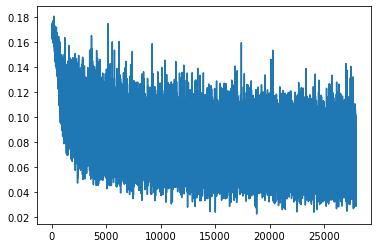

------
*********
29483 3408
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29483 461
Loss:  0.17100244760513306
Loss:  0.16744323074817657
Loss:  0.1530085802078247
0 **********
Epoch:  53.74629259109497  fold:  9  kers:  32
epoch:  1
29483 461
Loss:  0.14174099266529083
Loss:  0.13724751770496368
Loss:  0.129305899143219
1 **********
Epoch:  95.22039937973022  fold:  9  kers:  32
epoch:  2
29483 461
Loss:  0.1164548322558403
Loss:  0.10925540328025818
Loss:  0.1491689383983612
2 **********
Epoch:  136.5289487838745  fold:  9  kers:  32
epoch:  3
Eval Loss:  0.2608794867992401
Eval Loss:  0.744112491607666
Eval Loss:  0.36103397607803345
[[1369  373]
 [ 255 1411]]
              precision    recall

Loss:  0.06861656904220581
Loss:  0.07136593759059906
Loss:  0.13298776745796204
11 **********
Epoch:  626.739226102829  fold:  9  kers:  32
epoch:  12
Eval Loss:  0.0792195200920105
Eval Loss:  1.2939902544021606
Eval Loss:  0.21372048556804657
[[1627  115]
 [ 454 1212]]
              precision    recall  f1-score   support

           0       0.78      0.93      0.85      1742
           1       0.91      0.73      0.81      1666

    accuracy                           0.83      3408
   macro avg       0.85      0.83      0.83      3408
weighted avg       0.85      0.83      0.83      3408

acc:  0.8330399061032864
pre:  0.9133383571966842
rec:  0.7274909963985594
ma F1:  0.8305268750285675
mi F1:  0.8330399061032864
we F1:  0.8309870927675521
update!  Acc:  0.8330399061032864
Eval Loss:  0.26725566387176514
Eval Loss:  0.3301151692867279
Eval Loss:  0.36599263548851013
Eval Loss:  0.3878526985645294
Eval Loss:  0.34502506256103516
Eval Loss:  0.44874054193496704
Eval Loss:  0.326992

Eval Loss:  0.24287769198417664
Eval Loss:  0.2720305323600769
Eval Loss:  0.33580252528190613
Eval Loss:  0.3454536199569702
Eval Loss:  0.31943103671073914
Eval Loss:  0.38489019870758057
Eval Loss:  0.3268057703971863
Eval Loss:  0.3566177189350128
Eval Loss:  0.27015602588653564
Eval Loss:  0.20238560438156128
Eval Loss:  0.2602103352546692
Eval Loss:  0.2742222547531128
Eval Loss:  0.198820561170578
Eval Loss:  0.31936901807785034
Eval Loss:  0.21287332475185394
Eval Loss:  0.3267948627471924
Eval Loss:  0.29407647252082825
Eval Loss:  0.2787580192089081
Eval Loss:  0.294613778591156
Eval Loss:  0.27758902311325073
Eval Loss:  0.2631283700466156
Eval Loss:  0.3551968038082123
Eval Loss:  0.33748629689216614
Eval Loss:  0.20647791028022766
Eval Loss:  0.25506868958473206
Eval Loss:  0.25398483872413635
Eval Loss:  0.2299633026123047
Eval Loss:  0.296487420797348
[[17148  1274]
 [ 2135  8926]]
              precision    recall  f1-score   support

           0       0.89      0.93  

Eval Loss:  0.2962559461593628
Eval Loss:  0.19728252291679382
Eval Loss:  0.21827788650989532
Eval Loss:  0.21805121004581451
Eval Loss:  0.19999255239963531
Eval Loss:  0.26490068435668945
[[17037  1385]
 [ 1816  9245]]
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     18422
           1       0.87      0.84      0.85     11061

    accuracy                           0.89     29483
   macro avg       0.89      0.88      0.88     29483
weighted avg       0.89      0.89      0.89     29483

acc:  0.8914289590611539
pre:  0.8697083725305739
rec:  0.8358195461531507
ma F1:  0.8832760112377738
mi F1:  0.8914289590611539
we F1:  0.8909779939030588
29483 461
Loss:  0.09823168069124222
Loss:  0.06851007044315338
Loss:  0.04262284189462662
30 **********
Epoch:  1688.2359993457794  fold:  9  kers:  32
epoch:  31
29483 461
Loss:  0.06478475034236908
Loss:  0.08555382490158081
Loss:  0.05377001315355301
31 **********
Epoch:  1729.5874338150024

Loss:  0.04934817552566528
Loss:  0.08686873316764832
Loss:  0.04378635808825493
39 **********
Epoch:  2177.561641931534  fold:  9  kers:  32
epoch:  40
29483 461
Loss:  0.0662636011838913
Loss:  0.08530723303556442
Loss:  0.07061951607465744
40 **********
Epoch:  2218.862212896347  fold:  9  kers:  32
epoch:  41
29483 461
Loss:  0.05597013235092163
Loss:  0.07549560070037842
Loss:  0.05486278980970383
41 **********
Epoch:  2260.1777431964874  fold:  9  kers:  32
epoch:  42
Eval Loss:  0.03745904937386513
Eval Loss:  1.2327972650527954
Eval Loss:  0.13189786672592163
[[1649   93]
 [ 396 1270]]
              precision    recall  f1-score   support

           0       0.81      0.95      0.87      1742
           1       0.93      0.76      0.84      1666

    accuracy                           0.86      3408
   macro avg       0.87      0.85      0.85      3408
weighted avg       0.87      0.86      0.86      3408

acc:  0.8565140845070423
pre:  0.9317681584739546
rec:  0.76230492196878

Eval Loss:  0.2524928152561188
Eval Loss:  0.20529226958751678
Eval Loss:  0.28700578212738037
Eval Loss:  0.25154685974121094
Eval Loss:  0.2607329487800598
Eval Loss:  0.3005107641220093
Eval Loss:  0.24172599613666534
Eval Loss:  0.29108288884162903
Eval Loss:  0.21082749962806702
Eval Loss:  0.17771318554878235
Eval Loss:  0.1787668764591217
Eval Loss:  0.24180404841899872
Eval Loss:  0.1558290719985962
Eval Loss:  0.21565525233745575
Eval Loss:  0.16773611307144165
Eval Loss:  0.30417609214782715
Eval Loss:  0.17638644576072693
Eval Loss:  0.25182899832725525
Eval Loss:  0.22114714980125427
Eval Loss:  0.18680548667907715
Eval Loss:  0.22998645901679993
Eval Loss:  0.2665373980998993
Eval Loss:  0.25686898827552795
Eval Loss:  0.16266094148159027
Eval Loss:  0.20713727176189423
Eval Loss:  0.17629411816596985
Eval Loss:  0.18082968890666962
Eval Loss:  0.25206735730171204
[[17260  1162]
 [ 1626  9435]]
              precision    recall  f1-score   support

           0       0.91 

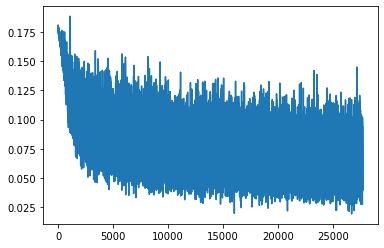

------
*********
29871 3020
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29871 467
Loss:  0.16805724799633026
Loss:  0.16585426032543182
Loss:  0.1741877794265747
0 **********
Epoch:  54.326740741729736  fold:  10  kers:  32
epoch:  1
29871 467
Loss:  0.14024978876113892
Loss:  0.14167217910289764
Loss:  0.1261066347360611
1 **********
Epoch:  96.54785013198853  fold:  10  kers:  32
epoch:  2
29871 467
Loss:  0.1174386590719223
Loss:  0.10483840107917786
Loss:  0.09776780754327774
2 **********
Epoch:  138.66423964500427  fold:  10  kers:  32
epoch:  3
Eval Loss:  0.39809560775756836
Eval Loss:  0.38300350308418274
Eval Loss:  0.20338203012943268
[[1485  266]
 [ 142 1127]]
              precision

Loss:  0.0824429914355278
Loss:  0.09049919247627258
10 **********
Epoch:  592.999439239502  fold:  10  kers:  32
epoch:  11
29871 467
Loss:  0.08382278680801392
Loss:  0.0926850363612175
Loss:  0.10255564749240875
11 **********
Epoch:  634.785712480545  fold:  10  kers:  32
epoch:  12
Eval Loss:  0.37264546751976013
Eval Loss:  0.17221428453922272
Eval Loss:  0.13393576443195343
[[1614  137]
 [ 149 1120]]
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1751
           1       0.89      0.88      0.89      1269

    accuracy                           0.91      3020
   macro avg       0.90      0.90      0.90      3020
weighted avg       0.91      0.91      0.91      3020

acc:  0.9052980132450331
pre:  0.8910103420843277
rec:  0.8825847123719465
ma F1:  0.9026943915323887
mi F1:  0.9052980132450331
we F1:  0.905234767373471
update!  Acc:  0.9052980132450331
Eval Loss:  0.38459938764572144
Eval Loss:  0.3207600712776184
Eval Loss: 

Eval Loss:  0.3488008677959442
Eval Loss:  0.30308210849761963
Eval Loss:  0.3759908378124237
Eval Loss:  0.3200090825557709
Eval Loss:  0.2917042672634125
Eval Loss:  0.32230594754219055
Eval Loss:  0.39556050300598145
Eval Loss:  0.3983301818370819
Eval Loss:  0.4776456654071808
Eval Loss:  0.27568158507347107
Eval Loss:  0.2993521988391876
Eval Loss:  0.3183556795120239
Eval Loss:  0.23520252108573914
Eval Loss:  0.38540980219841003
Eval Loss:  0.30528876185417175
Eval Loss:  0.3055662214756012
Eval Loss:  0.378580242395401
Eval Loss:  0.26493653655052185
Eval Loss:  0.2697613835334778
Eval Loss:  0.4209912419319153
Eval Loss:  0.36972007155418396
Eval Loss:  0.4234163761138916
Eval Loss:  0.3828164041042328
Eval Loss:  0.34092482924461365
Eval Loss:  0.4431034326553345
Eval Loss:  0.25299134850502014
Eval Loss:  0.35457363724708557
Eval Loss:  0.3875666856765747
Eval Loss:  0.34836843609809875
[[17717   696]
 [ 3626  7832]]
              precision    recall  f1-score   support

   

Eval Loss:  0.2335316240787506
Eval Loss:  0.3631439208984375
Eval Loss:  0.2983412444591522
Eval Loss:  0.3796190321445465
Eval Loss:  0.335499107837677
Eval Loss:  0.2957507073879242
Eval Loss:  0.3560670018196106
Eval Loss:  0.20915214717388153
Eval Loss:  0.31775379180908203
Eval Loss:  0.3226816952228546
Eval Loss:  0.2843100428581238
[[17334  1079]
 [ 2521  8937]]
              precision    recall  f1-score   support

           0       0.87      0.94      0.91     18413
           1       0.89      0.78      0.83     11458

    accuracy                           0.88     29871
   macro avg       0.88      0.86      0.87     29871
weighted avg       0.88      0.88      0.88     29871

acc:  0.8794817716179573
pre:  0.8922723642172524
rec:  0.7799790539361146
ma F1:  0.8691410146519483
mi F1:  0.8794817716179572
we F1:  0.8777059741254021
29871 467
Loss:  0.062462322413921356
Loss:  0.04553896188735962
Loss:  0.08198165893554688
30 **********
Epoch:  1710.2501378059387  fold:  10 

Loss:  0.061924923211336136
Loss:  0.052797265350818634
Loss:  0.0658850446343422
39 **********
Epoch:  2208.68941283226  fold:  10  kers:  32
epoch:  40
29871 467
Loss:  0.07363011687994003
Loss:  0.07924224436283112
Loss:  0.07257837057113647
40 **********
Epoch:  2250.757929801941  fold:  10  kers:  32
epoch:  41
29871 467
Loss:  0.0655307024717331
Loss:  0.06345859169960022
Loss:  0.073560930788517
41 **********
Epoch:  2292.730703353882  fold:  10  kers:  32
epoch:  42
Eval Loss:  0.4785183072090149
Eval Loss:  0.10381456464529037
Eval Loss:  0.14267250895500183
[[1624  127]
 [ 173 1096]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1751
           1       0.90      0.86      0.88      1269

    accuracy                           0.90      3020
   macro avg       0.90      0.90      0.90      3020
weighted avg       0.90      0.90      0.90      3020

acc:  0.9006622516556292
pre:  0.8961569910057237
rec:  0.86367218282111

Eval Loss:  0.23313647508621216
Eval Loss:  0.2478771209716797
Eval Loss:  0.29797083139419556
Eval Loss:  0.29927390813827515
Eval Loss:  0.2571316063404083
Eval Loss:  0.232443705201149
Eval Loss:  0.28401294350624084
Eval Loss:  0.24784722924232483
Eval Loss:  0.34245675802230835
Eval Loss:  0.22386384010314941
Eval Loss:  0.20089755952358246
Eval Loss:  0.20001579821109772
Eval Loss:  0.2162935584783554
Eval Loss:  0.27653253078460693
Eval Loss:  0.22698524594306946
Eval Loss:  0.23674878478050232
Eval Loss:  0.3048473298549652
Eval Loss:  0.19698719680309296
Eval Loss:  0.19420413672924042
Eval Loss:  0.3195067346096039
Eval Loss:  0.263554185628891
Eval Loss:  0.31561917066574097
Eval Loss:  0.29975640773773193
Eval Loss:  0.2676655650138855
Eval Loss:  0.3128957748413086
Eval Loss:  0.18926092982292175
Eval Loss:  0.28007829189300537
Eval Loss:  0.29590556025505066
Eval Loss:  0.25252193212509155
[[17303  1110]
 [ 2097  9361]]
              precision    recall  f1-score   suppor

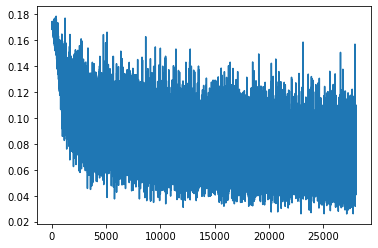

------


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from time import time
for kers in [128,64,32]:
    print("  ")
    print("kernel:",kers)
    print("  ")
    for fold in range(1,11):
        begin=time()
        #train_rec,test_rec=reclist[train_idx],reclist[test_idx]
        train_dtlist,test_dtlist=getTrainTestList(reclist,opt='kfold',fold = fold)#fold 1-10   
        print('*********')

        train_dtlist=[file for file in train_dtlist if dtclean(file)==0]
        np.random.shuffle(train_dtlist)
        test_dtlist=[file for file in test_dtlist if dtclean(file)==0]
        print(len(train_dtlist),len(test_dtlist))
        model = MyLSTM(2,kers).to(device)

        #model.features[0]=nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
        for m in model.modules():
            if isinstance(m, nn.Conv2d):
                if(m.in_channels!=m.out_channels or m.out_channels!=m.groups or m.bias is not None):
                    # don't want to reinitialize downsample layers, code assuming normal conv layers will not have these characteristics
                    #nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                    nn.init.normal_(m.weight, mean=0, std=0.1)
                    print(m,'init')
                else:
                    print('Not initializing')
        criterion=nn.CrossEntropyLoss().to(device)#weight=torch.FloatTensor([1,1.5])
        #criterion = CircleLoss(m=0.25, gamma=256)
        opt=torch.optim.Adam(model.parameters(), lr=0.0003, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001)
        loss_list=[]

        opt.zero_grad()
        epoch_flag=0
        best_acc=0
        for epoch in range(60):
            print('epoch: ', epoch)
            if epoch_flag%3==0 and epoch_flag!=0:
                model.eval()
                prob_file,lab_file,tmp_acc,seg_file=eval(model,test_dtlist,criterion,device)
                if tmp_acc>best_acc:
                    best_acc=tmp_acc                   
                    res_file_name="./weights/fold_%.0f_w_%.0f_fs_%.0f.csv"%(fold,kers,48)
                    res_file=pd.DataFrame({"prob":prob_file,'label':lab_file,'seg':seg_file})
                    res_file.to_csv(res_file_name,index=False)
                    torch.save(model.state_dict(), "./weights/fold_%.0f_w_%.0f_fs_%.0f.pkl"%(fold,kers,48))
                    print("update! ",'Acc: ',best_acc)
                #eval(model,train_dtlist[0:int(len(train_dtlist)*0.9)],criterion)
                _,_,_,_=eval(model,train_dtlist,criterion,device)
                model.train()
            train_dataset = ApneaECGDataset(train_dtlist,istrain=False)
            #test_dataset = ApneaECGDataset(test_dtlist,istrain=False)
            train_loader=DataLoader(train_dataset, batch_size=64, shuffle=True, sampler=None, num_workers=0)

            #test_loader=DataLoader(test_dataset, batch_size=256, shuffle=True, sampler=None, num_workers=0)
            print(len(train_dataset),len(train_loader)) #,len(test_dataset)
            flag=0
            accum_flag=0
            for fe, label,seg_id in train_loader:
                del seg_id
                fe=fe.float().to(device)
                #fe=(fe-fe_mean)/fe_std
                #fe=torch.stft(fe,100,hop_length=50,onesided=True)

                label=label.long().to(device)
                pred_prob_no_softmax=model(fe)
                loss=criterion(pred_prob_no_softmax,label)/4#/256
                del label
                del fe
                #inp_sp, inp_sn = convert_label_to_similarity(pred_prob_no_softmax,label)
                #loss = criterion(inp_sp, inp_sn)/256
                
                loss_list.append(loss.item())
                loss.backward()
                accum_flag+=1
                if accum_flag%4==0:
                    opt.step()
                    accum_flag=0
                    opt.zero_grad()
                flag+=1
                if flag%128==0:
                    print("Loss: ", loss.item())
                #print('step')
            print(epoch_flag,'*'*10)
            epoch_flag+=1
            #scheduler.step()
            print('Epoch: ', time()-begin,' fold: ',fold,' kers: ',kers)
            
        model.eval()

        prob_file,lab_file,tmp_acc,seg_file=eval(model,test_dtlist,criterion,device)
        if tmp_acc>best_acc:
            best_acc=tmp_acc                   
            res_file_name="./weights/fold_%.0f_w_%.0f_fs_%.0f.csv"%(fold,kers,48)
            res_file=pd.DataFrame({"prob":prob_file,'label':lab_file,'seg':seg_file})
            res_file.to_csv(res_file_name,index=False)
            torch.save(model.state_dict(), "./weights/fold_%.0f_w_%.0f_fs_%.0f.pkl"%(fold,kers,48))
        print("update! ",'Acc: ',best_acc)
        #eval(model,train_dtlist[0:int(len(train_dtlist)*0.9)],criterion)

        print('Epoch: ', time()-begin,' fold: ',fold,' kers: ',kers)
        plt.plot(loss_list)
        plt.show()
        plt.close('all')
        print('------')

In [9]:
print('blind val','^^^^^^^^^^^^^^^^^^^^')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from time import time
for kers in [128,64,32]:
    print("  ")
    print("kernel:",kers)
    print("  ")
    for fold in range(1,11):
        begin=time()
        #train_rec,test_rec=reclist[train_idx],reclist[test_idx]
        train_dtlist,test_dtlist=getTrainTestList(reclist,opt='blind',fold = fold)#fold 1-10   
        print('*********')

        train_dtlist=[file for file in train_dtlist if dtclean(file)==0]
        np.random.shuffle(train_dtlist)
        test_dtlist=[file for file in test_dtlist if dtclean(file)==0]
        print(len(train_dtlist),len(test_dtlist))
        model = MyLSTM(2,kers).to(device)

        #model.features[0]=nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
        for m in model.modules():
            if isinstance(m, nn.Conv2d):
                if(m.in_channels!=m.out_channels or m.out_channels!=m.groups or m.bias is not None):
                    # don't want to reinitialize downsample layers, code assuming normal conv layers will not have these characteristics
                    #nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                    nn.init.normal_(m.weight, mean=0, std=0.1)
                    print(m,'init')
                else:
                    print('Not initializing')
        criterion=nn.CrossEntropyLoss().to(device)#weight=torch.FloatTensor([1,1.5])
        #criterion = CircleLoss(m=0.25, gamma=256)
        opt=torch.optim.Adam(model.parameters(), lr=0.0003, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001)
        loss_list=[]

        opt.zero_grad()
        epoch_flag=0
        for epoch in range(60):
            print('epoch: ', epoch)
            if epoch_flag%3==0 and epoch_flag!=0:
                model.eval()
                eval(model,test_dtlist,criterion,device)
                #eval(model,train_dtlist[0:int(len(train_dtlist)*0.9)],criterion)
                eval(model,train_dtlist,criterion,device)
                model.train()
            train_dataset = ApneaECGDataset(train_dtlist,istrain=False)
            #test_dataset = ApneaECGDataset(test_dtlist,istrain=False)
            train_loader=DataLoader(train_dataset, batch_size=256, shuffle=True, sampler=None, num_workers=0)

            #test_loader=DataLoader(test_dataset, batch_size=256, shuffle=True, sampler=None, num_workers=0)
            print(len(train_dataset),len(train_loader)) #,len(test_dataset)
            flag=0
            for fe, label in train_loader:
                fe=fe.float().to(device)
                #fe=(fe-fe_mean)/fe_std
                #fe=torch.stft(fe,100,hop_length=50,onesided=True)

                label=label.long().to(device)
                pred_prob_no_softmax=model(fe)
                loss=criterion(pred_prob_no_softmax,label)#/256

                #inp_sp, inp_sn = convert_label_to_similarity(pred_prob_no_softmax,label)
                #loss = criterion(inp_sp, inp_sn)/256

                loss_list.append(loss.item())
                loss.backward()
                opt.step()
                opt.zero_grad()
                flag+=1
                if flag%4==0:
                    print("Loss: ", loss.item())

                #print('step')
            print(epoch_flag,'*'*10)
            epoch_flag+=1
            #scheduler.step()
            
        model.eval()
        eval(model,test_dtlist,criterion,device)
        print('Epoch: ', time()-begin,' fold: ',fold,' kers: ',kers)
        plt.plot(loss_list)
        plt.show()
        plt.close('all')
        print('------')

blind val ^^^^^^^^^^^^^^^^^^^^
  
kernel: 128
  
70 0 []
*********
32891 0
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
32891 129


ValueError: too many values to unpack (expected 2)